## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (512, 614)
Hypercube shape: (512, 614, 176)


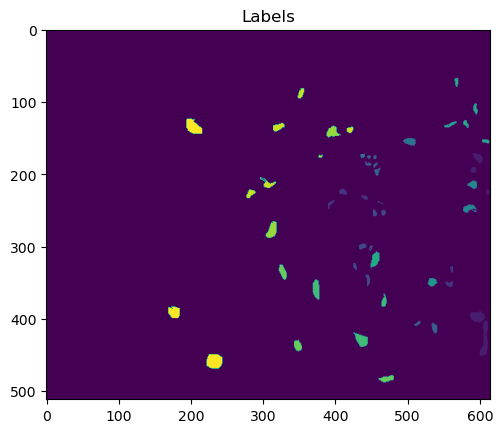

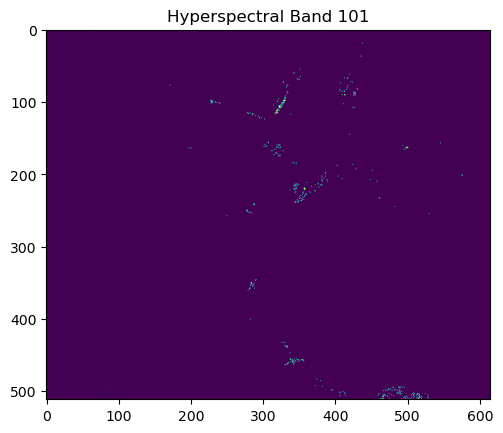

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'KSC_gt.mat'
data_files = 'KSC.mat'
label_files = 'KSC_gt'
hypercube_files = 'KSC'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 5211
Extracted windows shape: (5211, 5, 5, 176)
Corresponding labels shape: (5211,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 5)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 761 samples
Shuffled class indices for class '1'
Selected 5 training samples and 5 validation samples for class '1'

Class: 2: Found 243 samples
Shuffled class indices for class '2'
Selected 5 training samples and 5 validation samples for class '2'

Class: 3: Found 256 samples
Shuffled class indices for class '3'
Selected 5 training samples and 5 validation samples for class '3'

Class: 4: Found 252 samples
Shuffled class indices for class '4'
Selected 5 training samples and 5 validation samples for class '4'

Class: 5: Found 161 samples
Shuffled class indices for class '5'
Selected 5 training samples and 5 validation samples for class '5'

Class: 6: Found 229 samples
Shuffled class indices for class '6'
Selected 5 training samples and 5 validation samples for class '6'

Class: 7: Found 105 samples
Shuffled class indices for class '7'
Selected 5


All datasets saved to the 'indices' folder.
(65, 5, 5, 176)
(65, 5, 5, 176)
(5081, 5, 5, 176)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 65
Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (4168, 5, 5, 176)
Validation data shape: (1043, 5, 5, 176)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

176


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/66], Loss: 0.2517, PSNR: 5.9914


Epoch [1/50] Training Loss: 0.2413, PSNR: 5.4898
	[Val]   Batch [1/17] Loss: 0.2270, PSNR: 6.4393
	[Val]   Batch [10/17] Loss: 0.2273, PSNR: 6.4333
Epoch [1/50] Validation Loss: 0.2272, PSNR: 6.4359

LOG: Epoch [2/50]
	 Training Batch [1/66], Loss: 0.2230, PSNR: 6.5177


Epoch [2/50] Training Loss: 0.2071, PSNR: 6.1598
	[Val]   Batch [1/17] Loss: 0.1838, PSNR: 7.3573
	[Val]   Batch [10/17] Loss: 0.1849, PSNR: 7.3296
Epoch [2/50] Validation Loss: 0.1848, PSNR: 7.3320

LOG: Epoch [3/50]
	 Training Batch [1/66], Loss: 0.1839, PSNR: 7.3549


Epoch [3/50] Training Loss: 0.1698, PSNR: 7.7071
	[Val]   Batch [1/17] Loss: 0.1484, PSNR: 8.2844
	[Val]   Batch [10/17] Loss: 0.1512, PSNR: 8.2042
Epoch [3/50] Validation Loss: 0.1505, PSNR: 8.2241

LOG: Epoch [4/50]
	 Training Batch [1/66], Loss: 0.1493, PSNR: 8.2604


Epoch [4/50] Training Loss: 0.1368, PSNR: 7.9697
	[Val]   Batch [1/17] Loss: 0.1176, PSNR: 9.2958
	[Val]   Batch [10/17] Loss: 0.1191, PSNR: 9.2413
Epoch [4/50] Validation Loss: 0.1188, PSNR: 9.2504

LOG: Epoch [5/50]
	 Training Batch [1/66], Loss: 0.1188, PSNR: 9.2535


Epoch [5/50] Training Loss: 0.1088, PSNR: 9.6410
	[Val]   Batch [1/17] Loss: 0.0963, PSNR: 10.1618
	[Val]   Batch [10/17] Loss: 0.0983, PSNR: 10.0762
Epoch [5/50] Validation Loss: 0.0978, PSNR: 10.0973

LOG: Epoch [6/50]
	 Training Batch [1/66], Loss: 0.0958, PSNR: 10.1870


Epoch [6/50] Training Loss: 0.0865, PSNR: 10.6381
	[Val]   Batch [1/17] Loss: 0.0771, PSNR: 11.1322
	[Val]   Batch [10/17] Loss: 0.0783, PSNR: 11.0632
Epoch [6/50] Validation Loss: 0.0779, PSNR: 11.0874

LOG: Epoch [7/50]
	 Training Batch [1/66], Loss: 0.0751, PSNR: 11.2412


Epoch [7/50] Training Loss: 0.0694, PSNR: 11.5968
	[Val]   Batch [1/17] Loss: 0.0628, PSNR: 12.0234
	[Val]   Batch [10/17] Loss: 0.0636, PSNR: 11.9637
Epoch [7/50] Validation Loss: 0.0633, PSNR: 11.9875

LOG: Epoch [8/50]
	 Training Batch [1/66], Loss: 0.0614, PSNR: 12.1173


Epoch [8/50] Training Loss: 0.0565, PSNR: 12.4891
	[Val]   Batch [1/17] Loss: 0.0523, PSNR: 12.8165
	[Val]   Batch [10/17] Loss: 0.0532, PSNR: 12.7409
Epoch [8/50] Validation Loss: 0.0528, PSNR: 12.7711

LOG: Epoch [9/50]
	 Training Batch [1/66], Loss: 0.0497, PSNR: 13.0340


Epoch [9/50] Training Loss: 0.0467, PSNR: 12.6257
	[Val]   Batch [1/17] Loss: 0.0443, PSNR: 13.5393
	[Val]   Batch [10/17] Loss: 0.0449, PSNR: 13.4785
Epoch [9/50] Validation Loss: 0.0446, PSNR: 13.5060

LOG: Epoch [10/50]
	 Training Batch [1/66], Loss: 0.0419, PSNR: 13.7798


Epoch [10/50] Training Loss: 0.0393, PSNR: 14.0656
	[Val]   Batch [1/17] Loss: 0.0369, PSNR: 14.3278
	[Val]   Batch [10/17] Loss: 0.0375, PSNR: 14.2586
Epoch [10/50] Validation Loss: 0.0372, PSNR: 14.2924

LOG: Epoch [11/50]
	 Training Batch [1/66], Loss: 0.0359, PSNR: 14.4499


Epoch [11/50] Training Loss: 0.0335, PSNR: 14.0740
	[Val]   Batch [1/17] Loss: 0.0322, PSNR: 14.9252
	[Val]   Batch [10/17] Loss: 0.0326, PSNR: 14.8671
Epoch [11/50] Validation Loss: 0.0324, PSNR: 14.8953

LOG: Epoch [12/50]
	 Training Batch [1/66], Loss: 0.0307, PSNR: 15.1310


Epoch [12/50] Training Loss: 0.0289, PSNR: 15.3894
	[Val]   Batch [1/17] Loss: 0.0275, PSNR: 15.6054
	[Val]   Batch [10/17] Loss: 0.0280, PSNR: 15.5340
Epoch [12/50] Validation Loss: 0.0278, PSNR: 15.5639

LOG: Epoch [13/50]
	 Training Batch [1/66], Loss: 0.0266, PSNR: 15.7440


Epoch [13/50] Training Loss: 0.0253, PSNR: 15.9664
	[Val]   Batch [1/17] Loss: 0.0242, PSNR: 16.1605
	[Val]   Batch [10/17] Loss: 0.0246, PSNR: 16.0892
Epoch [13/50] Validation Loss: 0.0245, PSNR: 16.1141

LOG: Epoch [14/50]
	 Training Batch [1/66], Loss: 0.0235, PSNR: 16.2834


Epoch [14/50] Training Loss: 0.0224, PSNR: 16.5050
	[Val]   Batch [1/17] Loss: 0.0218, PSNR: 16.6057
	[Val]   Batch [10/17] Loss: 0.0222, PSNR: 16.5383
Epoch [14/50] Validation Loss: 0.0221, PSNR: 16.5631

LOG: Epoch [15/50]
	 Training Batch [1/66], Loss: 0.0207, PSNR: 16.8331


Epoch [15/50] Training Loss: 0.0200, PSNR: 16.9998
	[Val]   Batch [1/17] Loss: 0.0197, PSNR: 17.0560
	[Val]   Batch [10/17] Loss: 0.0200, PSNR: 16.9837
Epoch [15/50] Validation Loss: 0.0199, PSNR: 17.0094

LOG: Epoch [16/50]
	 Training Batch [1/66], Loss: 0.0187, PSNR: 17.2917


Epoch [16/50] Training Loss: 0.0180, PSNR: 17.4608
	[Val]   Batch [1/17] Loss: 0.0176, PSNR: 17.5504
	[Val]   Batch [10/17] Loss: 0.0179, PSNR: 17.4826
Epoch [16/50] Validation Loss: 0.0177, PSNR: 17.5088

LOG: Epoch [17/50]
	 Training Batch [1/66], Loss: 0.0170, PSNR: 17.6973


Epoch [17/50] Training Loss: 0.0162, PSNR: 17.8960
	[Val]   Batch [1/17] Loss: 0.0159, PSNR: 17.9748
	[Val]   Batch [10/17] Loss: 0.0162, PSNR: 17.9042
Epoch [17/50] Validation Loss: 0.0161, PSNR: 17.9307

LOG: Epoch [18/50]
	 Training Batch [1/66], Loss: 0.0153, PSNR: 18.1392


Epoch [18/50] Training Loss: 0.0148, PSNR: 18.2941
	[Val]   Batch [1/17] Loss: 0.0147, PSNR: 18.3394
	[Val]   Batch [10/17] Loss: 0.0149, PSNR: 18.2611
Epoch [18/50] Validation Loss: 0.0148, PSNR: 18.2939

LOG: Epoch [19/50]
	 Training Batch [1/66], Loss: 0.0142, PSNR: 18.4637


Epoch [19/50] Training Loss: 0.0135, PSNR: 18.6831
	[Val]   Batch [1/17] Loss: 0.0135, PSNR: 18.6857
	[Val]   Batch [10/17] Loss: 0.0138, PSNR: 18.6086
Epoch [19/50] Validation Loss: 0.0137, PSNR: 18.6398

LOG: Epoch [20/50]
	 Training Batch [1/66], Loss: 0.0130, PSNR: 18.8708


Epoch [20/50] Training Loss: 0.0125, PSNR: 19.0431
	[Val]   Batch [1/17] Loss: 0.0123, PSNR: 19.1046
	[Val]   Batch [10/17] Loss: 0.0125, PSNR: 19.0267
Epoch [20/50] Validation Loss: 0.0124, PSNR: 19.0603

LOG: Epoch [21/50]
	 Training Batch [1/66], Loss: 0.0119, PSNR: 19.2510


Epoch [21/50] Training Loss: 0.0115, PSNR: 19.3979
	[Val]   Batch [1/17] Loss: 0.0114, PSNR: 19.4409
	[Val]   Batch [10/17] Loss: 0.0116, PSNR: 19.3686
Epoch [21/50] Validation Loss: 0.0115, PSNR: 19.4026

LOG: Epoch [22/50]
	 Training Batch [1/66], Loss: 0.0111, PSNR: 19.5525


Epoch [22/50] Training Loss: 0.0107, PSNR: 19.7190
	[Val]   Batch [1/17] Loss: 0.0107, PSNR: 19.7094
	[Val]   Batch [10/17] Loss: 0.0110, PSNR: 19.6039
Epoch [22/50] Validation Loss: 0.0109, PSNR: 19.6436

LOG: Epoch [23/50]
	 Training Batch [1/66], Loss: 0.0104, PSNR: 19.8359


Epoch [23/50] Training Loss: 0.0099, PSNR: 20.0324
	[Val]   Batch [1/17] Loss: 0.0099, PSNR: 20.0483
	[Val]   Batch [10/17] Loss: 0.0101, PSNR: 19.9561
Epoch [23/50] Validation Loss: 0.0100, PSNR: 19.9936

LOG: Epoch [24/50]
	 Training Batch [1/66], Loss: 0.0096, PSNR: 20.1874


Epoch [24/50] Training Loss: 0.0093, PSNR: 19.6491
	[Val]   Batch [1/17] Loss: 0.0093, PSNR: 20.2919
	[Val]   Batch [10/17] Loss: 0.0096, PSNR: 20.1932
Epoch [24/50] Validation Loss: 0.0095, PSNR: 20.2353

LOG: Epoch [25/50]
	 Training Batch [1/66], Loss: 0.0089, PSNR: 20.5192


Epoch [25/50] Training Loss: 0.0087, PSNR: 20.6300
	[Val]   Batch [1/17] Loss: 0.0086, PSNR: 20.6518
	[Val]   Batch [10/17] Loss: 0.0088, PSNR: 20.5539
Epoch [25/50] Validation Loss: 0.0087, PSNR: 20.5942

LOG: Epoch [26/50]
	 Training Batch [1/66], Loss: 0.0082, PSNR: 20.8403


Epoch [26/50] Training Loss: 0.0081, PSNR: 20.8970
	[Val]   Batch [1/17] Loss: 0.0083, PSNR: 20.7969
	[Val]   Batch [10/17] Loss: 0.0085, PSNR: 20.7033
Epoch [26/50] Validation Loss: 0.0084, PSNR: 20.7412

LOG: Epoch [27/50]
	 Training Batch [1/66], Loss: 0.0078, PSNR: 21.0635


Epoch [27/50] Training Loss: 0.0076, PSNR: 21.1909
	[Val]   Batch [1/17] Loss: 0.0077, PSNR: 21.1634
	[Val]   Batch [10/17] Loss: 0.0078, PSNR: 21.0589
Epoch [27/50] Validation Loss: 0.0078, PSNR: 21.1017

LOG: Epoch [28/50]
	 Training Batch [1/66], Loss: 0.0077, PSNR: 21.1495


Epoch [28/50] Training Loss: 0.0072, PSNR: 21.4438
	[Val]   Batch [1/17] Loss: 0.0071, PSNR: 21.4846
	[Val]   Batch [10/17] Loss: 0.0073, PSNR: 21.3780
Epoch [28/50] Validation Loss: 0.0072, PSNR: 21.4219

LOG: Epoch [29/50]
	 Training Batch [1/66], Loss: 0.0070, PSNR: 21.5694


Epoch [29/50] Training Loss: 0.0068, PSNR: 21.6973
	[Val]   Batch [1/17] Loss: 0.0068, PSNR: 21.6882
	[Val]   Batch [10/17] Loss: 0.0069, PSNR: 21.5848
Epoch [29/50] Validation Loss: 0.0069, PSNR: 21.6281

LOG: Epoch [30/50]
	 Training Batch [1/66], Loss: 0.0066, PSNR: 21.8298


Epoch [30/50] Training Loss: 0.0064, PSNR: 21.9369
	[Val]   Batch [1/17] Loss: 0.0065, PSNR: 21.8930
	[Val]   Batch [10/17] Loss: 0.0067, PSNR: 21.7706
Epoch [30/50] Validation Loss: 0.0066, PSNR: 21.8202

LOG: Epoch [31/50]
	 Training Batch [1/66], Loss: 0.0062, PSNR: 22.0628


Epoch [31/50] Training Loss: 0.0061, PSNR: 22.1527
	[Val]   Batch [1/17] Loss: 0.0062, PSNR: 22.0421
	[Val]   Batch [10/17] Loss: 0.0064, PSNR: 21.9239
Epoch [31/50] Validation Loss: 0.0063, PSNR: 21.9747

LOG: Epoch [32/50]
	 Training Batch [1/66], Loss: 0.0058, PSNR: 22.3531


Epoch [32/50] Training Loss: 0.0058, PSNR: 22.3971
	[Val]   Batch [1/17] Loss: 0.0057, PSNR: 22.4287
	[Val]   Batch [10/17] Loss: 0.0059, PSNR: 22.2965
Epoch [32/50] Validation Loss: 0.0058, PSNR: 22.3501

LOG: Epoch [33/50]
	 Training Batch [1/66], Loss: 0.0056, PSNR: 22.5269


Epoch [33/50] Training Loss: 0.0055, PSNR: 22.6228
	[Val]   Batch [1/17] Loss: 0.0054, PSNR: 22.6371
	[Val]   Batch [10/17] Loss: 0.0056, PSNR: 22.5064
Epoch [33/50] Validation Loss: 0.0055, PSNR: 22.5604

LOG: Epoch [34/50]
	 Training Batch [1/66], Loss: 0.0052, PSNR: 22.8250


Epoch [34/50] Training Loss: 0.0052, PSNR: 22.1681
	[Val]   Batch [1/17] Loss: 0.0053, PSNR: 22.7782
	[Val]   Batch [10/17] Loss: 0.0054, PSNR: 22.6424
Epoch [34/50] Validation Loss: 0.0054, PSNR: 22.6976

LOG: Epoch [35/50]
	 Training Batch [1/66], Loss: 0.0051, PSNR: 22.9336


Epoch [35/50] Training Loss: 0.0049, PSNR: 23.0558
	[Val]   Batch [1/17] Loss: 0.0050, PSNR: 23.0208
	[Val]   Batch [10/17] Loss: 0.0052, PSNR: 22.8722
Epoch [35/50] Validation Loss: 0.0051, PSNR: 22.9305

LOG: Epoch [36/50]
	 Training Batch [1/66], Loss: 0.0047, PSNR: 23.2954


Epoch [36/50] Training Loss: 0.0047, PSNR: 22.5890
	[Val]   Batch [1/17] Loss: 0.0048, PSNR: 23.2055
	[Val]   Batch [10/17] Loss: 0.0049, PSNR: 23.0553
Epoch [36/50] Validation Loss: 0.0049, PSNR: 23.1154

LOG: Epoch [37/50]
	 Training Batch [1/66], Loss: 0.0046, PSNR: 23.3968


Epoch [37/50] Training Loss: 0.0045, PSNR: 23.4584
	[Val]   Batch [1/17] Loss: 0.0045, PSNR: 23.4515
	[Val]   Batch [10/17] Loss: 0.0047, PSNR: 23.2960
Epoch [37/50] Validation Loss: 0.0046, PSNR: 23.3573

LOG: Epoch [38/50]
	 Training Batch [1/66], Loss: 0.0043, PSNR: 23.6636


Epoch [38/50] Training Loss: 0.0043, PSNR: 23.6431
	[Val]   Batch [1/17] Loss: 0.0043, PSNR: 23.6621
	[Val]   Batch [10/17] Loss: 0.0045, PSNR: 23.5007
Epoch [38/50] Validation Loss: 0.0044, PSNR: 23.5637

LOG: Epoch [39/50]
	 Training Batch [1/66], Loss: 0.0042, PSNR: 23.7635


Epoch [39/50] Training Loss: 0.0041, PSNR: 23.8322
	[Val]   Batch [1/17] Loss: 0.0041, PSNR: 23.8343
	[Val]   Batch [10/17] Loss: 0.0043, PSNR: 23.6657
Epoch [39/50] Validation Loss: 0.0042, PSNR: 23.7299

LOG: Epoch [40/50]
	 Training Batch [1/66], Loss: 0.0039, PSNR: 24.0695


Epoch [40/50] Training Loss: 0.0040, PSNR: 24.0078
	[Val]   Batch [1/17] Loss: 0.0040, PSNR: 24.0136
	[Val]   Batch [10/17] Loss: 0.0041, PSNR: 23.8537
Epoch [40/50] Validation Loss: 0.0041, PSNR: 23.9151

LOG: Epoch [41/50]
	 Training Batch [1/66], Loss: 0.0039, PSNR: 24.0711


Epoch [41/50] Training Loss: 0.0038, PSNR: 24.1926
	[Val]   Batch [1/17] Loss: 0.0038, PSNR: 24.1966
	[Val]   Batch [10/17] Loss: 0.0040, PSNR: 24.0162
Epoch [41/50] Validation Loss: 0.0039, PSNR: 24.0861

LOG: Epoch [42/50]
	 Training Batch [1/66], Loss: 0.0037, PSNR: 24.3182


Epoch [42/50] Training Loss: 0.0037, PSNR: 24.3706
	[Val]   Batch [1/17] Loss: 0.0037, PSNR: 24.3769
	[Val]   Batch [10/17] Loss: 0.0038, PSNR: 24.1974
Epoch [42/50] Validation Loss: 0.0037, PSNR: 24.2685

LOG: Epoch [43/50]
	 Training Batch [1/66], Loss: 0.0036, PSNR: 24.4563


Epoch [43/50] Training Loss: 0.0035, PSNR: 24.5331
	[Val]   Batch [1/17] Loss: 0.0035, PSNR: 24.5012
	[Val]   Batch [10/17] Loss: 0.0037, PSNR: 24.3142
Epoch [43/50] Validation Loss: 0.0036, PSNR: 24.3854

LOG: Epoch [44/50]
	 Training Batch [1/66], Loss: 0.0033, PSNR: 24.7562


Epoch [44/50] Training Loss: 0.0034, PSNR: 24.6877
	[Val]   Batch [1/17] Loss: 0.0034, PSNR: 24.6370
	[Val]   Batch [10/17] Loss: 0.0036, PSNR: 24.4465
Epoch [44/50] Validation Loss: 0.0035, PSNR: 24.5204

LOG: Epoch [45/50]
	 Training Batch [1/66], Loss: 0.0034, PSNR: 24.7064


Epoch [45/50] Training Loss: 0.0033, PSNR: 24.1882
	[Val]   Batch [1/17] Loss: 0.0033, PSNR: 24.7634
	[Val]   Batch [10/17] Loss: 0.0035, PSNR: 24.5615
Epoch [45/50] Validation Loss: 0.0034, PSNR: 24.6416

LOG: Epoch [46/50]
	 Training Batch [1/66], Loss: 0.0031, PSNR: 25.0590


Epoch [46/50] Training Loss: 0.0032, PSNR: 25.0126
	[Val]   Batch [1/17] Loss: 0.0031, PSNR: 25.0184
	[Val]   Batch [10/17] Loss: 0.0033, PSNR: 24.8038
Epoch [46/50] Validation Loss: 0.0032, PSNR: 24.8886

LOG: Epoch [47/50]
	 Training Batch [1/66], Loss: 0.0035, PSNR: 24.6164


Epoch [47/50] Training Loss: 0.0030, PSNR: 24.5052
	[Val]   Batch [1/17] Loss: 0.0031, PSNR: 25.0887
	[Val]   Batch [10/17] Loss: 0.0032, PSNR: 24.8813
Epoch [47/50] Validation Loss: 0.0032, PSNR: 24.9621

LOG: Epoch [48/50]
	 Training Batch [1/66], Loss: 0.0029, PSNR: 25.3024


Epoch [48/50] Training Loss: 0.0029, PSNR: 25.3325
	[Val]   Batch [1/17] Loss: 0.0029, PSNR: 25.3026
	[Val]   Batch [10/17] Loss: 0.0031, PSNR: 25.0844
Epoch [48/50] Validation Loss: 0.0030, PSNR: 25.1693

LOG: Epoch [49/50]
	 Training Batch [1/66], Loss: 0.0028, PSNR: 25.5148


Epoch [49/50] Training Loss: 0.0028, PSNR: 25.4747
	[Val]   Batch [1/17] Loss: 0.0028, PSNR: 25.4975
	[Val]   Batch [10/17] Loss: 0.0030, PSNR: 25.2786
Epoch [49/50] Validation Loss: 0.0029, PSNR: 25.3637

LOG: Epoch [50/50]
	 Training Batch [1/66], Loss: 0.0028, PSNR: 25.5484


Epoch [50/50] Training Loss: 0.0027, PSNR: 24.9667
	[Val]   Batch [1/17] Loss: 0.0028, PSNR: 25.5327
	[Val]   Batch [10/17] Loss: 0.0030, PSNR: 25.3009
Epoch [50/50] Validation Loss: 0.0029, PSNR: 25.3909


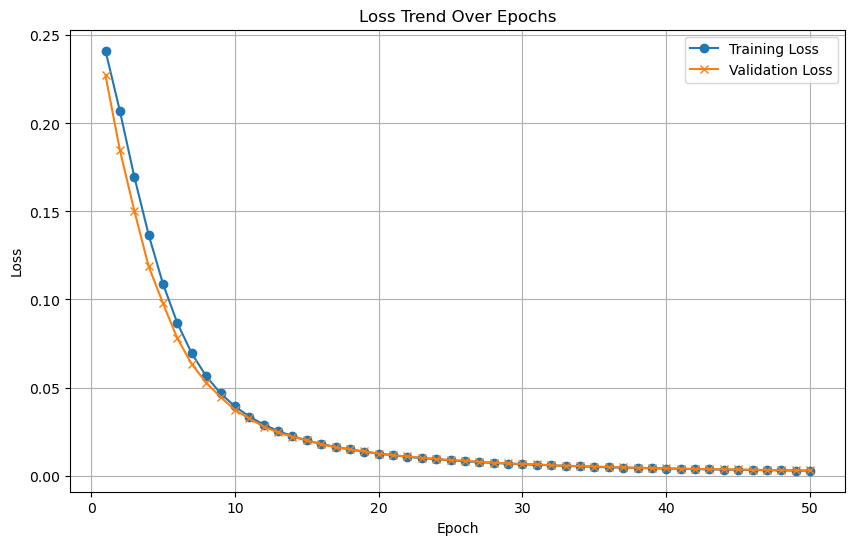

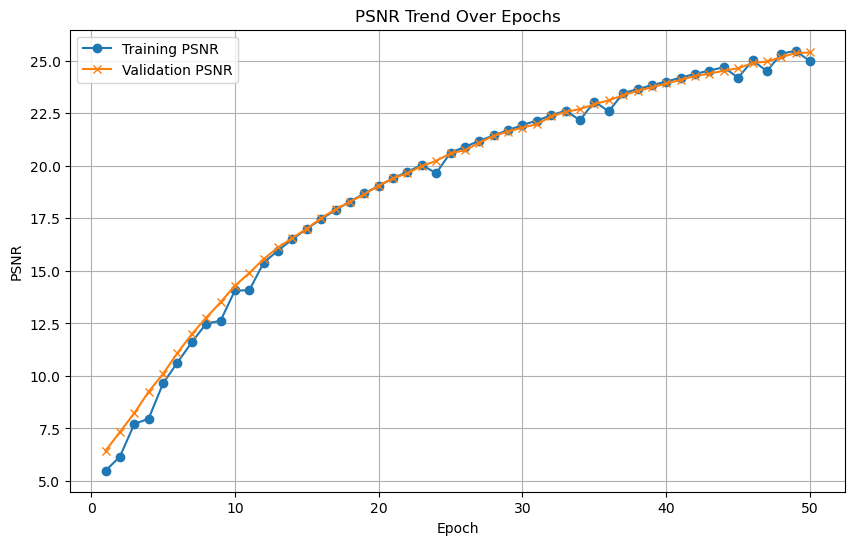

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/20 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.6090
    Validation Batch [1/1], Loss: 2.5702
Validation Loss: 2.5702, Validation Accuracy: 7.69%
Validation loss improved from inf to 2.5702. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.5784
    Validation Batch [1/1], Loss: 2.5701
Validation Loss: 2.5701, Validation Accuracy: 7.69%
Validation loss improved from 2.5702 to 2.5701. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.5729
    Validation Batch [1/1], Loss: 2.5701
Validation Loss: 2.5701, Validation Accuracy: 7.69%
Validation loss improved from 2.5701 to 2.5701. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.5619
    Validation Batch [1/1], Loss: 2.5701
Validation Loss: 2.5701, Validation Accuracy: 7.69%
Validation loss improved from 2.5701 to 2.5701. Saving model...

LOG: Epoch [5/1000] - 

    Validation Batch [1/1], Loss: 2.5711
Validation Loss: 2.5711, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 2.4044
    Validation Batch [1/1], Loss: 2.5713
Validation Loss: 2.5713, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [24/1000] - Training
Epoch [24/1000] completed, Average Training Loss: 2.3971
    Validation Batch [1/1], Loss: 2.5714
Validation Loss: 2.5714, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [25/1000] - Training
Epoch [25/1000] completed, Average Training Loss: 2.4033
    Validation Batch [1/1], Loss: 2.5715
Validation Loss: 2.5715, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [26/1000] - Training
Epoch [26/1000] completed, Average Training Loss: 2.3838
    Validation Batch [1/1], Loss: 2.5716
Validation Loss: 2.5716, Va

    Validation Batch [1/1], Loss: 2.5748
Validation Loss: 2.5748, Validation Accuracy: 9.23%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [50/1000] - Training
Epoch [50/1000] completed, Average Training Loss: 2.2599
    Validation Batch [1/1], Loss: 2.5746
Validation Loss: 2.5746, Validation Accuracy: 12.31%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [51/1000] - Training
Epoch [51/1000] completed, Average Training Loss: 2.1958
    Validation Batch [1/1], Loss: 2.5743
Validation Loss: 2.5743, Validation Accuracy: 13.85%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [52/1000] - Training
Epoch [52/1000] completed, Average Training Loss: 2.2233
    Validation Batch [1/1], Loss: 2.5739
Validation Loss: 2.5739, Validation Accuracy: 13.85%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [53/1000] - Training
Epoch [53/1000] completed, Average Training Loss: 2.2000
    Validation Batch [1/1], Loss: 2.5734
Validation Loss: 2.5734,

Epoch [81/1000] completed, Average Training Loss: 1.9966
    Validation Batch [1/1], Loss: 2.4673
Validation Loss: 2.4673, Validation Accuracy: 15.38%
Validation loss improved from 2.4757 to 2.4673. Saving model...

LOG: Epoch [82/1000] - Training
Epoch [82/1000] completed, Average Training Loss: 2.0413
    Validation Batch [1/1], Loss: 2.4590
Validation Loss: 2.4590, Validation Accuracy: 15.38%
Validation loss improved from 2.4673 to 2.4590. Saving model...

LOG: Epoch [83/1000] - Training
Epoch [83/1000] completed, Average Training Loss: 2.0113
    Validation Batch [1/1], Loss: 2.4496
Validation Loss: 2.4496, Validation Accuracy: 15.38%
Validation loss improved from 2.4590 to 2.4496. Saving model...

LOG: Epoch [84/1000] - Training
Epoch [84/1000] completed, Average Training Loss: 2.0938
    Validation Batch [1/1], Loss: 2.4392
Validation Loss: 2.4392, Validation Accuracy: 15.38%
Validation loss improved from 2.4496 to 2.4392. Saving model...

LOG: Epoch [85/1000] - Training
Epoch [8

Epoch [112/1000] completed, Average Training Loss: 1.8527
    Validation Batch [1/1], Loss: 2.2615
Validation Loss: 2.2615, Validation Accuracy: 35.38%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [113/1000] - Training
Epoch [113/1000] completed, Average Training Loss: 1.7951
    Validation Batch [1/1], Loss: 2.2643
Validation Loss: 2.2643, Validation Accuracy: 35.38%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [114/1000] - Training
Epoch [114/1000] completed, Average Training Loss: 1.7934
    Validation Batch [1/1], Loss: 2.2668
Validation Loss: 2.2668, Validation Accuracy: 36.92%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [115/1000] - Training
Epoch [115/1000] completed, Average Training Loss: 1.8184
    Validation Batch [1/1], Loss: 2.2676
Validation Loss: 2.2676, Validation Accuracy: 36.92%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [116/1000] - Training
Epoch [116/1000] completed, Average Training Loss: 1.7967
  

Epoch [143/1000] completed, Average Training Loss: 1.5967
    Validation Batch [1/1], Loss: 2.2046
Validation Loss: 2.2046, Validation Accuracy: 36.92%
Validation loss improved from 2.2148 to 2.2046. Saving model...

LOG: Epoch [144/1000] - Training
Epoch [144/1000] completed, Average Training Loss: 1.5974
    Validation Batch [1/1], Loss: 2.1988
Validation Loss: 2.1988, Validation Accuracy: 38.46%
Validation loss improved from 2.2046 to 2.1988. Saving model...

LOG: Epoch [145/1000] - Training
Epoch [145/1000] completed, Average Training Loss: 1.5844
    Validation Batch [1/1], Loss: 2.1993
Validation Loss: 2.1993, Validation Accuracy: 36.92%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [146/1000] - Training
Epoch [146/1000] completed, Average Training Loss: 1.5504
    Validation Batch [1/1], Loss: 2.2068
Validation Loss: 2.2068, Validation Accuracy: 38.46%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [147/1000] - Training
Epoch [147/1000] completed, Av

    Validation Batch [1/1], Loss: 2.1696
Validation Loss: 2.1696, Validation Accuracy: 41.54%
Validation loss improved from 2.1785 to 2.1696. Saving model...

LOG: Epoch [175/1000] - Training
Epoch [175/1000] completed, Average Training Loss: 1.3060
    Validation Batch [1/1], Loss: 2.1671
Validation Loss: 2.1671, Validation Accuracy: 41.54%
Validation loss improved from 2.1696 to 2.1671. Saving model...

LOG: Epoch [176/1000] - Training
Epoch [176/1000] completed, Average Training Loss: 1.2854
    Validation Batch [1/1], Loss: 2.1713
Validation Loss: 2.1713, Validation Accuracy: 43.08%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [177/1000] - Training
Epoch [177/1000] completed, Average Training Loss: 1.2867
    Validation Batch [1/1], Loss: 2.1810
Validation Loss: 2.1810, Validation Accuracy: 41.54%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [178/1000] - Training
Epoch [178/1000] completed, Average Training Loss: 1.3253
    Validation Batch [1/1], Lo

Epoch [205/1000] completed, Average Training Loss: 1.0282
    Validation Batch [1/1], Loss: 2.1557
Validation Loss: 2.1557, Validation Accuracy: 46.15%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [206/1000] - Training
Epoch [206/1000] completed, Average Training Loss: 1.0649
    Validation Batch [1/1], Loss: 2.1591
Validation Loss: 2.1591, Validation Accuracy: 46.15%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [207/1000] - Training
Epoch [207/1000] completed, Average Training Loss: 1.0522
    Validation Batch [1/1], Loss: 2.1695
Validation Loss: 2.1695, Validation Accuracy: 46.15%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [208/1000] - Training
Epoch [208/1000] completed, Average Training Loss: 0.9751
    Validation Batch [1/1], Loss: 2.1735
Validation Loss: 2.1735, Validation Accuracy: 46.15%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [209/1000] - Training
Epoch [209/1000] completed, Average Training Loss: 0.974

    Validation Batch [1/1], Loss: 2.1205
Validation Loss: 2.1205, Validation Accuracy: 49.23%
Validation loss improved from 2.1210 to 2.1205. Saving model...

LOG: Epoch [239/1000] - Training
Epoch [239/1000] completed, Average Training Loss: 0.7771
    Validation Batch [1/1], Loss: 2.0807
Validation Loss: 2.0807, Validation Accuracy: 49.23%
Validation loss improved from 2.1205 to 2.0807. Saving model...

LOG: Epoch [240/1000] - Training
Epoch [240/1000] completed, Average Training Loss: 0.7696
    Validation Batch [1/1], Loss: 2.0743
Validation Loss: 2.0743, Validation Accuracy: 50.77%
Validation loss improved from 2.0807 to 2.0743. Saving model...

LOG: Epoch [241/1000] - Training
Epoch [241/1000] completed, Average Training Loss: 0.7770
    Validation Batch [1/1], Loss: 2.0830
Validation Loss: 2.0830, Validation Accuracy: 49.23%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [242/1000] - Training
Epoch [242/1000] completed, Average Training Loss: 0.7397
    Validation 

Epoch [271/1000] completed, Average Training Loss: 0.5895
    Validation Batch [1/1], Loss: 2.1041
Validation Loss: 2.1041, Validation Accuracy: 53.85%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [272/1000] - Training
Epoch [272/1000] completed, Average Training Loss: 0.6033
    Validation Batch [1/1], Loss: 2.0831
Validation Loss: 2.0831, Validation Accuracy: 53.85%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [273/1000] - Training
Epoch [273/1000] completed, Average Training Loss: 0.5199
    Validation Batch [1/1], Loss: 2.0751
Validation Loss: 2.0751, Validation Accuracy: 53.85%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [274/1000] - Training
Epoch [274/1000] completed, Average Training Loss: 0.5687
    Validation Batch [1/1], Loss: 2.0733
Validation Loss: 2.0733, Validation Accuracy: 53.85%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [275/1000] - Training
Epoch [275/1000] completed, Average Training Loss: 0.5291
  

    Validation Batch [1/1], Loss: 2.0475
Validation Loss: 2.0475, Validation Accuracy: 56.92%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [302/1000] - Training
Epoch [302/1000] completed, Average Training Loss: 0.4021
    Validation Batch [1/1], Loss: 2.0553
Validation Loss: 2.0553, Validation Accuracy: 55.38%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [303/1000] - Training
Epoch [303/1000] completed, Average Training Loss: 0.4135
    Validation Batch [1/1], Loss: 2.0737
Validation Loss: 2.0737, Validation Accuracy: 55.38%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [304/1000] - Training
Epoch [304/1000] completed, Average Training Loss: 0.3963
    Validation Batch [1/1], Loss: 2.0727
Validation Loss: 2.0727, Validation Accuracy: 55.38%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [305/1000] - Training
Epoch [305/1000] completed, Average Training Loss: 0.4611
    Validation Batch [1/1], Loss: 2.0666
Validation Loss

Epoch [332/1000] completed, Average Training Loss: 0.3063
    Validation Batch [1/1], Loss: 2.1150
Validation Loss: 2.1150, Validation Accuracy: 52.31%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [333/1000] - Training
Epoch [333/1000] completed, Average Training Loss: 0.2830
    Validation Batch [1/1], Loss: 2.1139
Validation Loss: 2.1139, Validation Accuracy: 53.85%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [334/1000] - Training
Epoch [334/1000] completed, Average Training Loss: 0.2875
    Validation Batch [1/1], Loss: 2.1142
Validation Loss: 2.1142, Validation Accuracy: 53.85%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [335/1000] - Training
Epoch [335/1000] completed, Average Training Loss: 0.2759
    Validation Batch [1/1], Loss: 2.1128
Validation Loss: 2.1128, Validation Accuracy: 53.85%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [336/1000] - Training
Epoch [336/1000] completed, Average Training Loss: 0.333

Epoch [362/1000] completed, Average Training Loss: 0.2188
    Validation Batch [1/1], Loss: 2.1789
Validation Loss: 2.1789, Validation Accuracy: 55.38%
Validation loss did not improve. Patience: 83/100

LOG: Epoch [363/1000] - Training
Epoch [363/1000] completed, Average Training Loss: 0.2322
    Validation Batch [1/1], Loss: 2.1913
Validation Loss: 2.1913, Validation Accuracy: 55.38%
Validation loss did not improve. Patience: 84/100

LOG: Epoch [364/1000] - Training
Epoch [364/1000] completed, Average Training Loss: 0.2255
    Validation Batch [1/1], Loss: 2.2115
Validation Loss: 2.2115, Validation Accuracy: 55.38%
Validation loss did not improve. Patience: 85/100

LOG: Epoch [365/1000] - Training
Epoch [365/1000] completed, Average Training Loss: 0.2438
    Validation Batch [1/1], Loss: 2.2307
Validation Loss: 2.2307, Validation Accuracy: 55.38%
Validation loss did not improve. Patience: 86/100

LOG: Epoch [366/1000] - Training
Epoch [366/1000] completed, Average Training Loss: 0.225

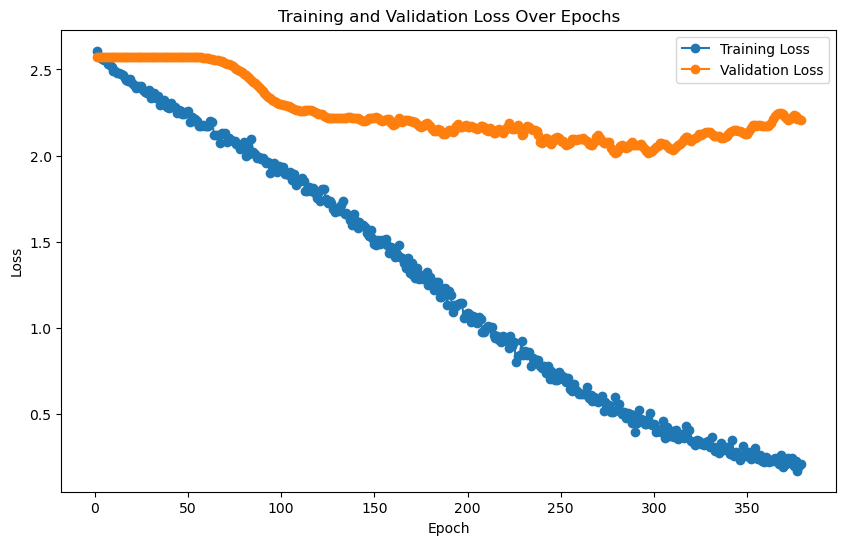

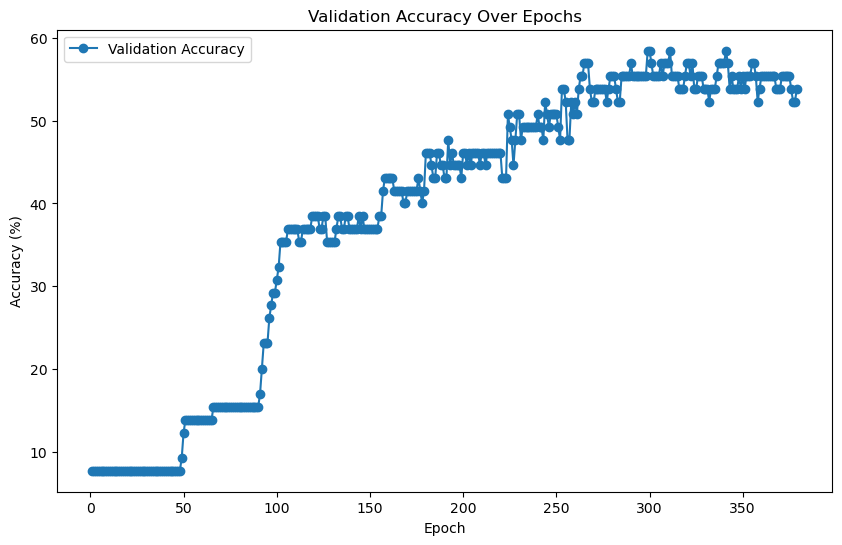


Evaluating on the test set...
    Test Batch [1/20], Loss: 1.5876

Final Test Loss: 1.4264, Test Accuracy: 63.45%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/20 for test dataset.
  Processed batch 20/20 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 5081 samples with 64 features each
LOG: Labels shape: (5081,)

LOG: Training features shape: (65, 64), Training labels shape: (65,)
LOG: Validation features shape: (65, 64), Validation labels shape: (65,)
LOG: Test features shape: (5081, 64), Test labels shape: (5081,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 33.85%

Validation Classification Report:
               precision    recall  f1-sco

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 5081 samples with 64 features each
LOG: Labels shape: (5081,)
Train reps shape: (65, 64)
Train labels shape: (65,)
Val reps shape: (65, 64)
Val labels shape: (65,)
Test reps shape: (5081, 64)
Test labels shape: (5081,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8571  |  Val Loss: 2.8459
Validation loss improved from inf to 2.8459.
[Epoch 2/1000] Train Loss: 2.7207  |  Val Loss: 2.7452
Validation loss improved from 2.8459 to 2.7452.
[Epoch 3/1000] Train Loss: 2.6579  |  Val Loss: 2.6881
Validation loss improved from 2.7452 to 2.6881.
[Epoch 4/1000] Train Loss: 2.6300  |  Val Loss: 2.6429
Validation loss improved from 2.6881 to 2.6429.
[Epoch 5/1000] Train Loss: 2.6114  |  Val Loss: 2.6049
Validation loss improved from 2.6429 to 2.6049.
[Epoch 6/1000] Train Loss: 2.5933  |  Val Loss: 2.5785
Validation loss improved from 2.6049 to 2.5785.
[Epoch 7/1000] Train Loss: 2.5803  |  Val Loss: 2.5630
Validation loss improved from 2.5785 to 2.5630.
[Epoch 8/1000] Train Loss: 2.5712  |  Val Loss: 2.5541
Validation loss improved from 2.5630 to 2.5541.
[Epoch 9/1000] Train Loss: 2.5651  |  Val Loss: 2.5507
Validation loss improved from 2.5541 to 2.5507.
[Epoch 10/1000] Train Loss: 2.5617  |  Val Loss: 2.5507
!! Validation loss d

[Epoch 30/1000] Train Loss: 2.4013  |  Val Loss: 2.4494
Validation loss improved from 2.4499 to 2.4494.
[Epoch 31/1000] Train Loss: 2.3936  |  Val Loss: 2.4572
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 32/1000] Train Loss: 2.3912  |  Val Loss: 2.4659
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 33/1000] Train Loss: 2.3909  |  Val Loss: 2.4719
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 34/1000] Train Loss: 2.3900  |  Val Loss: 2.4643
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 35/1000] Train Loss: 2.3832  |  Val Loss: 2.4484
Validation loss improved from 2.4494 to 2.4484.
[Epoch 36/1000] Train Loss: 2.3747  |  Val Loss: 2.4371
Validation loss improved from 2.4484 to 2.4371.
[Epoch 37/1000] Train Loss: 2.3709  |  Val Loss: 2.4334
Validation loss improved from 2.4371 to 2.4334.
[Epoch 38/1000] Train Loss: 2.3680  |  Val Loss: 2.4344
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 39/1000] Train Loss: 2.3650

[Epoch 43/1000] Train Loss: 2.3556  |  Val Loss: 2.4426
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 44/1000] Train Loss: 2.3550  |  Val Loss: 2.4525
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 45/1000] Train Loss: 2.3588  |  Val Loss: 2.4618
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 46/1000] Train Loss: 2.3636  |  Val Loss: 2.4727
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 47/1000] Train Loss: 2.3708  |  Val Loss: 2.4804
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 48/1000] Train Loss: 2.3765  |  Val Loss: 2.4812
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 49/1000] Train Loss: 2.3755  |  Val Loss: 2.4795
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 50/1000] Train Loss: 2.3736  |  Val Loss: 2.4788
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 51/1000] Train Loss: 2.3728  |  Val Loss: 2.4789
!! Validation loss did NOT improve !! Patience: 14/100
[Epoc

[Epoch 74/1000] Train Loss: 2.3347  |  Val Loss: 2.4560
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 75/1000] Train Loss: 2.3272  |  Val Loss: 2.4366
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 76/1000] Train Loss: 2.3153  |  Val Loss: 2.4259
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 77/1000] Train Loss: 2.3087  |  Val Loss: 2.4210
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 78/1000] Train Loss: 2.3048  |  Val Loss: 2.4181
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 79/1000] Train Loss: 2.3037  |  Val Loss: 2.4162
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 80/1000] Train Loss: 2.3026  |  Val Loss: 2.4070
Validation loss improved from 2.4122 to 2.4070.
[Epoch 81/1000] Train Loss: 2.3025  |  Val Loss: 2.4006
Validation loss improved from 2.4070 to 2.4006.
[Epoch 82/1000] Train Loss: 2.3088  |  Val Loss: 2.4042
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 83/1000] Trai

[Epoch 90/1000] Train Loss: 2.3165  |  Val Loss: 2.4909
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 91/1000] Train Loss: 2.3253  |  Val Loss: 2.4992
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 92/1000] Train Loss: 2.3318  |  Val Loss: 2.5021
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 93/1000] Train Loss: 2.3356  |  Val Loss: 2.5003
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 94/1000] Train Loss: 2.3350  |  Val Loss: 2.4933
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 95/1000] Train Loss: 2.3286  |  Val Loss: 2.4729
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 96/1000] Train Loss: 2.3117  |  Val Loss: 2.4442
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 97/1000] Train Loss: 2.2923  |  Val Loss: 2.4228
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 98/1000] Train Loss: 2.2817  |  Val Loss: 2.4101
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch

[Epoch 119/1000] Train Loss: 2.2965  |  Val Loss: 2.4373
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 120/1000] Train Loss: 2.2969  |  Val Loss: 2.4499
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 121/1000] Train Loss: 2.3028  |  Val Loss: 2.4576
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 122/1000] Train Loss: 2.3039  |  Val Loss: 2.4489
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 123/1000] Train Loss: 2.3013  |  Val Loss: 2.4399
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 124/1000] Train Loss: 2.3000  |  Val Loss: 2.4227
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 125/1000] Train Loss: 2.2951  |  Val Loss: 2.4025
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 126/1000] Train Loss: 2.2956  |  Val Loss: 2.3927
Validation loss improved from 2.3937 to 2.3927.
[Epoch 127/1000] Train Loss: 2.3070  |  Val Loss: 2.3963
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 133/1000] Train Loss: 2.3615  |  Val Loss: 2.4159
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 134/1000] Train Loss: 2.3546  |  Val Loss: 2.4128
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 135/1000] Train Loss: 2.3476  |  Val Loss: 2.4073
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 136/1000] Train Loss: 2.3384  |  Val Loss: 2.4009
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 137/1000] Train Loss: 2.3251  |  Val Loss: 2.3960
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 138/1000] Train Loss: 2.2961  |  Val Loss: 2.4153
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 139/1000] Train Loss: 2.2788  |  Val Loss: 2.4456
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 140/1000] Train Loss: 2.2843  |  Val Loss: 2.4756
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 141/1000] Train Loss: 2.2987  |  Val Loss: 2.5005
!! Validation loss did NOT improve !! Patience: 15

[Epoch 160/1000] Train Loss: 2.2821  |  Val Loss: 2.3745
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 161/1000] Train Loss: 2.2759  |  Val Loss: 2.3764
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 162/1000] Train Loss: 2.2699  |  Val Loss: 2.3785
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 163/1000] Train Loss: 2.2649  |  Val Loss: 2.3828
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 164/1000] Train Loss: 2.2623  |  Val Loss: 2.3880
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 165/1000] Train Loss: 2.2589  |  Val Loss: 2.3952
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 166/1000] Train Loss: 2.2595  |  Val Loss: 2.4021
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 167/1000] Train Loss: 2.2593  |  Val Loss: 2.4049
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 168/1000] Train Loss: 2.2559  |  Val Loss: 2.4070
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 178/1000] Train Loss: 2.2621  |  Val Loss: 2.3992
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 179/1000] Train Loss: 2.2660  |  Val Loss: 2.3969
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 180/1000] Train Loss: 2.2680  |  Val Loss: 2.3934
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 181/1000] Train Loss: 2.2680  |  Val Loss: 2.3912
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 182/1000] Train Loss: 2.2661  |  Val Loss: 2.3896
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 183/1000] Train Loss: 2.2639  |  Val Loss: 2.3894
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 184/1000] Train Loss: 2.2610  |  Val Loss: 2.3906
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 185/1000] Train Loss: 2.2588  |  Val Loss: 2.3920
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 186/1000] Train Loss: 2.2563  |  Val Loss: 2.3948
!! Validation loss did NOT improve !! Patience:

[Epoch 198/1000] Train Loss: 2.2654  |  Val Loss: 2.4515
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 199/1000] Train Loss: 2.2714  |  Val Loss: 2.4590
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 200/1000] Train Loss: 2.2773  |  Val Loss: 2.4648
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 201/1000] Train Loss: 2.2829  |  Val Loss: 2.4561
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 202/1000] Train Loss: 2.2775  |  Val Loss: 2.4367
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 203/1000] Train Loss: 2.2685  |  Val Loss: 2.4208
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 204/1000] Train Loss: 2.2633  |  Val Loss: 2.4065
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 205/1000] Train Loss: 2.2589  |  Val Loss: 2.3956
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 206/1000] Train Loss: 2.2596  |  Val Loss: 2.3884
!! Validation loss did NOT improve !! Patience:

[Epoch 213/1000] Train Loss: 2.2689  |  Val Loss: 2.3956
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 214/1000] Train Loss: 2.2640  |  Val Loss: 2.3991
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 215/1000] Train Loss: 2.2591  |  Val Loss: 2.4024
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 216/1000] Train Loss: 2.2530  |  Val Loss: 2.4069
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 217/1000] Train Loss: 2.2484  |  Val Loss: 2.4123
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 218/1000] Train Loss: 2.2456  |  Val Loss: 2.4166
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 219/1000] Train Loss: 2.2425  |  Val Loss: 2.4202
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 220/1000] Train Loss: 2.2403  |  Val Loss: 2.4227
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 221/1000] Train Loss: 2.2380  |  Val Loss: 2.4237
!! Validation loss did NOT improve !! Patience:

[Epoch 241/1000] Train Loss: 2.2611  |  Val Loss: 2.4683
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 242/1000] Train Loss: 2.2467  |  Val Loss: 2.4308
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 243/1000] Train Loss: 2.2305  |  Val Loss: 2.4057
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 244/1000] Train Loss: 2.2271  |  Val Loss: 2.3900
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 245/1000] Train Loss: 2.2298  |  Val Loss: 2.3798
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 246/1000] Train Loss: 2.2357  |  Val Loss: 2.3736
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 247/1000] Train Loss: 2.2424  |  Val Loss: 2.3703
Validation loss improved from 2.3730 to 2.3703.
[Epoch 248/1000] Train Loss: 2.2470  |  Val Loss: 2.3684
Validation loss improved from 2.3703 to 2.3684.
[Epoch 249/1000] Train Loss: 2.2490  |  Val Loss: 2.3678
Validation loss improved from 2.3684 to 2.3678.
[Epoch 250/10

[Epoch 255/1000] Train Loss: 2.2285  |  Val Loss: 2.3799
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 256/1000] Train Loss: 2.2239  |  Val Loss: 2.3854
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 257/1000] Train Loss: 2.2221  |  Val Loss: 2.3908
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 258/1000] Train Loss: 2.2210  |  Val Loss: 2.3965
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 259/1000] Train Loss: 2.2201  |  Val Loss: 2.4034
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 260/1000] Train Loss: 2.2217  |  Val Loss: 2.4115
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 261/1000] Train Loss: 2.2259  |  Val Loss: 2.4191
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 262/1000] Train Loss: 2.2301  |  Val Loss: 2.4236
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 263/1000] Train Loss: 2.2318  |  Val Loss: 2.4343
!! Validation loss did NOT improve !! Patience: 14/

[Epoch 281/1000] Train Loss: 2.3253  |  Val Loss: 2.4428
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 282/1000] Train Loss: 2.3278  |  Val Loss: 2.4406
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 283/1000] Train Loss: 2.3210  |  Val Loss: 2.4350
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 284/1000] Train Loss: 2.3080  |  Val Loss: 2.4308
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 285/1000] Train Loss: 2.2927  |  Val Loss: 2.4271
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 286/1000] Train Loss: 2.2766  |  Val Loss: 2.4236
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 287/1000] Train Loss: 2.2589  |  Val Loss: 2.4230
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 288/1000] Train Loss: 2.2438  |  Val Loss: 2.4304
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 289/1000] Train Loss: 2.2321  |  Val Loss: 2.4488
!! Validation loss did NOT improve !! Patience:

[Epoch 300/1000] Train Loss: 2.2410  |  Val Loss: 2.4755
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 301/1000] Train Loss: 2.2288  |  Val Loss: 2.4571
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 302/1000] Train Loss: 2.2188  |  Val Loss: 2.4390
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 303/1000] Train Loss: 2.2097  |  Val Loss: 2.4223
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 304/1000] Train Loss: 2.2044  |  Val Loss: 2.4111
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 305/1000] Train Loss: 2.2027  |  Val Loss: 2.4035
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 306/1000] Train Loss: 2.2047  |  Val Loss: 2.4004
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 307/1000] Train Loss: 2.2090  |  Val Loss: 2.4001
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 308/1000] Train Loss: 2.2132  |  Val Loss: 2.4020
!! Validation loss did NOT improve !! Patience:

[Epoch 329/1000] Train Loss: 2.2274  |  Val Loss: 2.4500
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 330/1000] Train Loss: 2.2244  |  Val Loss: 2.4485
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 331/1000] Train Loss: 2.2233  |  Val Loss: 2.4452
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 332/1000] Train Loss: 2.2251  |  Val Loss: 2.4409
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 333/1000] Train Loss: 2.2245  |  Val Loss: 2.4377
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 334/1000] Train Loss: 2.2213  |  Val Loss: 2.4367
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 335/1000] Train Loss: 2.2178  |  Val Loss: 2.4363
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 336/1000] Train Loss: 2.2158  |  Val Loss: 2.4384
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 337/1000] Train Loss: 2.2203  |  Val Loss: 2.4441
!! Validation loss did NOT improve !! Patience:

[Epoch 342/1000] Train Loss: 2.2419  |  Val Loss: 2.4567
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 343/1000] Train Loss: 2.2423  |  Val Loss: 2.4583
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 344/1000] Train Loss: 2.2420  |  Val Loss: 2.4602
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 345/1000] Train Loss: 2.2427  |  Val Loss: 2.4597
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 346/1000] Train Loss: 2.2394  |  Val Loss: 2.4566
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 347/1000] Train Loss: 2.2325  |  Val Loss: 2.4531
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 348/1000] Train Loss: 2.2253  |  Val Loss: 2.4501
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 349/1000] Train Loss: 2.2187  |  Val Loss: 2.4488
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 349 !!
No improvement for 100 epochs.


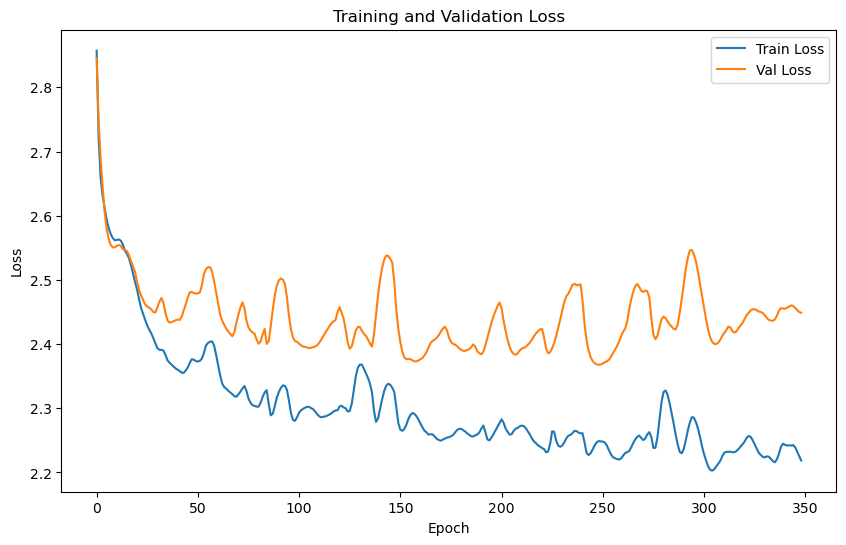

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 2.6864 | Test Accuracy: 7.79%


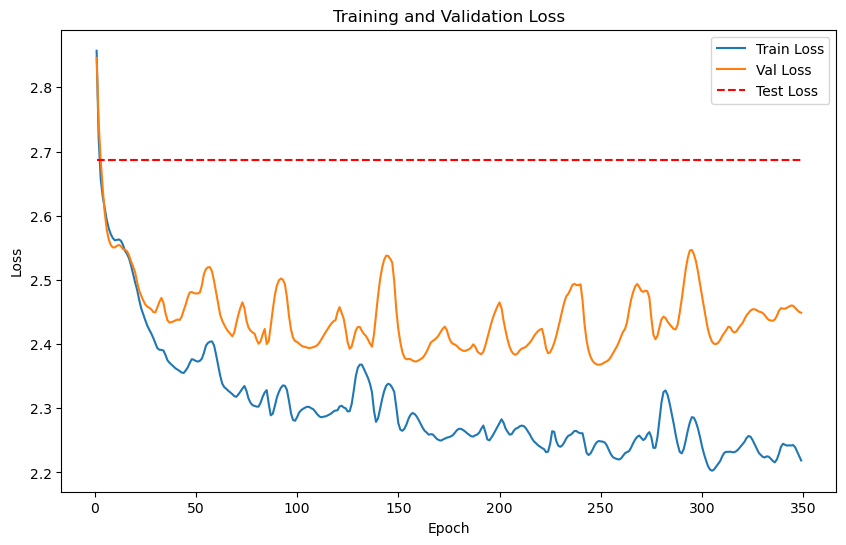

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 5081 samples with 64 features each
LOG: Labels shape: (5081,)


Train embeddings shape: (65, 64), 
Train labels shape: (65,)


Val embeddings shape: (65, 64), 
Val labels shape: (65,)


Test embeddings shape: (5081, 64), 
Test labels shape: (5081,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5}
Training batch size: 65


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 7.6005
Epoch [1/2000], Avg Train Loss: 7.6005
Epoch [1/2000], Avg Val Loss: 6.0488
Validation loss improved from inf to 6.0488. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 7.2725
Epoch [2/2000], Avg Train Loss: 7.2725
Epoch [2/2000], Avg Val Loss: 6.0200
Validation loss improved from 6.0488 to 6.0200. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 7.7076
Epoch [3/2000], Avg Train Loss: 7.7076
Epoch [3/2000], Avg Val Loss: 5.9912
Validation loss improved from 6.0200 to 5.9912. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 7.5271
Epoch [4/2000], Avg Train Loss: 7.5271
Epoch [4/2000], Avg Val Loss: 5.9635
Validation loss improved from 5.9912 to 5.9635. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 7.4121
Epoch [5/2000], Avg Train Loss: 7.4121
Epoch [5/2000], Avg Val Loss: 5.9362
Validation loss improved from 5.9635 to 5.9362. Saving mode

Epoch [16/2000], Avg Val Loss: 5.6347
Validation loss improved from 5.6625 to 5.6347. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 6.7625
Epoch [17/2000], Avg Train Loss: 6.7625
Epoch [17/2000], Avg Val Loss: 5.6072
Validation loss improved from 5.6347 to 5.6072. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 6.6096
Epoch [18/2000], Avg Train Loss: 6.6096
Epoch [18/2000], Avg Val Loss: 5.5792
Validation loss improved from 5.6072 to 5.5792. Saving model...

LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 6.7127
Epoch [19/2000], Avg Train Loss: 6.7127
Epoch [19/2000], Avg Val Loss: 5.5512
Validation loss improved from 5.5792 to 5.5512. Saving model...

LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 6.7815
Epoch [20/2000], Avg Train Loss: 6.7815
Epoch [20/2000], Avg Val Loss: 5.5234
Validation loss improved from 5.5512 to 5.5234. Saving model...

LOG: Epoch [21/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 6.5852
Epoch [22/2000], Avg Train Loss: 6.5852
Epoch [22/2000], Avg Val Loss: 5.4671
Validation loss improved from 5.4953 to 5.4671. Saving model...

LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 6.4926
Epoch [23/2000], Avg Train Loss: 6.4926
Epoch [23/2000], Avg Val Loss: 5.4392
Validation loss improved from 5.4671 to 5.4392. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 6.4065
Epoch [24/2000], Avg Train Loss: 6.4065
Epoch [24/2000], Avg Val Loss: 5.4117
Validation loss improved from 5.4392 to 5.4117. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 6.5146
Epoch [25/2000], Avg Train Loss: 6.5146
Epoch [25/2000], Avg Val Loss: 5.3845
Validation loss improved from 5.4117 to 5.3845. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 6.1831
Epoch [26/2000], Avg Train Loss: 6.1831
Epoch [26/2000], Avg Val Loss: 5.3575
Validation loss improved from 5.3845 to 5.

    Batch [1/1], Train Loss: 5.9614
Epoch [39/2000], Avg Train Loss: 5.9614
Epoch [39/2000], Avg Val Loss: 5.0161
Validation loss improved from 5.0415 to 5.0161. Saving model...

LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 5.7367
Epoch [40/2000], Avg Train Loss: 5.7367
Epoch [40/2000], Avg Val Loss: 4.9907
Validation loss improved from 5.0161 to 4.9907. Saving model...

LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 5.7180
Epoch [41/2000], Avg Train Loss: 5.7180
Epoch [41/2000], Avg Val Loss: 4.9656
Validation loss improved from 4.9907 to 4.9656. Saving model...

LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 5.6016
Epoch [42/2000], Avg Train Loss: 5.6016
Epoch [42/2000], Avg Val Loss: 4.9408
Validation loss improved from 4.9656 to 4.9408. Saving model...

LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 5.5218
Epoch [43/2000], Avg Train Loss: 5.5218
Epoch [43/2000], Avg Val Loss: 4.9161
Validation loss improved from 4.9408 to 4.

Epoch [59/2000], Avg Val Loss: 4.5690
Validation loss improved from 4.5883 to 4.5690. Saving model...

LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 5.3738
Epoch [60/2000], Avg Train Loss: 5.3738
Epoch [60/2000], Avg Val Loss: 4.5503
Validation loss improved from 4.5690 to 4.5503. Saving model...

LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 5.3033
Epoch [61/2000], Avg Train Loss: 5.3033
Epoch [61/2000], Avg Val Loss: 4.5319
Validation loss improved from 4.5503 to 4.5319. Saving model...

LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 5.1181
Epoch [62/2000], Avg Train Loss: 5.1181
Epoch [62/2000], Avg Val Loss: 4.5138
Validation loss improved from 4.5319 to 4.5138. Saving model...

LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 5.1535
Epoch [63/2000], Avg Train Loss: 5.1535
Epoch [63/2000], Avg Val Loss: 4.4962
Validation loss improved from 4.5138 to 4.4962. Saving model...

LOG: Epoch [64/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.2291
Epoch [69/2000], Avg Train Loss: 5.2291
Epoch [69/2000], Avg Val Loss: 4.4001
Validation loss improved from 4.4147 to 4.4001. Saving model...

LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 5.0158
Epoch [70/2000], Avg Train Loss: 5.0158
Epoch [70/2000], Avg Val Loss: 4.3858
Validation loss improved from 4.4001 to 4.3858. Saving model...

LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 5.0333
Epoch [71/2000], Avg Train Loss: 5.0333
Epoch [71/2000], Avg Val Loss: 4.3717
Validation loss improved from 4.3858 to 4.3717. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 5.0186
Epoch [72/2000], Avg Train Loss: 5.0186
Epoch [72/2000], Avg Val Loss: 4.3581
Validation loss improved from 4.3717 to 4.3581. Saving model...

LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 5.0271
Epoch [73/2000], Avg Train Loss: 5.0271
Epoch [73/2000], Avg Val Loss: 4.3448
Validation loss improved from 4.3581 to 4.

    Batch [1/1], Train Loss: 4.6000
Epoch [90/2000], Avg Train Loss: 4.6000
Epoch [90/2000], Avg Val Loss: 4.1668
Validation loss improved from 4.1749 to 4.1668. Saving model...

LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 4.6365
Epoch [91/2000], Avg Train Loss: 4.6365
Epoch [91/2000], Avg Val Loss: 4.1589
Validation loss improved from 4.1668 to 4.1589. Saving model...

LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 4.6362
Epoch [92/2000], Avg Train Loss: 4.6362
Epoch [92/2000], Avg Val Loss: 4.1513
Validation loss improved from 4.1589 to 4.1513. Saving model...

LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 4.6769
Epoch [93/2000], Avg Train Loss: 4.6769
Epoch [93/2000], Avg Val Loss: 4.1439
Validation loss improved from 4.1513 to 4.1439. Saving model...

LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 4.5646
Epoch [94/2000], Avg Train Loss: 4.5646
Epoch [94/2000], Avg Val Loss: 4.1368
Validation loss improved from 4.1439 to 4.

    Batch [1/1], Train Loss: 4.5253
Epoch [106/2000], Avg Train Loss: 4.5253
Epoch [106/2000], Avg Val Loss: 4.0681
Validation loss improved from 4.0727 to 4.0681. Saving model...

LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 4.4863
Epoch [107/2000], Avg Train Loss: 4.4863
Epoch [107/2000], Avg Val Loss: 4.0636
Validation loss improved from 4.0681 to 4.0636. Saving model...

LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 4.5584
Epoch [108/2000], Avg Train Loss: 4.5584
Epoch [108/2000], Avg Val Loss: 4.0593
Validation loss improved from 4.0636 to 4.0593. Saving model...

LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 4.4676
Epoch [109/2000], Avg Train Loss: 4.4676
Epoch [109/2000], Avg Val Loss: 4.0550
Validation loss improved from 4.0593 to 4.0550. Saving model...

LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 4.4471
Epoch [110/2000], Avg Train Loss: 4.4471
Epoch [110/2000], Avg Val Loss: 4.0509
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5032
Epoch [114/2000], Avg Train Loss: 4.5032
Epoch [114/2000], Avg Val Loss: 4.0355
Validation loss improved from 4.0392 to 4.0355. Saving model...

LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 4.4805
Epoch [115/2000], Avg Train Loss: 4.4805
Epoch [115/2000], Avg Val Loss: 4.0319
Validation loss improved from 4.0355 to 4.0319. Saving model...

LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 4.4804
Epoch [116/2000], Avg Train Loss: 4.4804
Epoch [116/2000], Avg Val Loss: 4.0282
Validation loss improved from 4.0319 to 4.0282. Saving model...

LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 4.4264
Epoch [117/2000], Avg Train Loss: 4.4264
Epoch [117/2000], Avg Val Loss: 4.0248
Validation loss improved from 4.0282 to 4.0248. Saving model...

LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 4.4349
Epoch [118/2000], Avg Train Loss: 4.4349
Epoch [118/2000], Avg Val Loss: 4.0214
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4419
Epoch [129/2000], Avg Train Loss: 4.4419
Epoch [129/2000], Avg Val Loss: 3.9860
Validation loss improved from 3.9889 to 3.9860. Saving model...

LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 4.3668
Epoch [130/2000], Avg Train Loss: 4.3668
Epoch [130/2000], Avg Val Loss: 3.9831
Validation loss improved from 3.9860 to 3.9831. Saving model...

LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 4.3592
Epoch [131/2000], Avg Train Loss: 4.3592
Epoch [131/2000], Avg Val Loss: 3.9802
Validation loss improved from 3.9831 to 3.9802. Saving model...

LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 4.2765
Epoch [132/2000], Avg Train Loss: 4.2765
Epoch [132/2000], Avg Val Loss: 3.9774
Validation loss improved from 3.9802 to 3.9774. Saving model...

LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 4.3589
Epoch [133/2000], Avg Train Loss: 4.3589
Epoch [133/2000], Avg Val Loss: 3.9746
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1444
Epoch [152/2000], Avg Train Loss: 4.1444
Epoch [152/2000], Avg Val Loss: 3.9280
Validation loss improved from 3.9303 to 3.9280. Saving model...

LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 4.2396
Epoch [153/2000], Avg Train Loss: 4.2396
Epoch [153/2000], Avg Val Loss: 3.9256
Validation loss improved from 3.9280 to 3.9256. Saving model...

LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 4.1714
Epoch [154/2000], Avg Train Loss: 4.1714
Epoch [154/2000], Avg Val Loss: 3.9232
Validation loss improved from 3.9256 to 3.9232. Saving model...

LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 4.2025
Epoch [155/2000], Avg Train Loss: 4.2025
Epoch [155/2000], Avg Val Loss: 3.9209
Validation loss improved from 3.9232 to 3.9209. Saving model...

LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 4.1539
Epoch [156/2000], Avg Train Loss: 4.1539
Epoch [156/2000], Avg Val Loss: 3.9187
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1052
Epoch [159/2000], Avg Train Loss: 4.1052
Epoch [159/2000], Avg Val Loss: 3.9121
Validation loss improved from 3.9142 to 3.9121. Saving model...

LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 4.1257
Epoch [160/2000], Avg Train Loss: 4.1257
Epoch [160/2000], Avg Val Loss: 3.9099
Validation loss improved from 3.9121 to 3.9099. Saving model...

LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 4.2320
Epoch [161/2000], Avg Train Loss: 4.2320
Epoch [161/2000], Avg Val Loss: 3.9077
Validation loss improved from 3.9099 to 3.9077. Saving model...

LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 4.0904
Epoch [162/2000], Avg Train Loss: 4.0904
Epoch [162/2000], Avg Val Loss: 3.9055
Validation loss improved from 3.9077 to 3.9055. Saving model...

LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 4.1357
Epoch [163/2000], Avg Train Loss: 4.1357
Epoch [163/2000], Avg Val Loss: 3.9033
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0911
Epoch [180/2000], Avg Train Loss: 4.0911
Epoch [180/2000], Avg Val Loss: 3.8664
Validation loss improved from 3.8685 to 3.8664. Saving model...

LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 4.1135
Epoch [181/2000], Avg Train Loss: 4.1135
Epoch [181/2000], Avg Val Loss: 3.8642
Validation loss improved from 3.8664 to 3.8642. Saving model...

LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 4.0817
Epoch [182/2000], Avg Train Loss: 4.0817
Epoch [182/2000], Avg Val Loss: 3.8620
Validation loss improved from 3.8642 to 3.8620. Saving model...

LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 4.1098
Epoch [183/2000], Avg Train Loss: 4.1098
Epoch [183/2000], Avg Val Loss: 3.8598
Validation loss improved from 3.8620 to 3.8598. Saving model...

LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 4.0206
Epoch [184/2000], Avg Train Loss: 4.0206
Epoch [184/2000], Avg Val Loss: 3.8576
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0102
Epoch [197/2000], Avg Train Loss: 4.0102
Epoch [197/2000], Avg Val Loss: 3.8308
Validation loss improved from 3.8327 to 3.8308. Saving model...

LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 3.9857
Epoch [198/2000], Avg Train Loss: 3.9857
Epoch [198/2000], Avg Val Loss: 3.8289
Validation loss improved from 3.8308 to 3.8289. Saving model...

LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 4.0040
Epoch [199/2000], Avg Train Loss: 4.0040
Epoch [199/2000], Avg Val Loss: 3.8269
Validation loss improved from 3.8289 to 3.8269. Saving model...

LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 3.9945
Epoch [200/2000], Avg Train Loss: 3.9945
Epoch [200/2000], Avg Val Loss: 3.8248
Validation loss improved from 3.8269 to 3.8248. Saving model...

LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 4.0239
Epoch [201/2000], Avg Train Loss: 4.0239
Epoch [201/2000], Avg Val Loss: 3.8227
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9183
Epoch [225/2000], Avg Train Loss: 3.9183
Epoch [225/2000], Avg Val Loss: 3.7882
Validation loss improved from 3.7889 to 3.7882. Saving model...

LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 3.9396
Epoch [226/2000], Avg Train Loss: 3.9396
Epoch [226/2000], Avg Val Loss: 3.7875
Validation loss improved from 3.7882 to 3.7875. Saving model...

LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 3.8292
Epoch [227/2000], Avg Train Loss: 3.8292
Epoch [227/2000], Avg Val Loss: 3.7868
Validation loss improved from 3.7875 to 3.7868. Saving model...

LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 3.8411
Epoch [228/2000], Avg Train Loss: 3.8411
Epoch [228/2000], Avg Val Loss: 3.7862
Validation loss improved from 3.7868 to 3.7862. Saving model...

LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 3.8955
Epoch [229/2000], Avg Train Loss: 3.8955
Epoch [229/2000], Avg Val Loss: 3.7857
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8542
Epoch [247/2000], Avg Train Loss: 3.8542
Epoch [247/2000], Avg Val Loss: 3.7817
Validation loss did not improve. Patience: 1/100

LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 3.8137
Epoch [248/2000], Avg Train Loss: 3.8137
Epoch [248/2000], Avg Val Loss: 3.7818
Validation loss did not improve. Patience: 2/100

LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 3.8478
Epoch [249/2000], Avg Train Loss: 3.8478
Epoch [249/2000], Avg Val Loss: 3.7819
Validation loss did not improve. Patience: 3/100

LOG: Epoch [250/2000] - Training
    Batch [1/1], Train Loss: 3.9223
Epoch [250/2000], Avg Train Loss: 3.9223
Epoch [250/2000], Avg Val Loss: 3.7817
Validation loss did not improve. Patience: 4/100

LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 3.8870
Epoch [251/2000], Avg Train Loss: 3.8870
Epoch [251/2000], Avg Val Loss: 3.7815
Validation loss improved from 3.7817 to 3.7815. Saving model...

LOG: Epoch [252/2000] -

    Batch [1/1], Train Loss: 3.7297
Epoch [277/2000], Avg Train Loss: 3.7297
Epoch [277/2000], Avg Val Loss: 3.7797
Validation loss did not improve. Patience: 11/100

LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 3.7314
Epoch [278/2000], Avg Train Loss: 3.7314
Epoch [278/2000], Avg Val Loss: 3.7797
Validation loss did not improve. Patience: 12/100

LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 3.7356
Epoch [279/2000], Avg Train Loss: 3.7356
Epoch [279/2000], Avg Val Loss: 3.7797
Validation loss did not improve. Patience: 13/100

LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 3.7150
Epoch [280/2000], Avg Train Loss: 3.7150
Epoch [280/2000], Avg Val Loss: 3.7798
Validation loss did not improve. Patience: 14/100

LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 3.8050
Epoch [281/2000], Avg Train Loss: 3.8050
Epoch [281/2000], Avg Val Loss: 3.7800
Validation loss did not improve. Patience: 15/100

LOG: Epoch [282/2000] - Training


Epoch [298/2000], Avg Val Loss: 3.7836
Validation loss did not improve. Patience: 32/100

LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 3.7561
Epoch [299/2000], Avg Train Loss: 3.7561
Epoch [299/2000], Avg Val Loss: 3.7840
Validation loss did not improve. Patience: 33/100

LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 3.7475
Epoch [300/2000], Avg Train Loss: 3.7475
Epoch [300/2000], Avg Val Loss: 3.7846
Validation loss did not improve. Patience: 34/100

LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 3.6672
Epoch [301/2000], Avg Train Loss: 3.6672
Epoch [301/2000], Avg Val Loss: 3.7852
Validation loss did not improve. Patience: 35/100

LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 3.7402
Epoch [302/2000], Avg Train Loss: 3.7402
Epoch [302/2000], Avg Val Loss: 3.7859
Validation loss did not improve. Patience: 36/100

LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 3.7038
Epoch [303/2000], Avg Train Loss: 3.7038


Epoch [325/2000], Avg Val Loss: 3.7965
Validation loss did not improve. Patience: 59/100

LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 3.6561
Epoch [326/2000], Avg Train Loss: 3.6561
Epoch [326/2000], Avg Val Loss: 3.7968
Validation loss did not improve. Patience: 60/100

LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 3.6093
Epoch [327/2000], Avg Train Loss: 3.6093
Epoch [327/2000], Avg Val Loss: 3.7971
Validation loss did not improve. Patience: 61/100

LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 3.6987
Epoch [328/2000], Avg Train Loss: 3.6987
Epoch [328/2000], Avg Val Loss: 3.7975
Validation loss did not improve. Patience: 62/100

LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 3.6907
Epoch [329/2000], Avg Train Loss: 3.6907
Epoch [329/2000], Avg Val Loss: 3.7978
Validation loss did not improve. Patience: 63/100

LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 3.6464
Epoch [330/2000], Avg Train Loss: 3.6464


    Batch [1/1], Train Loss: 3.6309
Epoch [345/2000], Avg Train Loss: 3.6309
Epoch [345/2000], Avg Val Loss: 3.8058
Validation loss did not improve. Patience: 79/100

LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 3.6202
Epoch [346/2000], Avg Train Loss: 3.6202
Epoch [346/2000], Avg Val Loss: 3.8061
Validation loss did not improve. Patience: 80/100

LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 3.6066
Epoch [347/2000], Avg Train Loss: 3.6066
Epoch [347/2000], Avg Val Loss: 3.8062
Validation loss did not improve. Patience: 81/100

LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 3.6743
Epoch [348/2000], Avg Train Loss: 3.6743
Epoch [348/2000], Avg Val Loss: 3.8065
Validation loss did not improve. Patience: 82/100

LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 3.6291
Epoch [349/2000], Avg Train Loss: 3.6291
Epoch [349/2000], Avg Val Loss: 3.8068
Validation loss did not improve. Patience: 83/100

LOG: Epoch [350/2000] - Training


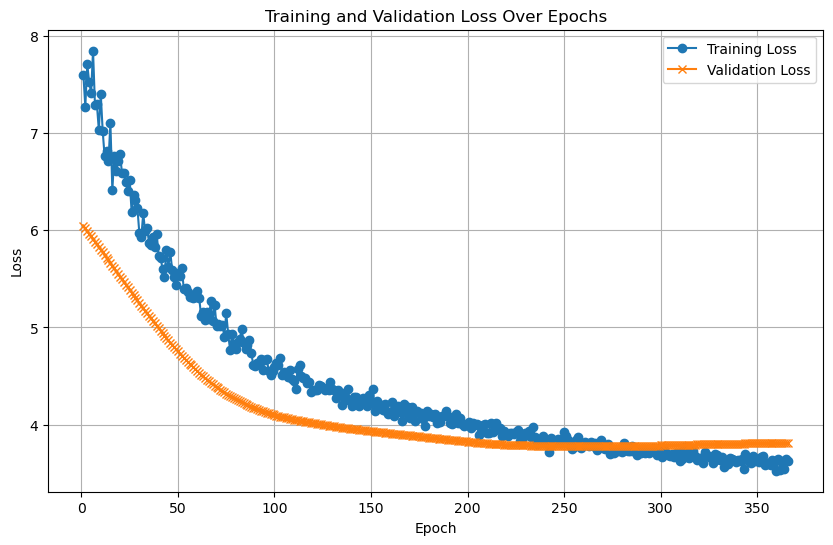

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/20], Loss: 5.9636


Test Batch [20/20], Loss: 4.8222

Test Loss: 5.4468


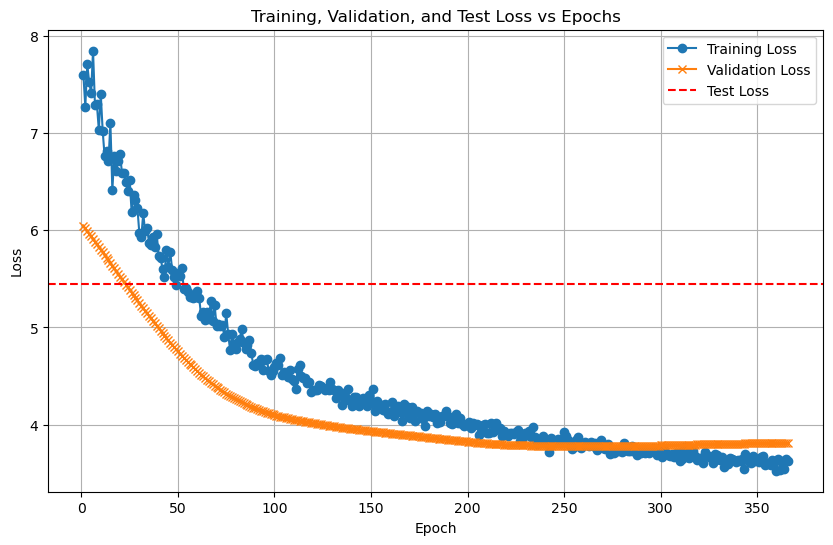

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/20 for test dataset.
  Processed batch 20/20 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (65, 128)
Train labels shape: (65,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (5081, 128)
Test labels shape: (5081,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 38.46%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.40      0.44         5
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         5
           4       0.33      0.20      0.25         5
           5       0.00      0.00      0.00         5
           6       0.26      1.00      0.42         5
           7       0.36      0.80      0.50         5
           8       0.50      0.40      0.44         5
           9       0.00      0.00      0.00         5
          10       0.40      0.80      0.53         5
          11       0.43      0.60      0.50         5
          12       0.80      0.80      0.80         5

    accuracy         

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (65, 128)
Train labels shape: (65,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (5081, 128)
Test labels shape: (5081,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.5129  |  Val Loss: 2.5290
Validation loss improved from inf to 2.5290.
[Epoch 2/1000] Train Loss: 2.5069  |  Val Loss: 2.5224
Validation loss improved from 2.5290 to 2.5224.
[Epoch 3/1000] Train Loss: 2.5023  |  Val Loss: 2.5169
Validation loss improved from 2.5224 to 2.5169.
[Epoch 4/1000] Train Loss: 2.4982  |  Val Loss: 2.5122
Validation loss improved from 2.5169 to 2.5122.
[Epoch 5/1000] Train Loss: 2.4944  |  Val Loss: 2.5080
Validation loss improved from 2.5122 to 2.5080.
[Epoch 6/1000] Train Loss: 2.4909  |  Val Loss: 2.5040
Validation loss improved from 2.5080 to 2.5040.
[Epoch 7/1000] Train Loss: 2.4871  |  Val Loss: 2.4995
Validation loss improved from 2.5040 to 2.4995.
[Epoch 8/1000] Train Loss: 2.4842  |  Val Loss: 2.4955
Validation loss improved from 2.4995 to 2.4955.
[Epoch 9/1000] Train Loss: 2.4818  |  Val Loss: 2.4925
Validation loss improved from 2.4955 to 2.4925.
[Epoch 10/1000] Train Loss: 2.4798  |  Val Loss: 2.4900
Validation loss impr

[Epoch 28/1000] Train Loss: 2.4572  |  Val Loss: 2.4831
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 29/1000] Train Loss: 2.4562  |  Val Loss: 2.4825
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 30/1000] Train Loss: 2.4551  |  Val Loss: 2.4817
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 31/1000] Train Loss: 2.4536  |  Val Loss: 2.4813
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 32/1000] Train Loss: 2.4523  |  Val Loss: 2.4810
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 33/1000] Train Loss: 2.4509  |  Val Loss: 2.4807
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 34/1000] Train Loss: 2.4497  |  Val Loss: 2.4803
Validation loss improved from 2.4805 to 2.4803.
[Epoch 35/1000] Train Loss: 2.4485  |  Val Loss: 2.4797
Validation loss improved from 2.4803 to 2.4797.
[Epoch 36/1000] Train Loss: 2.4475  |  Val Loss: 2.4790
Validation loss improved from 2.4797 to 2.4790.


[Epoch 37/1000] Train Loss: 2.4464  |  Val Loss: 2.4783
Validation loss improved from 2.4790 to 2.4783.
[Epoch 38/1000] Train Loss: 2.4454  |  Val Loss: 2.4774
Validation loss improved from 2.4783 to 2.4774.
[Epoch 39/1000] Train Loss: 2.4444  |  Val Loss: 2.4766
Validation loss improved from 2.4774 to 2.4766.
[Epoch 40/1000] Train Loss: 2.4435  |  Val Loss: 2.4757
Validation loss improved from 2.4766 to 2.4757.
[Epoch 41/1000] Train Loss: 2.4426  |  Val Loss: 2.4746
Validation loss improved from 2.4757 to 2.4746.
[Epoch 42/1000] Train Loss: 2.4417  |  Val Loss: 2.4736
Validation loss improved from 2.4746 to 2.4736.
[Epoch 43/1000] Train Loss: 2.4410  |  Val Loss: 2.4727
Validation loss improved from 2.4736 to 2.4727.
[Epoch 44/1000] Train Loss: 2.4401  |  Val Loss: 2.4719
Validation loss improved from 2.4727 to 2.4719.
[Epoch 45/1000] Train Loss: 2.4390  |  Val Loss: 2.4712
Validation loss improved from 2.4719 to 2.4712.
[Epoch 46/1000] Train Loss: 2.4379  |  Val Loss: 2.4703
Validati

[Epoch 73/1000] Train Loss: 2.4021  |  Val Loss: 2.4469
Validation loss improved from 2.4473 to 2.4469.
[Epoch 74/1000] Train Loss: 2.4009  |  Val Loss: 2.4468
Validation loss improved from 2.4469 to 2.4468.
[Epoch 75/1000] Train Loss: 2.3995  |  Val Loss: 2.4468
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 76/1000] Train Loss: 2.3985  |  Val Loss: 2.4468
Validation loss improved from 2.4468 to 2.4468.
[Epoch 77/1000] Train Loss: 2.3977  |  Val Loss: 2.4467
Validation loss improved from 2.4468 to 2.4467.
[Epoch 78/1000] Train Loss: 2.3970  |  Val Loss: 2.4465
Validation loss improved from 2.4467 to 2.4465.
[Epoch 79/1000] Train Loss: 2.3964  |  Val Loss: 2.4462
Validation loss improved from 2.4465 to 2.4462.
[Epoch 80/1000] Train Loss: 2.3958  |  Val Loss: 2.4458
Validation loss improved from 2.4462 to 2.4458.
[Epoch 81/1000] Train Loss: 2.3953  |  Val Loss: 2.4472
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 82/1000] Train Loss: 2.3948  |  Val Loss: 2.4

[Epoch 118/1000] Train Loss: 2.3720  |  Val Loss: 2.4325
Validation loss improved from 2.4367 to 2.4325.
[Epoch 119/1000] Train Loss: 2.3708  |  Val Loss: 2.4266
Validation loss improved from 2.4325 to 2.4266.
[Epoch 120/1000] Train Loss: 2.3700  |  Val Loss: 2.4216
Validation loss improved from 2.4266 to 2.4216.
[Epoch 121/1000] Train Loss: 2.3690  |  Val Loss: 2.4184
Validation loss improved from 2.4216 to 2.4184.
[Epoch 122/1000] Train Loss: 2.3682  |  Val Loss: 2.4166
Validation loss improved from 2.4184 to 2.4166.
[Epoch 123/1000] Train Loss: 2.3676  |  Val Loss: 2.4155
Validation loss improved from 2.4166 to 2.4155.
[Epoch 124/1000] Train Loss: 2.3671  |  Val Loss: 2.4147
Validation loss improved from 2.4155 to 2.4147.
[Epoch 125/1000] Train Loss: 2.3666  |  Val Loss: 2.4134
Validation loss improved from 2.4147 to 2.4134.
[Epoch 126/1000] Train Loss: 2.3650  |  Val Loss: 2.4120
Validation loss improved from 2.4134 to 2.4120.
[Epoch 127/1000] Train Loss: 2.3630  |  Val Loss: 2.410

[Epoch 159/1000] Train Loss: 2.3340  |  Val Loss: 2.3927
Validation loss improved from 2.3929 to 2.3927.
[Epoch 160/1000] Train Loss: 2.3333  |  Val Loss: 2.3925
Validation loss improved from 2.3927 to 2.3925.
[Epoch 161/1000] Train Loss: 2.3327  |  Val Loss: 2.3923
Validation loss improved from 2.3925 to 2.3923.
[Epoch 162/1000] Train Loss: 2.3320  |  Val Loss: 2.3920
Validation loss improved from 2.3923 to 2.3920.
[Epoch 163/1000] Train Loss: 2.3312  |  Val Loss: 2.3918
Validation loss improved from 2.3920 to 2.3918.
[Epoch 164/1000] Train Loss: 2.3301  |  Val Loss: 2.3925
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 165/1000] Train Loss: 2.3291  |  Val Loss: 2.3938
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 166/1000] Train Loss: 2.3285  |  Val Loss: 2.3955
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 167/1000] Train Loss: 2.3280  |  Val Loss: 2.3974
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 168/1000] Train Loss: 2.

[Epoch 205/1000] Train Loss: 2.2965  |  Val Loss: 2.3855
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 206/1000] Train Loss: 2.2960  |  Val Loss: 2.3847
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 207/1000] Train Loss: 2.2947  |  Val Loss: 2.3831
Validation loss improved from 2.3843 to 2.3831.
[Epoch 208/1000] Train Loss: 2.2933  |  Val Loss: 2.3822
Validation loss improved from 2.3831 to 2.3822.
[Epoch 209/1000] Train Loss: 2.2926  |  Val Loss: 2.3819
Validation loss improved from 2.3822 to 2.3819.
[Epoch 210/1000] Train Loss: 2.2923  |  Val Loss: 2.3819
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 211/1000] Train Loss: 2.2923  |  Val Loss: 2.3821
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 212/1000] Train Loss: 2.2923  |  Val Loss: 2.3823
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 213/1000] Train Loss: 2.2922  |  Val Loss: 2.3826
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 214/1000] 

[Epoch 250/1000] Train Loss: 2.2759  |  Val Loss: 2.3825
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 251/1000] Train Loss: 2.2753  |  Val Loss: 2.3819
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 252/1000] Train Loss: 2.2747  |  Val Loss: 2.3813
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 253/1000] Train Loss: 2.2742  |  Val Loss: 2.3808
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 254/1000] Train Loss: 2.2737  |  Val Loss: 2.3803
Validation loss improved from 2.3805 to 2.3803.
[Epoch 255/1000] Train Loss: 2.2731  |  Val Loss: 2.3799
Validation loss improved from 2.3803 to 2.3799.
[Epoch 256/1000] Train Loss: 2.2726  |  Val Loss: 2.3794
Validation loss improved from 2.3799 to 2.3794.
[Epoch 257/1000] Train Loss: 2.2719  |  Val Loss: 2.3777
Validation loss improved from 2.3794 to 2.3777.
[Epoch 258/1000] Train Loss: 2.2706  |  Val Loss: 2.3754
Validation loss improved from 2.3777 to 2.3754.
[Epoch 259/1000] Train Loss

[Epoch 287/1000] Train Loss: 2.2669  |  Val Loss: 2.3825
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 288/1000] Train Loss: 2.2669  |  Val Loss: 2.3831
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 289/1000] Train Loss: 2.2668  |  Val Loss: 2.3829
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 290/1000] Train Loss: 2.2663  |  Val Loss: 2.3779
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 291/1000] Train Loss: 2.2639  |  Val Loss: 2.3716
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 292/1000] Train Loss: 2.2606  |  Val Loss: 2.3677
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 293/1000] Train Loss: 2.2577  |  Val Loss: 2.3644
Validation loss improved from 2.3654 to 2.3644.
[Epoch 294/1000] Train Loss: 2.2549  |  Val Loss: 2.3620
Validation loss improved from 2.3644 to 2.3620.
[Epoch 295/1000] Train Loss: 2.2527  |  Val Loss: 2.3608
Validation loss improved from 2.3620 to 2.3608.
[Epoch 296/10

[Epoch 328/1000] Train Loss: 2.2379  |  Val Loss: 2.3684
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 329/1000] Train Loss: 2.2376  |  Val Loss: 2.3668
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 330/1000] Train Loss: 2.2374  |  Val Loss: 2.3657
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 331/1000] Train Loss: 2.2373  |  Val Loss: 2.3650
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 332/1000] Train Loss: 2.2373  |  Val Loss: 2.3645
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 333/1000] Train Loss: 2.2373  |  Val Loss: 2.3641
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 334/1000] Train Loss: 2.2373  |  Val Loss: 2.3637
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 335/1000] Train Loss: 2.2372  |  Val Loss: 2.3634
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 336/1000] Train Loss: 2.2370  |  Val Loss: 2.3631
!! Validation loss did NOT improve !! Patience:

[Epoch 370/1000] Train Loss: 2.2214  |  Val Loss: 2.3552
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 371/1000] Train Loss: 2.2212  |  Val Loss: 2.3553
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 372/1000] Train Loss: 2.2209  |  Val Loss: 2.3546
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 373/1000] Train Loss: 2.2204  |  Val Loss: 2.3535
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 374/1000] Train Loss: 2.2202  |  Val Loss: 2.3527
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 375/1000] Train Loss: 2.2202  |  Val Loss: 2.3522
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 376/1000] Train Loss: 2.2203  |  Val Loss: 2.3519
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 377/1000] Train Loss: 2.2205  |  Val Loss: 2.3533
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 378/1000] Train Loss: 2.2206  |  Val Loss: 2.3559
!! Validation loss did NOT improve !! Patience: 

[Epoch 410/1000] Train Loss: 2.2112  |  Val Loss: 2.3711
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 411/1000] Train Loss: 2.2117  |  Val Loss: 2.3718
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 412/1000] Train Loss: 2.2119  |  Val Loss: 2.3721
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 413/1000] Train Loss: 2.2118  |  Val Loss: 2.3720
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 414/1000] Train Loss: 2.2114  |  Val Loss: 2.3715
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 415/1000] Train Loss: 2.2107  |  Val Loss: 2.3705
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 416/1000] Train Loss: 2.2098  |  Val Loss: 2.3693
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 417/1000] Train Loss: 2.2087  |  Val Loss: 2.3679
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 418/1000] Train Loss: 2.2076  |  Val Loss: 2.3664
!! Validation loss did NOT improve !! Patience:

[Epoch 450/1000] Train Loss: 2.1868  |  Val Loss: 2.3377
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 451/1000] Train Loss: 2.1864  |  Val Loss: 2.3405
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 452/1000] Train Loss: 2.1863  |  Val Loss: 2.3428
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 453/1000] Train Loss: 2.1864  |  Val Loss: 2.3428
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 454/1000] Train Loss: 2.1856  |  Val Loss: 2.3414
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 455/1000] Train Loss: 2.1845  |  Val Loss: 2.3403
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 456/1000] Train Loss: 2.1837  |  Val Loss: 2.3405
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 457/1000] Train Loss: 2.1831  |  Val Loss: 2.3425
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 458/1000] Train Loss: 2.1832  |  Val Loss: 2.3445
!! Validation loss did NOT improve !! Patience: 14/

[Epoch 488/1000] Train Loss: 2.1834  |  Val Loss: 2.3253
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 489/1000] Train Loss: 2.1832  |  Val Loss: 2.3252
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 490/1000] Train Loss: 2.1828  |  Val Loss: 2.3251
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 491/1000] Train Loss: 2.1825  |  Val Loss: 2.3247
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 492/1000] Train Loss: 2.1818  |  Val Loss: 2.3235
Validation loss improved from 2.3244 to 2.3235.
[Epoch 493/1000] Train Loss: 2.1803  |  Val Loss: 2.3219
Validation loss improved from 2.3235 to 2.3219.
[Epoch 494/1000] Train Loss: 2.1782  |  Val Loss: 2.3207
Validation loss improved from 2.3219 to 2.3207.
[Epoch 495/1000] Train Loss: 2.1764  |  Val Loss: 2.3198
Validation loss improved from 2.3207 to 2.3198.
[Epoch 496/1000] Train Loss: 2.1747  |  Val Loss: 2.3194
Validation loss improved from 2.3198 to 2.3194.
[Epoch 497/1000] Train Loss: 2.

[Epoch 525/1000] Train Loss: 2.1601  |  Val Loss: 2.3419
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 526/1000] Train Loss: 2.1606  |  Val Loss: 2.3444
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 527/1000] Train Loss: 2.1611  |  Val Loss: 2.3462
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 528/1000] Train Loss: 2.1614  |  Val Loss: 2.3474
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 529/1000] Train Loss: 2.1616  |  Val Loss: 2.3481
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 530/1000] Train Loss: 2.1615  |  Val Loss: 2.3484
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 531/1000] Train Loss: 2.1613  |  Val Loss: 2.3478
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 532/1000] Train Loss: 2.1608  |  Val Loss: 2.3465
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 533/1000] Train Loss: 2.1601  |  Val Loss: 2.3452
!! Validation loss did NOT improve !! Patience:

[Epoch 569/1000] Train Loss: 2.1431  |  Val Loss: 2.3160
Validation loss improved from 2.3179 to 2.3160.
[Epoch 570/1000] Train Loss: 2.1429  |  Val Loss: 2.3143
Validation loss improved from 2.3160 to 2.3143.
[Epoch 571/1000] Train Loss: 2.1427  |  Val Loss: 2.3129
Validation loss improved from 2.3143 to 2.3129.
[Epoch 572/1000] Train Loss: 2.1424  |  Val Loss: 2.3116
Validation loss improved from 2.3129 to 2.3116.
[Epoch 573/1000] Train Loss: 2.1421  |  Val Loss: 2.3108
Validation loss improved from 2.3116 to 2.3108.
[Epoch 574/1000] Train Loss: 2.1416  |  Val Loss: 2.3102
Validation loss improved from 2.3108 to 2.3102.
[Epoch 575/1000] Train Loss: 2.1411  |  Val Loss: 2.3097
Validation loss improved from 2.3102 to 2.3097.
[Epoch 576/1000] Train Loss: 2.1404  |  Val Loss: 2.3063
Validation loss improved from 2.3097 to 2.3063.
[Epoch 577/1000] Train Loss: 2.1402  |  Val Loss: 2.3015
Validation loss improved from 2.3063 to 2.3015.
[Epoch 578/1000] Train Loss: 2.1408  |  Val Loss: 2.298

[Epoch 612/1000] Train Loss: 2.1311  |  Val Loss: 2.3024
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 613/1000] Train Loss: 2.1308  |  Val Loss: 2.3025
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 614/1000] Train Loss: 2.1304  |  Val Loss: 2.3023
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 615/1000] Train Loss: 2.1298  |  Val Loss: 2.3018
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 616/1000] Train Loss: 2.1291  |  Val Loss: 2.3012
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 617/1000] Train Loss: 2.1285  |  Val Loss: 2.3008
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 618/1000] Train Loss: 2.1279  |  Val Loss: 2.2968
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 619/1000] Train Loss: 2.1270  |  Val Loss: 2.2908
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 620/1000] Train Loss: 2.1272  |  Val Loss: 2.2868
!! Validation loss did NOT improve !! Patience:

[Epoch 655/1000] Train Loss: 2.1101  |  Val Loss: 2.3007
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 656/1000] Train Loss: 2.1098  |  Val Loss: 2.2998
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 657/1000] Train Loss: 2.1095  |  Val Loss: 2.3026
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 658/1000] Train Loss: 2.1090  |  Val Loss: 2.3086
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 659/1000] Train Loss: 2.1091  |  Val Loss: 2.3133
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 660/1000] Train Loss: 2.1096  |  Val Loss: 2.3171
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 661/1000] Train Loss: 2.1102  |  Val Loss: 2.3199
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 662/1000] Train Loss: 2.1106  |  Val Loss: 2.3219
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 663/1000] Train Loss: 2.1109  |  Val Loss: 2.3232
!! Validation loss did NOT improve !! Patience:

[Epoch 691/1000] Train Loss: 2.0975  |  Val Loss: 2.2695
Validation loss improved from 2.2708 to 2.2695.
[Epoch 692/1000] Train Loss: 2.0974  |  Val Loss: 2.2687
Validation loss improved from 2.2695 to 2.2687.
[Epoch 693/1000] Train Loss: 2.0974  |  Val Loss: 2.2685
Validation loss improved from 2.2687 to 2.2685.
[Epoch 694/1000] Train Loss: 2.0974  |  Val Loss: 2.2685
Validation loss improved from 2.2685 to 2.2685.
[Epoch 695/1000] Train Loss: 2.0973  |  Val Loss: 2.2686
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 696/1000] Train Loss: 2.0971  |  Val Loss: 2.2689
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 697/1000] Train Loss: 2.0968  |  Val Loss: 2.2695
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 698/1000] Train Loss: 2.0964  |  Val Loss: 2.2706
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 699/1000] Train Loss: 2.0962  |  Val Loss: 2.2720
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 700/1000] Train Lo

[Epoch 728/1000] Train Loss: 2.0896  |  Val Loss: 2.2875
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 729/1000] Train Loss: 2.0891  |  Val Loss: 2.2828
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 730/1000] Train Loss: 2.0871  |  Val Loss: 2.2741
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 731/1000] Train Loss: 2.0855  |  Val Loss: 2.2680
Validation loss improved from 2.2685 to 2.2680.
[Epoch 732/1000] Train Loss: 2.0856  |  Val Loss: 2.2636
Validation loss improved from 2.2680 to 2.2636.
[Epoch 733/1000] Train Loss: 2.0862  |  Val Loss: 2.2604
Validation loss improved from 2.2636 to 2.2604.
[Epoch 734/1000] Train Loss: 2.0867  |  Val Loss: 2.2582
Validation loss improved from 2.2604 to 2.2582.
[Epoch 735/1000] Train Loss: 2.0872  |  Val Loss: 2.2569
Validation loss improved from 2.2582 to 2.2569.
[Epoch 736/1000] Train Loss: 2.0874  |  Val Loss: 2.2561
Validation loss improved from 2.2569 to 2.2561.
[Epoch 737/1000] Train Loss: 2.087

[Epoch 770/1000] Train Loss: 2.0674  |  Val Loss: 2.2859
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 771/1000] Train Loss: 2.0674  |  Val Loss: 2.2878
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 772/1000] Train Loss: 2.0673  |  Val Loss: 2.2923
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 773/1000] Train Loss: 2.0677  |  Val Loss: 2.2989
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 774/1000] Train Loss: 2.0686  |  Val Loss: 2.3011
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 775/1000] Train Loss: 2.0680  |  Val Loss: 2.3001
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 776/1000] Train Loss: 2.0672  |  Val Loss: 2.2933
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 777/1000] Train Loss: 2.0650  |  Val Loss: 2.2828
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 778/1000] Train Loss: 2.0629  |  Val Loss: 2.2754
!! Validation loss did NOT improve !! Patience:

[Epoch 814/1000] Train Loss: 2.0641  |  Val Loss: 2.2420
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 815/1000] Train Loss: 2.0637  |  Val Loss: 2.2426
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 816/1000] Train Loss: 2.0628  |  Val Loss: 2.2431
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 817/1000] Train Loss: 2.0616  |  Val Loss: 2.2429
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 818/1000] Train Loss: 2.0598  |  Val Loss: 2.2425
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 819/1000] Train Loss: 2.0576  |  Val Loss: 2.2424
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 820/1000] Train Loss: 2.0556  |  Val Loss: 2.2426
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 821/1000] Train Loss: 2.0538  |  Val Loss: 2.2430
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 822/1000] Train Loss: 2.0520  |  Val Loss: 2.2435
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 855/1000] Train Loss: 2.0343  |  Val Loss: 2.2518
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 856/1000] Train Loss: 2.0344  |  Val Loss: 2.2516
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 857/1000] Train Loss: 2.0342  |  Val Loss: 2.2512
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 858/1000] Train Loss: 2.0338  |  Val Loss: 2.2509
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 859/1000] Train Loss: 2.0334  |  Val Loss: 2.2502
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 860/1000] Train Loss: 2.0329  |  Val Loss: 2.2494
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 861/1000] Train Loss: 2.0324  |  Val Loss: 2.2492
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 862/1000] Train Loss: 2.0318  |  Val Loss: 2.2495
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 863/1000] Train Loss: 2.0311  |  Val Loss: 2.2492
!! Validation loss did NOT improve !! Patience:

[Epoch 897/1000] Train Loss: 2.0185  |  Val Loss: 2.2347
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 898/1000] Train Loss: 2.0192  |  Val Loss: 2.2306
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 899/1000] Train Loss: 2.0204  |  Val Loss: 2.2277
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 900/1000] Train Loss: 2.0218  |  Val Loss: 2.2260
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 901/1000] Train Loss: 2.0231  |  Val Loss: 2.2250
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 902/1000] Train Loss: 2.0240  |  Val Loss: 2.2244
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 903/1000] Train Loss: 2.0243  |  Val Loss: 2.2241
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 904/1000] Train Loss: 2.0242  |  Val Loss: 2.2242
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 905/1000] Train Loss: 2.0239  |  Val Loss: 2.2243
!! Validation loss did NOT improve !! Patience:

[Epoch 942/1000] Train Loss: 2.0035  |  Val Loss: 2.2322
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 943/1000] Train Loss: 2.0027  |  Val Loss: 2.2279
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 944/1000] Train Loss: 2.0022  |  Val Loss: 2.2248
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 945/1000] Train Loss: 2.0021  |  Val Loss: 2.2228
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 946/1000] Train Loss: 2.0022  |  Val Loss: 2.2215
Validation loss improved from 2.2218 to 2.2215.
[Epoch 947/1000] Train Loss: 2.0023  |  Val Loss: 2.2207
Validation loss improved from 2.2215 to 2.2207.
[Epoch 948/1000] Train Loss: 2.0023  |  Val Loss: 2.2202
Validation loss improved from 2.2207 to 2.2202.
[Epoch 949/1000] Train Loss: 2.0022  |  Val Loss: 2.2196
Validation loss improved from 2.2202 to 2.2196.
[Epoch 950/1000] Train Loss: 2.0020  |  Val Loss: 2.2189
Validation loss improved from 2.2196 to 2.2189.
[Epoch 951/1000] Train Loss

[Epoch 986/1000] Train Loss: 1.9865  |  Val Loss: 2.2266
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 987/1000] Train Loss: 1.9860  |  Val Loss: 2.2259
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 988/1000] Train Loss: 1.9855  |  Val Loss: 2.2254
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 989/1000] Train Loss: 1.9851  |  Val Loss: 2.2250
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 990/1000] Train Loss: 1.9846  |  Val Loss: 2.2246
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 991/1000] Train Loss: 1.9841  |  Val Loss: 2.2239
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 992/1000] Train Loss: 1.9835  |  Val Loss: 2.2233
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 993/1000] Train Loss: 1.9828  |  Val Loss: 2.2230
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 994/1000] Train Loss: 1.9823  |  Val Loss: 2.2229
!! Validation loss did NOT improve !! Patience:

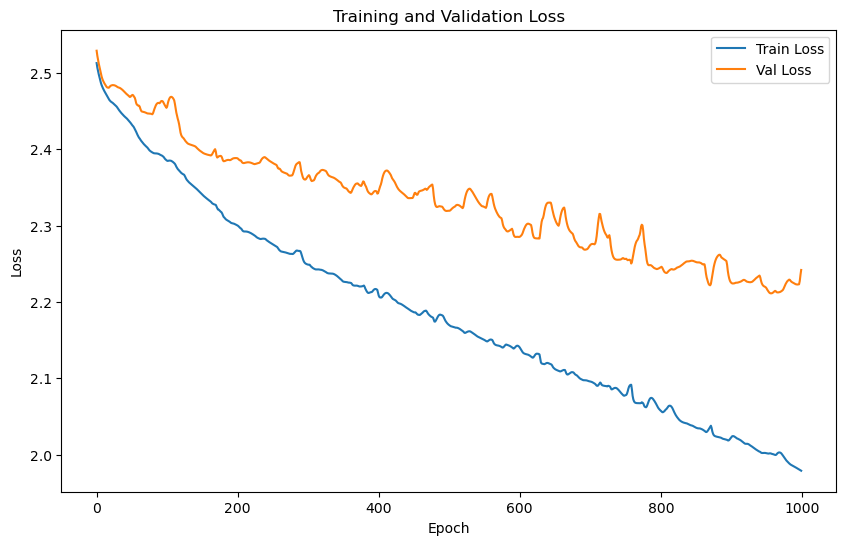

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 2.2896 | Test Accuracy: 24.78%


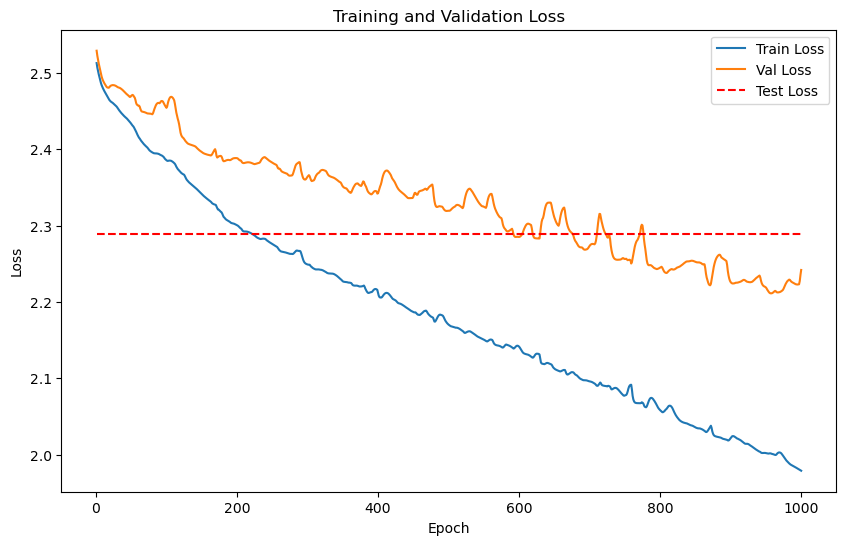

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 5081 samples with 64 features each
LOG: Labels shape: (5081,)


Train embeddings shape: (65, 64), 
Train labels shape: (65,)


Val embeddings shape: (65, 64), 
Val labels shape: (65,)


Test embeddings shape: (5081, 64), 
Test labels shape: (5081,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5}
Training batch size: 65


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.5435
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.6382
    Batch [2/2], Val Loss: 0.5000
Epoch [1/2000], Avg Train Loss: 0.5435, Avg Val Loss: 0.5691

Validation loss improved from inf to 0.5691. Saving model...
LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 0.5445
LOG: Epoch [2/2000] - Validation


    Batch [1/2], Val Loss: 0.6374
    Batch [2/2], Val Loss: 0.5000
Epoch [2/2000], Avg Train Loss: 0.5445, Avg Val Loss: 0.5687

Validation loss improved from 0.5691 to 0.5687. Saving model...
LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 0.5553
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.6370
    Batch [2/2], Val Loss: 0.5000
Epoch [3/2000], Avg Train Loss: 0.5553, Avg Val Loss: 0.5685

Validation loss improved from 0.5687 to 0.5685. Saving model...
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.5415
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.6367
    Batch [2/2], Val Loss: 0.5000
Epoch [4/2000], Avg Train Loss: 0.5415, Avg Val Loss: 0.5684

Validation loss improved from 0.5685 to 0.5684. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.5474
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.6360
    Batch [2/2], Val Loss: 0.5000
Epoch [5/2000], Avg Train Loss: 0.5474, Avg Val Loss: 0.5680

Validation loss improved from 0.5684 to 0.5680. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.5349
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.6354
    Batch [2/2], Val Loss: 0.5000
Epoch [6/2000], Avg Train Loss: 0.5349, Avg Val Loss: 0.5677

Validation loss improved from 0.5680 to 0.5677. Saving model...
LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 0.5377
LOG: Epoch [7/2000] - Validation


    Batch [1/2], Val Loss: 0.6343
    Batch [2/2], Val Loss: 0.5000
Epoch [7/2000], Avg Train Loss: 0.5377, Avg Val Loss: 0.5671

Validation loss improved from 0.5677 to 0.5671. Saving model...
LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 0.5396
LOG: Epoch [8/2000] - Validation


    Batch [1/2], Val Loss: 0.6327
    Batch [2/2], Val Loss: 0.5000
Epoch [8/2000], Avg Train Loss: 0.5396, Avg Val Loss: 0.5664

Validation loss improved from 0.5671 to 0.5664. Saving model...
LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 0.5414
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.6323
    Batch [2/2], Val Loss: 0.5000
Epoch [9/2000], Avg Train Loss: 0.5414, Avg Val Loss: 0.5662

Validation loss improved from 0.5664 to 0.5662. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.5328
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.6297
    Batch [2/2], Val Loss: 0.5000
Epoch [10/2000], Avg Train Loss: 0.5328, Avg Val Loss: 0.5648

Validation loss improved from 0.5662 to 0.5648. Saving model...
LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 0.5431
LOG: Epoch [11/2000] - Validation


    Batch [1/2], Val Loss: 0.6281
    Batch [2/2], Val Loss: 0.5000
Epoch [11/2000], Avg Train Loss: 0.5431, Avg Val Loss: 0.5641

Validation loss improved from 0.5648 to 0.5641. Saving model...
LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 0.5352
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.6263
    Batch [2/2], Val Loss: 0.5000
Epoch [12/2000], Avg Train Loss: 0.5352, Avg Val Loss: 0.5632

Validation loss improved from 0.5641 to 0.5632. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.5360
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.6248
    Batch [2/2], Val Loss: 0.5000
Epoch [13/2000], Avg Train Loss: 0.5360, Avg Val Loss: 0.5624

Validation loss improved from 0.5632 to 0.5624. Saving model...
LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 0.5385
LOG: Epoch [14/2000] - Validation


    Batch [1/2], Val Loss: 0.6246
    Batch [2/2], Val Loss: 0.5000
Epoch [14/2000], Avg Train Loss: 0.5385, Avg Val Loss: 0.5623

Validation loss improved from 0.5624 to 0.5623. Saving model...
LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 0.5312
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.6251
    Batch [2/2], Val Loss: 0.5000
Epoch [15/2000], Avg Train Loss: 0.5312, Avg Val Loss: 0.5625

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.5343
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.6226
    Batch [2/2], Val Loss: 0.5000
Epoch [16/2000], Avg Train Loss: 0.5343, Avg Val Loss: 0.5613

Validation loss improved from 0.5623 to 0.5613. Saving model...
LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 0.5304
LOG: Epoch [17/2000] - Validation


    Batch [1/2], Val Loss: 0.6200
    Batch [2/2], Val Loss: 0.5000
Epoch [17/2000], Avg Train Loss: 0.5304, Avg Val Loss: 0.5600

Validation loss improved from 0.5613 to 0.5600. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 0.5254
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.6160
    Batch [2/2], Val Loss: 0.5000
Epoch [18/2000], Avg Train Loss: 0.5254, Avg Val Loss: 0.5580

Validation loss improved from 0.5600 to 0.5580. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.5283
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.6139
    Batch [2/2], Val Loss: 0.5000
Epoch [19/2000], Avg Train Loss: 0.5283, Avg Val Loss: 0.5569

Validation loss improved from 0.5580 to 0.5569. Saving model...
LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 0.5239
LOG: Epoch [20/2000] - Validation


    Batch [1/2], Val Loss: 0.6116
    Batch [2/2], Val Loss: 0.5000
Epoch [20/2000], Avg Train Loss: 0.5239, Avg Val Loss: 0.5558

Validation loss improved from 0.5569 to 0.5558. Saving model...
LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 0.5318
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.6097
    Batch [2/2], Val Loss: 0.5000
Epoch [21/2000], Avg Train Loss: 0.5318, Avg Val Loss: 0.5549

Validation loss improved from 0.5558 to 0.5549. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.5283
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.6072
    Batch [2/2], Val Loss: 0.5000
Epoch [22/2000], Avg Train Loss: 0.5283, Avg Val Loss: 0.5536

Validation loss improved from 0.5549 to 0.5536. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.5262
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.6057
    Batch [2/2], Val Loss: 0.5000
Epoch [23/2000], Avg Train Loss: 0.5262, Avg Val Loss: 0.5528

Validation loss improved from 0.5536 to 0.5528. Saving model...
LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 0.5249
LOG: Epoch [24/2000] - Validation


    Batch [1/2], Val Loss: 0.6037
    Batch [2/2], Val Loss: 0.5000
Epoch [24/2000], Avg Train Loss: 0.5249, Avg Val Loss: 0.5519

Validation loss improved from 0.5528 to 0.5519. Saving model...
LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 0.5329
LOG: Epoch [25/2000] - Validation


    Batch [1/2], Val Loss: 0.6020
    Batch [2/2], Val Loss: 0.5000
Epoch [25/2000], Avg Train Loss: 0.5329, Avg Val Loss: 0.5510

Validation loss improved from 0.5519 to 0.5510. Saving model...
LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 0.5198
LOG: Epoch [26/2000] - Validation


    Batch [1/2], Val Loss: 0.6003
    Batch [2/2], Val Loss: 0.5000
Epoch [26/2000], Avg Train Loss: 0.5198, Avg Val Loss: 0.5502

Validation loss improved from 0.5510 to 0.5502. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 0.5244
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.5984
    Batch [2/2], Val Loss: 0.5000
Epoch [27/2000], Avg Train Loss: 0.5244, Avg Val Loss: 0.5492

Validation loss improved from 0.5502 to 0.5492. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.5136
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.5963
    Batch [2/2], Val Loss: 0.5000
Epoch [28/2000], Avg Train Loss: 0.5136, Avg Val Loss: 0.5482

Validation loss improved from 0.5492 to 0.5482. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.5207
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.5938
    Batch [2/2], Val Loss: 0.5000
Epoch [29/2000], Avg Train Loss: 0.5207, Avg Val Loss: 0.5469

Validation loss improved from 0.5482 to 0.5469. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 0.5223
LOG: Epoch [30/2000] - Validation


    Batch [1/2], Val Loss: 0.5915
    Batch [2/2], Val Loss: 0.5000
Epoch [30/2000], Avg Train Loss: 0.5223, Avg Val Loss: 0.5457

Validation loss improved from 0.5469 to 0.5457. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 0.5181
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.5891
    Batch [2/2], Val Loss: 0.5000
Epoch [31/2000], Avg Train Loss: 0.5181, Avg Val Loss: 0.5445

Validation loss improved from 0.5457 to 0.5445. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.5244
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.5867
    Batch [2/2], Val Loss: 0.5000
Epoch [32/2000], Avg Train Loss: 0.5244, Avg Val Loss: 0.5434

Validation loss improved from 0.5445 to 0.5434. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 0.5154
LOG: Epoch [33/2000] - Validation


    Batch [1/2], Val Loss: 0.5842
    Batch [2/2], Val Loss: 0.5000
Epoch [33/2000], Avg Train Loss: 0.5154, Avg Val Loss: 0.5421

Validation loss improved from 0.5434 to 0.5421. Saving model...
LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 0.5130
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.5815
    Batch [2/2], Val Loss: 0.5000
Epoch [34/2000], Avg Train Loss: 0.5130, Avg Val Loss: 0.5407

Validation loss improved from 0.5421 to 0.5407. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.5161
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.5791
    Batch [2/2], Val Loss: 0.5000
Epoch [35/2000], Avg Train Loss: 0.5161, Avg Val Loss: 0.5395

Validation loss improved from 0.5407 to 0.5395. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 0.5198
LOG: Epoch [36/2000] - Validation


    Batch [1/2], Val Loss: 0.5771
    Batch [2/2], Val Loss: 0.5000
Epoch [36/2000], Avg Train Loss: 0.5198, Avg Val Loss: 0.5386

Validation loss improved from 0.5395 to 0.5386. Saving model...
LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 0.5117
LOG: Epoch [37/2000] - Validation


    Batch [1/2], Val Loss: 0.5751
    Batch [2/2], Val Loss: 0.5000
Epoch [37/2000], Avg Train Loss: 0.5117, Avg Val Loss: 0.5375

Validation loss improved from 0.5386 to 0.5375. Saving model...
LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 0.5123
LOG: Epoch [38/2000] - Validation


    Batch [1/2], Val Loss: 0.5731
    Batch [2/2], Val Loss: 0.5000
Epoch [38/2000], Avg Train Loss: 0.5123, Avg Val Loss: 0.5366

Validation loss improved from 0.5375 to 0.5366. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 0.5123
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.5710
    Batch [2/2], Val Loss: 0.5000
Epoch [39/2000], Avg Train Loss: 0.5123, Avg Val Loss: 0.5355

Validation loss improved from 0.5366 to 0.5355. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.5092
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.5691
    Batch [2/2], Val Loss: 0.5000
Epoch [40/2000], Avg Train Loss: 0.5092, Avg Val Loss: 0.5346

Validation loss improved from 0.5355 to 0.5346. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 0.5140
LOG: Epoch [41/2000] - Validation


    Batch [1/2], Val Loss: 0.5674
    Batch [2/2], Val Loss: 0.5000
Epoch [41/2000], Avg Train Loss: 0.5140, Avg Val Loss: 0.5337

Validation loss improved from 0.5346 to 0.5337. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 0.5157
LOG: Epoch [42/2000] - Validation


    Batch [1/2], Val Loss: 0.5659
    Batch [2/2], Val Loss: 0.5000
Epoch [42/2000], Avg Train Loss: 0.5157, Avg Val Loss: 0.5329

Validation loss improved from 0.5337 to 0.5329. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 0.5095
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.5644
    Batch [2/2], Val Loss: 0.5000
Epoch [43/2000], Avg Train Loss: 0.5095, Avg Val Loss: 0.5322

Validation loss improved from 0.5329 to 0.5322. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.5014
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.5629
    Batch [2/2], Val Loss: 0.5000
Epoch [44/2000], Avg Train Loss: 0.5014, Avg Val Loss: 0.5315

Validation loss improved from 0.5322 to 0.5315. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.5036
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.5614
    Batch [2/2], Val Loss: 0.5000
Epoch [45/2000], Avg Train Loss: 0.5036, Avg Val Loss: 0.5307

Validation loss improved from 0.5315 to 0.5307. Saving model...
LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 0.5143
LOG: Epoch [46/2000] - Validation


    Batch [1/2], Val Loss: 0.5600
    Batch [2/2], Val Loss: 0.5000
Epoch [46/2000], Avg Train Loss: 0.5143, Avg Val Loss: 0.5300

Validation loss improved from 0.5307 to 0.5300. Saving model...
LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 0.5049
LOG: Epoch [47/2000] - Validation


    Batch [1/2], Val Loss: 0.5587
    Batch [2/2], Val Loss: 0.5000
Epoch [47/2000], Avg Train Loss: 0.5049, Avg Val Loss: 0.5294

Validation loss improved from 0.5300 to 0.5294. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 0.5144
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.5574
    Batch [2/2], Val Loss: 0.5000
Epoch [48/2000], Avg Train Loss: 0.5144, Avg Val Loss: 0.5287

Validation loss improved from 0.5294 to 0.5287. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.5090
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.5562
    Batch [2/2], Val Loss: 0.5000
Epoch [49/2000], Avg Train Loss: 0.5090, Avg Val Loss: 0.5281

Validation loss improved from 0.5287 to 0.5281. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 0.5091
LOG: Epoch [50/2000] - Validation


    Batch [1/2], Val Loss: 0.5549
    Batch [2/2], Val Loss: 0.5000
Epoch [50/2000], Avg Train Loss: 0.5091, Avg Val Loss: 0.5275

Validation loss improved from 0.5281 to 0.5275. Saving model...
LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 0.5140
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.5538
    Batch [2/2], Val Loss: 0.5000
Epoch [51/2000], Avg Train Loss: 0.5140, Avg Val Loss: 0.5269

Validation loss improved from 0.5275 to 0.5269. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.5126
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.5526
    Batch [2/2], Val Loss: 0.5000
Epoch [52/2000], Avg Train Loss: 0.5126, Avg Val Loss: 0.5263

Validation loss improved from 0.5269 to 0.5263. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 0.5111
LOG: Epoch [53/2000] - Validation


    Batch [1/2], Val Loss: 0.5515
    Batch [2/2], Val Loss: 0.5000
Epoch [53/2000], Avg Train Loss: 0.5111, Avg Val Loss: 0.5258

Validation loss improved from 0.5263 to 0.5258. Saving model...
LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 0.5059
LOG: Epoch [54/2000] - Validation


    Batch [1/2], Val Loss: 0.5506
    Batch [2/2], Val Loss: 0.5000
Epoch [54/2000], Avg Train Loss: 0.5059, Avg Val Loss: 0.5253

Validation loss improved from 0.5258 to 0.5253. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 0.5056
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.5496
    Batch [2/2], Val Loss: 0.5000
Epoch [55/2000], Avg Train Loss: 0.5056, Avg Val Loss: 0.5248

Validation loss improved from 0.5253 to 0.5248. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.5080
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.5487
    Batch [2/2], Val Loss: 0.5000
Epoch [56/2000], Avg Train Loss: 0.5080, Avg Val Loss: 0.5244

Validation loss improved from 0.5248 to 0.5244. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 0.5039
LOG: Epoch [57/2000] - Validation


    Batch [1/2], Val Loss: 0.5478
    Batch [2/2], Val Loss: 0.5000
Epoch [57/2000], Avg Train Loss: 0.5039, Avg Val Loss: 0.5239

Validation loss improved from 0.5244 to 0.5239. Saving model...
LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 0.5063
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.5470
    Batch [2/2], Val Loss: 0.5000
Epoch [58/2000], Avg Train Loss: 0.5063, Avg Val Loss: 0.5235

Validation loss improved from 0.5239 to 0.5235. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.5085
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.5462
    Batch [2/2], Val Loss: 0.5000
Epoch [59/2000], Avg Train Loss: 0.5085, Avg Val Loss: 0.5231

Validation loss improved from 0.5235 to 0.5231. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.5071
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.5454
    Batch [2/2], Val Loss: 0.5000
Epoch [60/2000], Avg Train Loss: 0.5071, Avg Val Loss: 0.5227

Validation loss improved from 0.5231 to 0.5227. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 0.5097
LOG: Epoch [61/2000] - Validation


    Batch [1/2], Val Loss: 0.5445
    Batch [2/2], Val Loss: 0.5000
Epoch [61/2000], Avg Train Loss: 0.5097, Avg Val Loss: 0.5223

Validation loss improved from 0.5227 to 0.5223. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 0.5041
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.5437
    Batch [2/2], Val Loss: 0.5000
Epoch [62/2000], Avg Train Loss: 0.5041, Avg Val Loss: 0.5218

Validation loss improved from 0.5223 to 0.5218. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.5034
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.5429
    Batch [2/2], Val Loss: 0.5000
Epoch [63/2000], Avg Train Loss: 0.5034, Avg Val Loss: 0.5215

Validation loss improved from 0.5218 to 0.5215. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.5072
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.5422
    Batch [2/2], Val Loss: 0.5000
Epoch [64/2000], Avg Train Loss: 0.5072, Avg Val Loss: 0.5211

Validation loss improved from 0.5215 to 0.5211. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 0.5011
LOG: Epoch [65/2000] - Validation


    Batch [1/2], Val Loss: 0.5417
    Batch [2/2], Val Loss: 0.5000
Epoch [65/2000], Avg Train Loss: 0.5011, Avg Val Loss: 0.5208

Validation loss improved from 0.5211 to 0.5208. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 0.5030
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.5411
    Batch [2/2], Val Loss: 0.5000
Epoch [66/2000], Avg Train Loss: 0.5030, Avg Val Loss: 0.5205

Validation loss improved from 0.5208 to 0.5205. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.5060
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.5405
    Batch [2/2], Val Loss: 0.5000
Epoch [67/2000], Avg Train Loss: 0.5060, Avg Val Loss: 0.5203

Validation loss improved from 0.5205 to 0.5203. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 0.5025
LOG: Epoch [68/2000] - Validation


    Batch [1/2], Val Loss: 0.5399
    Batch [2/2], Val Loss: 0.5000
Epoch [68/2000], Avg Train Loss: 0.5025, Avg Val Loss: 0.5200

Validation loss improved from 0.5203 to 0.5200. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 0.4964
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.5392
    Batch [2/2], Val Loss: 0.5000
Epoch [69/2000], Avg Train Loss: 0.4964, Avg Val Loss: 0.5196

Validation loss improved from 0.5200 to 0.5196. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4965
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.5386
    Batch [2/2], Val Loss: 0.5000
Epoch [70/2000], Avg Train Loss: 0.4965, Avg Val Loss: 0.5193

Validation loss improved from 0.5196 to 0.5193. Saving model...
LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 0.4989
LOG: Epoch [71/2000] - Validation


    Batch [1/2], Val Loss: 0.5379
    Batch [2/2], Val Loss: 0.5000
Epoch [71/2000], Avg Train Loss: 0.4989, Avg Val Loss: 0.5189

Validation loss improved from 0.5193 to 0.5189. Saving model...
LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 0.5000
LOG: Epoch [72/2000] - Validation


    Batch [1/2], Val Loss: 0.5374
    Batch [2/2], Val Loss: 0.5000
Epoch [72/2000], Avg Train Loss: 0.5000, Avg Val Loss: 0.5187

Validation loss improved from 0.5189 to 0.5187. Saving model...
LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 0.4984
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.5372
    Batch [2/2], Val Loss: 0.5000
Epoch [73/2000], Avg Train Loss: 0.4984, Avg Val Loss: 0.5186

Validation loss improved from 0.5187 to 0.5186. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.5078
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.5371
    Batch [2/2], Val Loss: 0.5000
Epoch [74/2000], Avg Train Loss: 0.5078, Avg Val Loss: 0.5185

Validation loss improved from 0.5186 to 0.5185. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4956
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.5369
    Batch [2/2], Val Loss: 0.5000
Epoch [75/2000], Avg Train Loss: 0.4956, Avg Val Loss: 0.5185

Validation loss improved from 0.5185 to 0.5185. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4980
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.5368
    Batch [2/2], Val Loss: 0.5000
Epoch [76/2000], Avg Train Loss: 0.4980, Avg Val Loss: 0.5184

Validation loss improved from 0.5185 to 0.5184. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 0.5000
LOG: Epoch [77/2000] - Validation


    Batch [1/2], Val Loss: 0.5367
    Batch [2/2], Val Loss: 0.5000
Epoch [77/2000], Avg Train Loss: 0.5000, Avg Val Loss: 0.5184

Validation loss improved from 0.5184 to 0.5184. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 0.4977
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.5366
    Batch [2/2], Val Loss: 0.5000
Epoch [78/2000], Avg Train Loss: 0.4977, Avg Val Loss: 0.5183

Validation loss improved from 0.5184 to 0.5183. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4965
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.5364
    Batch [2/2], Val Loss: 0.5000
Epoch [79/2000], Avg Train Loss: 0.4965, Avg Val Loss: 0.5182

Validation loss improved from 0.5183 to 0.5182. Saving model...
LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 0.4938
LOG: Epoch [80/2000] - Validation


    Batch [1/2], Val Loss: 0.5362
    Batch [2/2], Val Loss: 0.5000
Epoch [80/2000], Avg Train Loss: 0.4938, Avg Val Loss: 0.5181

Validation loss improved from 0.5182 to 0.5181. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 0.4959
LOG: Epoch [81/2000] - Validation


    Batch [1/2], Val Loss: 0.5360
    Batch [2/2], Val Loss: 0.5000
Epoch [81/2000], Avg Train Loss: 0.4959, Avg Val Loss: 0.5180

Validation loss improved from 0.5181 to 0.5180. Saving model...
LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.5359
    Batch [2/2], Val Loss: 0.5000
Epoch [82/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.5180

Validation loss improved from 0.5180 to 0.5180. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.5357
    Batch [2/2], Val Loss: 0.5000
Epoch [83/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.5179

Validation loss improved from 0.5180 to 0.5179. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.5355
    Batch [2/2], Val Loss: 0.5000
Epoch [84/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.5178

Validation loss improved from 0.5179 to 0.5178. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4931
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.5356
    Batch [2/2], Val Loss: 0.5000
Epoch [85/2000], Avg Train Loss: 0.4931, Avg Val Loss: 0.5178

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4956
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.5358
    Batch [2/2], Val Loss: 0.5000
Epoch [86/2000], Avg Train Loss: 0.4956, Avg Val Loss: 0.5179

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4966
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.5360
    Batch [2/2], Val Loss: 0.5000
Epoch [87/2000], Avg Train Loss: 0.4966, Avg Val Loss: 0.5180

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4952
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.5361
    Batch [2/2], Val Loss: 0.5000
Epoch [88/2000], Avg Train Loss: 0.4952, Avg Val Loss: 0.5180

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 0.4971
LOG: Epoch [89/2000] - Validation


    Batch [1/2], Val Loss: 0.5364
    Batch [2/2], Val Loss: 0.5000
Epoch [89/2000], Avg Train Loss: 0.4971, Avg Val Loss: 0.5182

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [90/2000] - Validation


    Batch [1/2], Val Loss: 0.5365
    Batch [2/2], Val Loss: 0.5000
Epoch [90/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5182

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 0.4982
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.5363
    Batch [2/2], Val Loss: 0.5000
Epoch [91/2000], Avg Train Loss: 0.4982, Avg Val Loss: 0.5182

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4926
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.5362
    Batch [2/2], Val Loss: 0.5000
Epoch [92/2000], Avg Train Loss: 0.4926, Avg Val Loss: 0.5181

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 0.4950
LOG: Epoch [93/2000] - Validation


    Batch [1/2], Val Loss: 0.5362
    Batch [2/2], Val Loss: 0.5000
Epoch [93/2000], Avg Train Loss: 0.4950, Avg Val Loss: 0.5181

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [94/2000] - Validation


    Batch [1/2], Val Loss: 0.5363
    Batch [2/2], Val Loss: 0.5000
Epoch [94/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.5181

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.5363
    Batch [2/2], Val Loss: 0.5000
Epoch [95/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.5181

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4943
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.5364
    Batch [2/2], Val Loss: 0.5000
Epoch [96/2000], Avg Train Loss: 0.4943, Avg Val Loss: 0.5182

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [97/2000] - Validation


    Batch [1/2], Val Loss: 0.5365
    Batch [2/2], Val Loss: 0.5000
Epoch [97/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.5182

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [98/2000] - Validation


    Batch [1/2], Val Loss: 0.5364
    Batch [2/2], Val Loss: 0.5000
Epoch [98/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5182

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 0.4863
LOG: Epoch [99/2000] - Validation


    Batch [1/2], Val Loss: 0.5364
    Batch [2/2], Val Loss: 0.5000
Epoch [99/2000], Avg Train Loss: 0.4863, Avg Val Loss: 0.5182

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [100/2000] - Validation


    Batch [1/2], Val Loss: 0.5361
    Batch [2/2], Val Loss: 0.5000
Epoch [100/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.5181

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.5360
    Batch [2/2], Val Loss: 0.5000
Epoch [101/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.5180

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.4941
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.5359
    Batch [2/2], Val Loss: 0.5000
Epoch [102/2000], Avg Train Loss: 0.4941, Avg Val Loss: 0.5179

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.5357
    Batch [2/2], Val Loss: 0.5000
Epoch [103/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.5178

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [104/2000] - Validation


    Batch [1/2], Val Loss: 0.5356
    Batch [2/2], Val Loss: 0.5000
Epoch [104/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.5178

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 0.4846
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.5354
    Batch [2/2], Val Loss: 0.5000
Epoch [105/2000], Avg Train Loss: 0.4846, Avg Val Loss: 0.5177

Validation loss improved from 0.5178 to 0.5177. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.4951
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.5351
    Batch [2/2], Val Loss: 0.5000
Epoch [106/2000], Avg Train Loss: 0.4951, Avg Val Loss: 0.5176

Validation loss improved from 0.5177 to 0.5176. Saving model...
LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 0.4964
LOG: Epoch [107/2000] - Validation


    Batch [1/2], Val Loss: 0.5349
    Batch [2/2], Val Loss: 0.5000
Epoch [107/2000], Avg Train Loss: 0.4964, Avg Val Loss: 0.5175

Validation loss improved from 0.5176 to 0.5175. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.5347
    Batch [2/2], Val Loss: 0.5000
Epoch [108/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.5174

Validation loss improved from 0.5175 to 0.5174. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.4935
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.5345
    Batch [2/2], Val Loss: 0.5000
Epoch [109/2000], Avg Train Loss: 0.4935, Avg Val Loss: 0.5172

Validation loss improved from 0.5174 to 0.5172. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.5343
    Batch [2/2], Val Loss: 0.5000
Epoch [110/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.5171

Validation loss improved from 0.5172 to 0.5171. Saving model...
LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 0.4870
LOG: Epoch [111/2000] - Validation


    Batch [1/2], Val Loss: 0.5339
    Batch [2/2], Val Loss: 0.5000
Epoch [111/2000], Avg Train Loss: 0.4870, Avg Val Loss: 0.5170

Validation loss improved from 0.5171 to 0.5170. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [112/2000] - Validation


    Batch [1/2], Val Loss: 0.5335
    Batch [2/2], Val Loss: 0.5000
Epoch [112/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.5167

Validation loss improved from 0.5170 to 0.5167. Saving model...
LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 0.4840
LOG: Epoch [113/2000] - Validation


    Batch [1/2], Val Loss: 0.5329
    Batch [2/2], Val Loss: 0.5000
Epoch [113/2000], Avg Train Loss: 0.4840, Avg Val Loss: 0.5164

Validation loss improved from 0.5167 to 0.5164. Saving model...
LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.5324
    Batch [2/2], Val Loss: 0.5000
Epoch [114/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.5162

Validation loss improved from 0.5164 to 0.5162. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.5320
    Batch [2/2], Val Loss: 0.5000
Epoch [115/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.5160

Validation loss improved from 0.5162 to 0.5160. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.4765
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.5315
    Batch [2/2], Val Loss: 0.5000
Epoch [116/2000], Avg Train Loss: 0.4765, Avg Val Loss: 0.5157

Validation loss improved from 0.5160 to 0.5157. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.4843
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.5310
    Batch [2/2], Val Loss: 0.5000
Epoch [117/2000], Avg Train Loss: 0.4843, Avg Val Loss: 0.5155

Validation loss improved from 0.5157 to 0.5155. Saving model...
LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [118/2000] - Validation


    Batch [1/2], Val Loss: 0.5307
    Batch [2/2], Val Loss: 0.5000
Epoch [118/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.5153

Validation loss improved from 0.5155 to 0.5153. Saving model...
LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.5303
    Batch [2/2], Val Loss: 0.5000
Epoch [119/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.5151

Validation loss improved from 0.5153 to 0.5151. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.5300
    Batch [2/2], Val Loss: 0.5000
Epoch [120/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5150

Validation loss improved from 0.5151 to 0.5150. Saving model...
LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [121/2000] - Validation


    Batch [1/2], Val Loss: 0.5298
    Batch [2/2], Val Loss: 0.5000
Epoch [121/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.5149

Validation loss improved from 0.5150 to 0.5149. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.5296
    Batch [2/2], Val Loss: 0.5000
Epoch [122/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.5148

Validation loss improved from 0.5149 to 0.5148. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.4775
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.5294
    Batch [2/2], Val Loss: 0.5000
Epoch [123/2000], Avg Train Loss: 0.4775, Avg Val Loss: 0.5147

Validation loss improved from 0.5148 to 0.5147. Saving model...
LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [124/2000] - Validation


    Batch [1/2], Val Loss: 0.5292
    Batch [2/2], Val Loss: 0.5000
Epoch [124/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.5146

Validation loss improved from 0.5147 to 0.5146. Saving model...
LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 0.4856
LOG: Epoch [125/2000] - Validation


    Batch [1/2], Val Loss: 0.5295
    Batch [2/2], Val Loss: 0.5000
Epoch [125/2000], Avg Train Loss: 0.4856, Avg Val Loss: 0.5147

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 0.4837
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.5301
    Batch [2/2], Val Loss: 0.5000
Epoch [126/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.5150

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.4770
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.5305
    Batch [2/2], Val Loss: 0.5000
Epoch [127/2000], Avg Train Loss: 0.4770, Avg Val Loss: 0.5153

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.5308
    Batch [2/2], Val Loss: 0.5000
Epoch [128/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.5154

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [129/2000] - Validation


    Batch [1/2], Val Loss: 0.5309
    Batch [2/2], Val Loss: 0.5000
Epoch [129/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.5154

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [130/2000] - Validation


    Batch [1/2], Val Loss: 0.5310
    Batch [2/2], Val Loss: 0.5000
Epoch [130/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.5155

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [131/2000] - Validation


    Batch [1/2], Val Loss: 0.5311
    Batch [2/2], Val Loss: 0.5000
Epoch [131/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.5155

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 0.4867
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.5311
    Batch [2/2], Val Loss: 0.5000
Epoch [132/2000], Avg Train Loss: 0.4867, Avg Val Loss: 0.5155

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.4850
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.5311
    Batch [2/2], Val Loss: 0.5000
Epoch [133/2000], Avg Train Loss: 0.4850, Avg Val Loss: 0.5155

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [134/2000] - Validation


    Batch [1/2], Val Loss: 0.5308
    Batch [2/2], Val Loss: 0.5000
Epoch [134/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.5154

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 0.4796
LOG: Epoch [135/2000] - Validation


    Batch [1/2], Val Loss: 0.5306
    Batch [2/2], Val Loss: 0.5000
Epoch [135/2000], Avg Train Loss: 0.4796, Avg Val Loss: 0.5153

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 0.4729
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.5305
    Batch [2/2], Val Loss: 0.5000
Epoch [136/2000], Avg Train Loss: 0.4729, Avg Val Loss: 0.5152

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.5303
    Batch [2/2], Val Loss: 0.5000
Epoch [137/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.5152

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 0.4843
LOG: Epoch [138/2000] - Validation


    Batch [1/2], Val Loss: 0.5302
    Batch [2/2], Val Loss: 0.5000
Epoch [138/2000], Avg Train Loss: 0.4843, Avg Val Loss: 0.5151

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 0.4712
LOG: Epoch [139/2000] - Validation


    Batch [1/2], Val Loss: 0.5299
    Batch [2/2], Val Loss: 0.5000
Epoch [139/2000], Avg Train Loss: 0.4712, Avg Val Loss: 0.5150

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 0.4871
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.5295
    Batch [2/2], Val Loss: 0.5000
Epoch [140/2000], Avg Train Loss: 0.4871, Avg Val Loss: 0.5148

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.5291
    Batch [2/2], Val Loss: 0.5000
Epoch [141/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.5146

Validation loss improved from 0.5146 to 0.5146. Saving model...
LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 0.4683
LOG: Epoch [142/2000] - Validation


    Batch [1/2], Val Loss: 0.5288
    Batch [2/2], Val Loss: 0.5000
Epoch [142/2000], Avg Train Loss: 0.4683, Avg Val Loss: 0.5144

Validation loss improved from 0.5146 to 0.5144. Saving model...
LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 0.4772
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.5284
    Batch [2/2], Val Loss: 0.5000
Epoch [143/2000], Avg Train Loss: 0.4772, Avg Val Loss: 0.5142

Validation loss improved from 0.5144 to 0.5142. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.5281
    Batch [2/2], Val Loss: 0.5000
Epoch [144/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.5141

Validation loss improved from 0.5142 to 0.5141. Saving model...
LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 0.4794
LOG: Epoch [145/2000] - Validation


    Batch [1/2], Val Loss: 0.5279
    Batch [2/2], Val Loss: 0.5000
Epoch [145/2000], Avg Train Loss: 0.4794, Avg Val Loss: 0.5140

Validation loss improved from 0.5141 to 0.5140. Saving model...
LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 0.4777
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.5278
    Batch [2/2], Val Loss: 0.5000
Epoch [146/2000], Avg Train Loss: 0.4777, Avg Val Loss: 0.5139

Validation loss improved from 0.5140 to 0.5139. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.5277
    Batch [2/2], Val Loss: 0.5000
Epoch [147/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.5139

Validation loss improved from 0.5139 to 0.5139. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.4758
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.5277
    Batch [2/2], Val Loss: 0.5000
Epoch [148/2000], Avg Train Loss: 0.4758, Avg Val Loss: 0.5138

Validation loss improved from 0.5139 to 0.5138. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.4740
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.5278
    Batch [2/2], Val Loss: 0.5000
Epoch [149/2000], Avg Train Loss: 0.4740, Avg Val Loss: 0.5139

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 0.4798
LOG: Epoch [150/2000] - Validation


    Batch [1/2], Val Loss: 0.5280
    Batch [2/2], Val Loss: 0.5000
Epoch [150/2000], Avg Train Loss: 0.4798, Avg Val Loss: 0.5140

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.5284
    Batch [2/2], Val Loss: 0.5000
Epoch [151/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.5142

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.4752
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.5288
    Batch [2/2], Val Loss: 0.5000
Epoch [152/2000], Avg Train Loss: 0.4752, Avg Val Loss: 0.5144

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 0.4694
LOG: Epoch [153/2000] - Validation


    Batch [1/2], Val Loss: 0.5293
    Batch [2/2], Val Loss: 0.5000
Epoch [153/2000], Avg Train Loss: 0.4694, Avg Val Loss: 0.5147

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 0.4759
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.5298
    Batch [2/2], Val Loss: 0.5000
Epoch [154/2000], Avg Train Loss: 0.4759, Avg Val Loss: 0.5149

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.4721
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.5303
    Batch [2/2], Val Loss: 0.5000
Epoch [155/2000], Avg Train Loss: 0.4721, Avg Val Loss: 0.5151

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 0.4794
LOG: Epoch [156/2000] - Validation


    Batch [1/2], Val Loss: 0.5307
    Batch [2/2], Val Loss: 0.5000
Epoch [156/2000], Avg Train Loss: 0.4794, Avg Val Loss: 0.5154

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 0.4766
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.5310
    Batch [2/2], Val Loss: 0.5000
Epoch [157/2000], Avg Train Loss: 0.4766, Avg Val Loss: 0.5155

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.4765
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.5312
    Batch [2/2], Val Loss: 0.5000
Epoch [158/2000], Avg Train Loss: 0.4765, Avg Val Loss: 0.5156

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.4705
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.5314
    Batch [2/2], Val Loss: 0.5000
Epoch [159/2000], Avg Train Loss: 0.4705, Avg Val Loss: 0.5157

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 0.4758
LOG: Epoch [160/2000] - Validation


    Batch [1/2], Val Loss: 0.5313
    Batch [2/2], Val Loss: 0.5000
Epoch [160/2000], Avg Train Loss: 0.4758, Avg Val Loss: 0.5157

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 0.4775
LOG: Epoch [161/2000] - Validation


    Batch [1/2], Val Loss: 0.5311
    Batch [2/2], Val Loss: 0.5000
Epoch [161/2000], Avg Train Loss: 0.4775, Avg Val Loss: 0.5156

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 0.4834
LOG: Epoch [162/2000] - Validation


    Batch [1/2], Val Loss: 0.5307
    Batch [2/2], Val Loss: 0.5000
Epoch [162/2000], Avg Train Loss: 0.4834, Avg Val Loss: 0.5154

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 0.4788
LOG: Epoch [163/2000] - Validation


    Batch [1/2], Val Loss: 0.5304
    Batch [2/2], Val Loss: 0.5000
Epoch [163/2000], Avg Train Loss: 0.4788, Avg Val Loss: 0.5152

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 0.4715
LOG: Epoch [164/2000] - Validation


    Batch [1/2], Val Loss: 0.5300
    Batch [2/2], Val Loss: 0.5000
Epoch [164/2000], Avg Train Loss: 0.4715, Avg Val Loss: 0.5150

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [165/2000] - Training
    Batch [1/1], Train Loss: 0.4774
LOG: Epoch [165/2000] - Validation


    Batch [1/2], Val Loss: 0.5297
    Batch [2/2], Val Loss: 0.5000
Epoch [165/2000], Avg Train Loss: 0.4774, Avg Val Loss: 0.5148

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 0.4715
LOG: Epoch [166/2000] - Validation


    Batch [1/2], Val Loss: 0.5295
    Batch [2/2], Val Loss: 0.5000
Epoch [166/2000], Avg Train Loss: 0.4715, Avg Val Loss: 0.5148

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 0.4719
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.5294
    Batch [2/2], Val Loss: 0.5000
Epoch [167/2000], Avg Train Loss: 0.4719, Avg Val Loss: 0.5147

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.4763
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.5295
    Batch [2/2], Val Loss: 0.5000
Epoch [168/2000], Avg Train Loss: 0.4763, Avg Val Loss: 0.5147

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.4709
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.5294
    Batch [2/2], Val Loss: 0.5000
Epoch [169/2000], Avg Train Loss: 0.4709, Avg Val Loss: 0.5147

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 0.4685
LOG: Epoch [170/2000] - Validation


    Batch [1/2], Val Loss: 0.5293
    Batch [2/2], Val Loss: 0.5000
Epoch [170/2000], Avg Train Loss: 0.4685, Avg Val Loss: 0.5146

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 0.4760
LOG: Epoch [171/2000] - Validation


    Batch [1/2], Val Loss: 0.5291
    Batch [2/2], Val Loss: 0.5000
Epoch [171/2000], Avg Train Loss: 0.4760, Avg Val Loss: 0.5146

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [172/2000] - Training
    Batch [1/1], Train Loss: 0.4714
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.5288
    Batch [2/2], Val Loss: 0.5000
Epoch [172/2000], Avg Train Loss: 0.4714, Avg Val Loss: 0.5144

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.4765
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.5279
    Batch [2/2], Val Loss: 0.5000
Epoch [173/2000], Avg Train Loss: 0.4765, Avg Val Loss: 0.5139

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 0.4771
LOG: Epoch [174/2000] - Validation


    Batch [1/2], Val Loss: 0.5270
    Batch [2/2], Val Loss: 0.5000
Epoch [174/2000], Avg Train Loss: 0.4771, Avg Val Loss: 0.5135

Validation loss improved from 0.5138 to 0.5135. Saving model...
LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 0.4700
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.5262
    Batch [2/2], Val Loss: 0.5000
Epoch [175/2000], Avg Train Loss: 0.4700, Avg Val Loss: 0.5131

Validation loss improved from 0.5135 to 0.5131. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.5254
    Batch [2/2], Val Loss: 0.5000
Epoch [176/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.5127

Validation loss improved from 0.5131 to 0.5127. Saving model...
LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [177/2000] - Validation


    Batch [1/2], Val Loss: 0.5247
    Batch [2/2], Val Loss: 0.5000
Epoch [177/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.5123

Validation loss improved from 0.5127 to 0.5123. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 0.4722
LOG: Epoch [178/2000] - Validation


    Batch [1/2], Val Loss: 0.5241
    Batch [2/2], Val Loss: 0.5000
Epoch [178/2000], Avg Train Loss: 0.4722, Avg Val Loss: 0.5120

Validation loss improved from 0.5123 to 0.5120. Saving model...
LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 0.4783
LOG: Epoch [179/2000] - Validation


    Batch [1/2], Val Loss: 0.5235
    Batch [2/2], Val Loss: 0.5000
Epoch [179/2000], Avg Train Loss: 0.4783, Avg Val Loss: 0.5118

Validation loss improved from 0.5120 to 0.5118. Saving model...
LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 0.4756
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.5230
    Batch [2/2], Val Loss: 0.5000
Epoch [180/2000], Avg Train Loss: 0.4756, Avg Val Loss: 0.5115

Validation loss improved from 0.5118 to 0.5115. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.4702
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.5226
    Batch [2/2], Val Loss: 0.5000
Epoch [181/2000], Avg Train Loss: 0.4702, Avg Val Loss: 0.5113

Validation loss improved from 0.5115 to 0.5113. Saving model...
LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 0.4732
LOG: Epoch [182/2000] - Validation


    Batch [1/2], Val Loss: 0.5222
    Batch [2/2], Val Loss: 0.5000
Epoch [182/2000], Avg Train Loss: 0.4732, Avg Val Loss: 0.5111

Validation loss improved from 0.5113 to 0.5111. Saving model...
LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 0.4633
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.5218
    Batch [2/2], Val Loss: 0.5000
Epoch [183/2000], Avg Train Loss: 0.4633, Avg Val Loss: 0.5109

Validation loss improved from 0.5111 to 0.5109. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.4736
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.5214
    Batch [2/2], Val Loss: 0.5000
Epoch [184/2000], Avg Train Loss: 0.4736, Avg Val Loss: 0.5107

Validation loss improved from 0.5109 to 0.5107. Saving model...
LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 0.4689
LOG: Epoch [185/2000] - Validation


    Batch [1/2], Val Loss: 0.5211
    Batch [2/2], Val Loss: 0.5000
Epoch [185/2000], Avg Train Loss: 0.4689, Avg Val Loss: 0.5105

Validation loss improved from 0.5107 to 0.5105. Saving model...
LOG: Epoch [186/2000] - Training
    Batch [1/1], Train Loss: 0.4676
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.5207
    Batch [2/2], Val Loss: 0.5000
Epoch [186/2000], Avg Train Loss: 0.4676, Avg Val Loss: 0.5104

Validation loss improved from 0.5105 to 0.5104. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.4752
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.5204
    Batch [2/2], Val Loss: 0.5000
Epoch [187/2000], Avg Train Loss: 0.4752, Avg Val Loss: 0.5102

Validation loss improved from 0.5104 to 0.5102. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.4721
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.5201
    Batch [2/2], Val Loss: 0.5000
Epoch [188/2000], Avg Train Loss: 0.4721, Avg Val Loss: 0.5101

Validation loss improved from 0.5102 to 0.5101. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.4624
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.5198
    Batch [2/2], Val Loss: 0.5000
Epoch [189/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.5099

Validation loss improved from 0.5101 to 0.5099. Saving model...
LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 0.4666
LOG: Epoch [190/2000] - Validation


    Batch [1/2], Val Loss: 0.5196
    Batch [2/2], Val Loss: 0.5000
Epoch [190/2000], Avg Train Loss: 0.4666, Avg Val Loss: 0.5098

Validation loss improved from 0.5099 to 0.5098. Saving model...
LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 0.4743
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.5194
    Batch [2/2], Val Loss: 0.5000
Epoch [191/2000], Avg Train Loss: 0.4743, Avg Val Loss: 0.5097

Validation loss improved from 0.5098 to 0.5097. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.4761
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.5192
    Batch [2/2], Val Loss: 0.5000
Epoch [192/2000], Avg Train Loss: 0.4761, Avg Val Loss: 0.5096

Validation loss improved from 0.5097 to 0.5096. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.4795
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.5190
    Batch [2/2], Val Loss: 0.5000
Epoch [193/2000], Avg Train Loss: 0.4795, Avg Val Loss: 0.5095

Validation loss improved from 0.5096 to 0.5095. Saving model...
LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 0.4696
LOG: Epoch [194/2000] - Validation


    Batch [1/2], Val Loss: 0.5188
    Batch [2/2], Val Loss: 0.5000
Epoch [194/2000], Avg Train Loss: 0.4696, Avg Val Loss: 0.5094

Validation loss improved from 0.5095 to 0.5094. Saving model...
LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 0.4618
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.5186
    Batch [2/2], Val Loss: 0.5000
Epoch [195/2000], Avg Train Loss: 0.4618, Avg Val Loss: 0.5093

Validation loss improved from 0.5094 to 0.5093. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.4744
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.5184
    Batch [2/2], Val Loss: 0.5000
Epoch [196/2000], Avg Train Loss: 0.4744, Avg Val Loss: 0.5092

Validation loss improved from 0.5093 to 0.5092. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.4790
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.5183
    Batch [2/2], Val Loss: 0.5000
Epoch [197/2000], Avg Train Loss: 0.4790, Avg Val Loss: 0.5091

Validation loss improved from 0.5092 to 0.5091. Saving model...
LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 0.4734
LOG: Epoch [198/2000] - Validation


    Batch [1/2], Val Loss: 0.5182
    Batch [2/2], Val Loss: 0.5000
Epoch [198/2000], Avg Train Loss: 0.4734, Avg Val Loss: 0.5091

Validation loss improved from 0.5091 to 0.5091. Saving model...
LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.5181


    Batch [2/2], Val Loss: 0.5000
Epoch [199/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.5090

Validation loss improved from 0.5091 to 0.5090. Saving model...
LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 0.4669
LOG: Epoch [200/2000] - Validation


    Batch [1/2], Val Loss: 0.5180
    Batch [2/2], Val Loss: 0.5000
Epoch [200/2000], Avg Train Loss: 0.4669, Avg Val Loss: 0.5090

Validation loss improved from 0.5090 to 0.5090. Saving model...
LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 0.4744
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.5180
    Batch [2/2], Val Loss: 0.5000
Epoch [201/2000], Avg Train Loss: 0.4744, Avg Val Loss: 0.5090

Validation loss improved from 0.5090 to 0.5090. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.4664
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.5179
    Batch [2/2], Val Loss: 0.5000
Epoch [202/2000], Avg Train Loss: 0.4664, Avg Val Loss: 0.5089

Validation loss improved from 0.5090 to 0.5089. Saving model...
LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 0.4621
LOG: Epoch [203/2000] - Validation


    Batch [1/2], Val Loss: 0.5178
    Batch [2/2], Val Loss: 0.5000
Epoch [203/2000], Avg Train Loss: 0.4621, Avg Val Loss: 0.5089

Validation loss improved from 0.5089 to 0.5089. Saving model...
LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 0.4720
LOG: Epoch [204/2000] - Validation


    Batch [1/2], Val Loss: 0.5178
    Batch [2/2], Val Loss: 0.5000
Epoch [204/2000], Avg Train Loss: 0.4720, Avg Val Loss: 0.5089

Validation loss improved from 0.5089 to 0.5089. Saving model...
LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 0.4687
LOG: Epoch [205/2000] - Validation


    Batch [1/2], Val Loss: 0.5177
    Batch [2/2], Val Loss: 0.5000
Epoch [205/2000], Avg Train Loss: 0.4687, Avg Val Loss: 0.5089

Validation loss improved from 0.5089 to 0.5089. Saving model...
LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 0.4695
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.5177
    Batch [2/2], Val Loss: 0.5000
Epoch [206/2000], Avg Train Loss: 0.4695, Avg Val Loss: 0.5088

Validation loss improved from 0.5089 to 0.5088. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.4696
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.5176
    Batch [2/2], Val Loss: 0.5000
Epoch [207/2000], Avg Train Loss: 0.4696, Avg Val Loss: 0.5088

Validation loss improved from 0.5088 to 0.5088. Saving model...
LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 0.4736
LOG: Epoch [208/2000] - Validation


    Batch [1/2], Val Loss: 0.5176
    Batch [2/2], Val Loss: 0.5000
Epoch [208/2000], Avg Train Loss: 0.4736, Avg Val Loss: 0.5088

Validation loss improved from 0.5088 to 0.5088. Saving model...
LOG: Epoch [209/2000] - Training
    Batch [1/1], Train Loss: 0.4752
LOG: Epoch [209/2000] - Validation


    Batch [1/2], Val Loss: 0.5176
    Batch [2/2], Val Loss: 0.5000
Epoch [209/2000], Avg Train Loss: 0.4752, Avg Val Loss: 0.5088

Validation loss improved from 0.5088 to 0.5088. Saving model...
LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 0.4635
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.5176
    Batch [2/2], Val Loss: 0.5000
Epoch [210/2000], Avg Train Loss: 0.4635, Avg Val Loss: 0.5088

Validation loss improved from 0.5088 to 0.5088. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.4719
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.5176
    Batch [2/2], Val Loss: 0.5000
Epoch [211/2000], Avg Train Loss: 0.4719, Avg Val Loss: 0.5088

Validation loss improved from 0.5088 to 0.5088. Saving model...
LOG: Epoch [212/2000] - Training
    Batch [1/1], Train Loss: 0.4699
LOG: Epoch [212/2000] - Validation


    Batch [1/2], Val Loss: 0.5176
    Batch [2/2], Val Loss: 0.5000
Epoch [212/2000], Avg Train Loss: 0.4699, Avg Val Loss: 0.5088

Validation loss improved from 0.5088 to 0.5088. Saving model...
LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 0.4659
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.5176
    Batch [2/2], Val Loss: 0.5000
Epoch [213/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.5088

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.4750
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.5176
    Batch [2/2], Val Loss: 0.5000
Epoch [214/2000], Avg Train Loss: 0.4750, Avg Val Loss: 0.5088

Validation loss improved from 0.5088 to 0.5088. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 0.4789
LOG: Epoch [215/2000] - Validation


    Batch [1/2], Val Loss: 0.5175
    Batch [2/2], Val Loss: 0.5000
Epoch [215/2000], Avg Train Loss: 0.4789, Avg Val Loss: 0.5088

Validation loss improved from 0.5088 to 0.5088. Saving model...
LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 0.4768
LOG: Epoch [216/2000] - Validation


    Batch [1/2], Val Loss: 0.5175
    Batch [2/2], Val Loss: 0.5000
Epoch [216/2000], Avg Train Loss: 0.4768, Avg Val Loss: 0.5087

Validation loss improved from 0.5088 to 0.5087. Saving model...
LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 0.4693
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.5174
    Batch [2/2], Val Loss: 0.5000
Epoch [217/2000], Avg Train Loss: 0.4693, Avg Val Loss: 0.5087

Validation loss improved from 0.5087 to 0.5087. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.4729
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.5174
    Batch [2/2], Val Loss: 0.5000
Epoch [218/2000], Avg Train Loss: 0.4729, Avg Val Loss: 0.5087

Validation loss improved from 0.5087 to 0.5087. Saving model...
LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 0.4714
LOG: Epoch [219/2000] - Validation


    Batch [1/2], Val Loss: 0.5173
    Batch [2/2], Val Loss: 0.5000
Epoch [219/2000], Avg Train Loss: 0.4714, Avg Val Loss: 0.5087

Validation loss improved from 0.5087 to 0.5087. Saving model...
LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 0.4697
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.5173
    Batch [2/2], Val Loss: 0.5000
Epoch [220/2000], Avg Train Loss: 0.4697, Avg Val Loss: 0.5086

Validation loss improved from 0.5087 to 0.5086. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.4708
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.5172
    Batch [2/2], Val Loss: 0.5000
Epoch [221/2000], Avg Train Loss: 0.4708, Avg Val Loss: 0.5086

Validation loss improved from 0.5086 to 0.5086. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.4664
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.5172
    Batch [2/2], Val Loss: 0.5000
Epoch [222/2000], Avg Train Loss: 0.4664, Avg Val Loss: 0.5086

Validation loss improved from 0.5086 to 0.5086. Saving model...
LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 0.4702
LOG: Epoch [223/2000] - Validation


    Batch [1/2], Val Loss: 0.5171
    Batch [2/2], Val Loss: 0.5000
Epoch [223/2000], Avg Train Loss: 0.4702, Avg Val Loss: 0.5086

Validation loss improved from 0.5086 to 0.5086. Saving model...
LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 0.4624
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.5170
    Batch [2/2], Val Loss: 0.5000
Epoch [224/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.5085

Validation loss improved from 0.5086 to 0.5085. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.4746
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.5000
Epoch [225/2000], Avg Train Loss: 0.4746, Avg Val Loss: 0.5085

Validation loss improved from 0.5085 to 0.5085. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.4744
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.5000
Epoch [226/2000], Avg Train Loss: 0.4744, Avg Val Loss: 0.5084

Validation loss improved from 0.5085 to 0.5084. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.4624
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.5168
    Batch [2/2], Val Loss: 0.5000
Epoch [227/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.5084

Validation loss improved from 0.5084 to 0.5084. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.4692
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.5167
    Batch [2/2], Val Loss: 0.5000
Epoch [228/2000], Avg Train Loss: 0.4692, Avg Val Loss: 0.5083

Validation loss improved from 0.5084 to 0.5083. Saving model...
LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 0.4633
LOG: Epoch [229/2000] - Validation


    Batch [1/2], Val Loss: 0.5166
    Batch [2/2], Val Loss: 0.5000
Epoch [229/2000], Avg Train Loss: 0.4633, Avg Val Loss: 0.5083

Validation loss improved from 0.5083 to 0.5083. Saving model...
LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 0.4643
LOG: Epoch [230/2000] - Validation


    Batch [1/2], Val Loss: 0.5166
    Batch [2/2], Val Loss: 0.5000
Epoch [230/2000], Avg Train Loss: 0.4643, Avg Val Loss: 0.5083

Validation loss improved from 0.5083 to 0.5083. Saving model...
LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 0.4653
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.5165
    Batch [2/2], Val Loss: 0.5000
Epoch [231/2000], Avg Train Loss: 0.4653, Avg Val Loss: 0.5083

Validation loss improved from 0.5083 to 0.5083. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.4656
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.5165
    Batch [2/2], Val Loss: 0.5000
Epoch [232/2000], Avg Train Loss: 0.4656, Avg Val Loss: 0.5083

Validation loss improved from 0.5083 to 0.5083. Saving model...
LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 0.4707
LOG: Epoch [233/2000] - Validation


    Batch [1/2], Val Loss: 0.5165
    Batch [2/2], Val Loss: 0.5000
Epoch [233/2000], Avg Train Loss: 0.4707, Avg Val Loss: 0.5082

Validation loss improved from 0.5083 to 0.5082. Saving model...
LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 0.4702
LOG: Epoch [234/2000] - Validation


    Batch [1/2], Val Loss: 0.5165
    Batch [2/2], Val Loss: 0.5000
Epoch [234/2000], Avg Train Loss: 0.4702, Avg Val Loss: 0.5082

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 0.4715
LOG: Epoch [235/2000] - Validation


    Batch [1/2], Val Loss: 0.5165
    Batch [2/2], Val Loss: 0.5000
Epoch [235/2000], Avg Train Loss: 0.4715, Avg Val Loss: 0.5082

Validation loss improved from 0.5082 to 0.5082. Saving model...
LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 0.4663
LOG: Epoch [236/2000] - Validation


    Batch [1/2], Val Loss: 0.5165
    Batch [2/2], Val Loss: 0.5000
Epoch [236/2000], Avg Train Loss: 0.4663, Avg Val Loss: 0.5082

Validation loss improved from 0.5082 to 0.5082. Saving model...
LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 0.4769
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.5165
    Batch [2/2], Val Loss: 0.5000
Epoch [237/2000], Avg Train Loss: 0.4769, Avg Val Loss: 0.5082

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.4707
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.5165
    Batch [2/2], Val Loss: 0.5000
Epoch [238/2000], Avg Train Loss: 0.4707, Avg Val Loss: 0.5082

Validation loss improved from 0.5082 to 0.5082. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.4768
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.5165
    Batch [2/2], Val Loss: 0.5000
Epoch [239/2000], Avg Train Loss: 0.4768, Avg Val Loss: 0.5082

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.4657
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.5165
    Batch [2/2], Val Loss: 0.5000
Epoch [240/2000], Avg Train Loss: 0.4657, Avg Val Loss: 0.5083

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.4650
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.5165
    Batch [2/2], Val Loss: 0.5000
Epoch [241/2000], Avg Train Loss: 0.4650, Avg Val Loss: 0.5083

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 0.4675
LOG: Epoch [242/2000] - Validation


    Batch [1/2], Val Loss: 0.5165
    Batch [2/2], Val Loss: 0.5000
Epoch [242/2000], Avg Train Loss: 0.4675, Avg Val Loss: 0.5083

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 0.4679
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.5165
    Batch [2/2], Val Loss: 0.5000
Epoch [243/2000], Avg Train Loss: 0.4679, Avg Val Loss: 0.5083

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.4650
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.5165
    Batch [2/2], Val Loss: 0.5000
Epoch [244/2000], Avg Train Loss: 0.4650, Avg Val Loss: 0.5083

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 0.4764
LOG: Epoch [245/2000] - Validation


    Batch [1/2], Val Loss: 0.5165
    Batch [2/2], Val Loss: 0.5000
Epoch [245/2000], Avg Train Loss: 0.4764, Avg Val Loss: 0.5083

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 0.4672
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.5165
    Batch [2/2], Val Loss: 0.5000
Epoch [246/2000], Avg Train Loss: 0.4672, Avg Val Loss: 0.5082

Validation loss improved from 0.5082 to 0.5082. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.4633
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.5164
    Batch [2/2], Val Loss: 0.5000
Epoch [247/2000], Avg Train Loss: 0.4633, Avg Val Loss: 0.5082

Validation loss improved from 0.5082 to 0.5082. Saving model...
LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 0.4685
LOG: Epoch [248/2000] - Validation


    Batch [1/2], Val Loss: 0.5164
    Batch [2/2], Val Loss: 0.5000
Epoch [248/2000], Avg Train Loss: 0.4685, Avg Val Loss: 0.5082

Validation loss improved from 0.5082 to 0.5082. Saving model...
LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 0.4695
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.5164
    Batch [2/2], Val Loss: 0.5000
Epoch [249/2000], Avg Train Loss: 0.4695, Avg Val Loss: 0.5082

Validation loss improved from 0.5082 to 0.5082. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.4626
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.5164
    Batch [2/2], Val Loss: 0.5000
Epoch [250/2000], Avg Train Loss: 0.4626, Avg Val Loss: 0.5082

Validation loss improved from 0.5082 to 0.5082. Saving model...
LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 0.4619
LOG: Epoch [251/2000] - Validation


    Batch [1/2], Val Loss: 0.5164
    Batch [2/2], Val Loss: 0.5000
Epoch [251/2000], Avg Train Loss: 0.4619, Avg Val Loss: 0.5082

Validation loss improved from 0.5082 to 0.5082. Saving model...
LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 0.4662
LOG: Epoch [252/2000] - Validation


    Batch [1/2], Val Loss: 0.5163
    Batch [2/2], Val Loss: 0.5000
Epoch [252/2000], Avg Train Loss: 0.4662, Avg Val Loss: 0.5082

Validation loss improved from 0.5082 to 0.5082. Saving model...
LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 0.4706
LOG: Epoch [253/2000] - Validation


    Batch [1/2], Val Loss: 0.5163
    Batch [2/2], Val Loss: 0.5000
Epoch [253/2000], Avg Train Loss: 0.4706, Avg Val Loss: 0.5081

Validation loss improved from 0.5082 to 0.5081. Saving model...
LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 0.4721
LOG: Epoch [254/2000] - Validation


    Batch [1/2], Val Loss: 0.5162
    Batch [2/2], Val Loss: 0.5000
Epoch [254/2000], Avg Train Loss: 0.4721, Avg Val Loss: 0.5081

Validation loss improved from 0.5081 to 0.5081. Saving model...
LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 0.4714
LOG: Epoch [255/2000] - Validation


    Batch [1/2], Val Loss: 0.5162
    Batch [2/2], Val Loss: 0.5000
Epoch [255/2000], Avg Train Loss: 0.4714, Avg Val Loss: 0.5081

Validation loss improved from 0.5081 to 0.5081. Saving model...
LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 0.4631
LOG: Epoch [256/2000] - Validation


    Batch [1/2], Val Loss: 0.5161
    Batch [2/2], Val Loss: 0.5000
Epoch [256/2000], Avg Train Loss: 0.4631, Avg Val Loss: 0.5081

Validation loss improved from 0.5081 to 0.5081. Saving model...
LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 0.4752
LOG: Epoch [257/2000] - Validation


    Batch [1/2], Val Loss: 0.5161
    Batch [2/2], Val Loss: 0.5000
Epoch [257/2000], Avg Train Loss: 0.4752, Avg Val Loss: 0.5080

Validation loss improved from 0.5081 to 0.5080. Saving model...
LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 0.4733
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.5160
    Batch [2/2], Val Loss: 0.5000
Epoch [258/2000], Avg Train Loss: 0.4733, Avg Val Loss: 0.5080

Validation loss improved from 0.5080 to 0.5080. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.4734
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.5160
    Batch [2/2], Val Loss: 0.5000
Epoch [259/2000], Avg Train Loss: 0.4734, Avg Val Loss: 0.5080

Validation loss improved from 0.5080 to 0.5080. Saving model...
LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 0.4664
LOG: Epoch [260/2000] - Validation


    Batch [1/2], Val Loss: 0.5160
    Batch [2/2], Val Loss: 0.5000
Epoch [260/2000], Avg Train Loss: 0.4664, Avg Val Loss: 0.5080

Validation loss improved from 0.5080 to 0.5080. Saving model...
LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 0.4657
LOG: Epoch [261/2000] - Validation


    Batch [1/2], Val Loss: 0.5159
    Batch [2/2], Val Loss: 0.5000
Epoch [261/2000], Avg Train Loss: 0.4657, Avg Val Loss: 0.5080

Validation loss improved from 0.5080 to 0.5080. Saving model...
LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 0.4680
LOG: Epoch [262/2000] - Validation


    Batch [1/2], Val Loss: 0.5159
    Batch [2/2], Val Loss: 0.5000
Epoch [262/2000], Avg Train Loss: 0.4680, Avg Val Loss: 0.5080

Validation loss improved from 0.5080 to 0.5080. Saving model...
LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 0.4677
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.5159
    Batch [2/2], Val Loss: 0.5000
Epoch [263/2000], Avg Train Loss: 0.4677, Avg Val Loss: 0.5080

Validation loss improved from 0.5080 to 0.5080. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.4629
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.5159
    Batch [2/2], Val Loss: 0.5000
Epoch [264/2000], Avg Train Loss: 0.4629, Avg Val Loss: 0.5079

Validation loss improved from 0.5080 to 0.5079. Saving model...
LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 0.4730
LOG: Epoch [265/2000] - Validation


    Batch [1/2], Val Loss: 0.5159
    Batch [2/2], Val Loss: 0.5000
Epoch [265/2000], Avg Train Loss: 0.4730, Avg Val Loss: 0.5079

Validation loss improved from 0.5079 to 0.5079. Saving model...
LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 0.4666
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.5159


    Batch [2/2], Val Loss: 0.5000
Epoch [266/2000], Avg Train Loss: 0.4666, Avg Val Loss: 0.5079

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 0.4663
LOG: Epoch [267/2000] - Validation


    Batch [1/2], Val Loss: 0.5159
    Batch [2/2], Val Loss: 0.5000
Epoch [267/2000], Avg Train Loss: 0.4663, Avg Val Loss: 0.5079

Validation loss improved from 0.5079 to 0.5079. Saving model...
LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 0.4729
LOG: Epoch [268/2000] - Validation


    Batch [1/2], Val Loss: 0.5159
    Batch [2/2], Val Loss: 0.5000
Epoch [268/2000], Avg Train Loss: 0.4729, Avg Val Loss: 0.5079

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 0.4636
LOG: Epoch [269/2000] - Validation


    Batch [1/2], Val Loss: 0.5159
    Batch [2/2], Val Loss: 0.5000
Epoch [269/2000], Avg Train Loss: 0.4636, Avg Val Loss: 0.5079

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 0.4743
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.5159
    Batch [2/2], Val Loss: 0.5000
Epoch [270/2000], Avg Train Loss: 0.4743, Avg Val Loss: 0.5080

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.4650
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.5159
    Batch [2/2], Val Loss: 0.5000
Epoch [271/2000], Avg Train Loss: 0.4650, Avg Val Loss: 0.5079

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 0.4664
LOG: Epoch [272/2000] - Validation


    Batch [1/2], Val Loss: 0.5159
    Batch [2/2], Val Loss: 0.5000
Epoch [272/2000], Avg Train Loss: 0.4664, Avg Val Loss: 0.5079

Validation loss improved from 0.5079 to 0.5079. Saving model...
LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 0.4704
LOG: Epoch [273/2000] - Validation


    Batch [1/2], Val Loss: 0.5159
    Batch [2/2], Val Loss: 0.5000
Epoch [273/2000], Avg Train Loss: 0.4704, Avg Val Loss: 0.5079

Validation loss improved from 0.5079 to 0.5079. Saving model...
LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 0.4653
LOG: Epoch [274/2000] - Validation


    Batch [1/2], Val Loss: 0.5158
    Batch [2/2], Val Loss: 0.5000
Epoch [274/2000], Avg Train Loss: 0.4653, Avg Val Loss: 0.5079

Validation loss improved from 0.5079 to 0.5079. Saving model...
LOG: Epoch [275/2000] - Training
    Batch [1/1], Train Loss: 0.4732
LOG: Epoch [275/2000] - Validation


    Batch [1/2], Val Loss: 0.5158
    Batch [2/2], Val Loss: 0.5000
Epoch [275/2000], Avg Train Loss: 0.4732, Avg Val Loss: 0.5079

Validation loss improved from 0.5079 to 0.5079. Saving model...
LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 0.4694
LOG: Epoch [276/2000] - Validation


    Batch [1/2], Val Loss: 0.5158
    Batch [2/2], Val Loss: 0.5000
Epoch [276/2000], Avg Train Loss: 0.4694, Avg Val Loss: 0.5079

Validation loss improved from 0.5079 to 0.5079. Saving model...
LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.5158
    Batch [2/2], Val Loss: 0.5000
Epoch [277/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.5079

Validation loss improved from 0.5079 to 0.5079. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.4735
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.5157
    Batch [2/2], Val Loss: 0.5000
Epoch [278/2000], Avg Train Loss: 0.4735, Avg Val Loss: 0.5079

Validation loss improved from 0.5079 to 0.5079. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.4711
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.5157
    Batch [2/2], Val Loss: 0.5000
Epoch [279/2000], Avg Train Loss: 0.4711, Avg Val Loss: 0.5079

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.4652
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.5157
    Batch [2/2], Val Loss: 0.5000
Epoch [280/2000], Avg Train Loss: 0.4652, Avg Val Loss: 0.5079

Validation loss improved from 0.5079 to 0.5079. Saving model...
LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 0.4629
LOG: Epoch [281/2000] - Validation


    Batch [1/2], Val Loss: 0.5157
    Batch [2/2], Val Loss: 0.5000
Epoch [281/2000], Avg Train Loss: 0.4629, Avg Val Loss: 0.5079

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 0.4643
LOG: Epoch [282/2000] - Validation


    Batch [1/2], Val Loss: 0.5157
    Batch [2/2], Val Loss: 0.5000
Epoch [282/2000], Avg Train Loss: 0.4643, Avg Val Loss: 0.5079

Validation loss improved from 0.5079 to 0.5079. Saving model...
LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 0.4640
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.5157
    Batch [2/2], Val Loss: 0.5000
Epoch [283/2000], Avg Train Loss: 0.4640, Avg Val Loss: 0.5079

Validation loss improved from 0.5079 to 0.5079. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.4563
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.5157
    Batch [2/2], Val Loss: 0.5000
Epoch [284/2000], Avg Train Loss: 0.4563, Avg Val Loss: 0.5079

Validation loss improved from 0.5079 to 0.5079. Saving model...
LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 0.4663
LOG: Epoch [285/2000] - Validation


    Batch [1/2], Val Loss: 0.5157
    Batch [2/2], Val Loss: 0.5000
Epoch [285/2000], Avg Train Loss: 0.4663, Avg Val Loss: 0.5079

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 0.4759
LOG: Epoch [286/2000] - Validation


    Batch [1/2], Val Loss: 0.5157
    Batch [2/2], Val Loss: 0.5000
Epoch [286/2000], Avg Train Loss: 0.4759, Avg Val Loss: 0.5079

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 0.4718
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.5157
    Batch [2/2], Val Loss: 0.5000
Epoch [287/2000], Avg Train Loss: 0.4718, Avg Val Loss: 0.5079

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.4659
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.5158
    Batch [2/2], Val Loss: 0.5000
Epoch [288/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.5079

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 0.4718
LOG: Epoch [289/2000] - Validation


    Batch [1/2], Val Loss: 0.5158
    Batch [2/2], Val Loss: 0.5000
Epoch [289/2000], Avg Train Loss: 0.4718, Avg Val Loss: 0.5079

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 0.4684
LOG: Epoch [290/2000] - Validation


    Batch [1/2], Val Loss: 0.5158
    Batch [2/2], Val Loss: 0.5000
Epoch [290/2000], Avg Train Loss: 0.4684, Avg Val Loss: 0.5079

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 0.4664
LOG: Epoch [291/2000] - Validation


    Batch [1/2], Val Loss: 0.5158
    Batch [2/2], Val Loss: 0.5000
Epoch [291/2000], Avg Train Loss: 0.4664, Avg Val Loss: 0.5079

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 0.4658
LOG: Epoch [292/2000] - Validation


    Batch [1/2], Val Loss: 0.5158
    Batch [2/2], Val Loss: 0.5000
Epoch [292/2000], Avg Train Loss: 0.4658, Avg Val Loss: 0.5079

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 0.4696
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.5158
    Batch [2/2], Val Loss: 0.5000
Epoch [293/2000], Avg Train Loss: 0.4696, Avg Val Loss: 0.5079

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.4638
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.5158
    Batch [2/2], Val Loss: 0.5000
Epoch [294/2000], Avg Train Loss: 0.4638, Avg Val Loss: 0.5079

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.4647
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.5158
    Batch [2/2], Val Loss: 0.5000
Epoch [295/2000], Avg Train Loss: 0.4647, Avg Val Loss: 0.5079

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 0.4748
LOG: Epoch [296/2000] - Validation


    Batch [1/2], Val Loss: 0.5158
    Batch [2/2], Val Loss: 0.5000
Epoch [296/2000], Avg Train Loss: 0.4748, Avg Val Loss: 0.5079

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 0.4664
LOG: Epoch [297/2000] - Validation


    Batch [1/2], Val Loss: 0.5158
    Batch [2/2], Val Loss: 0.5000
Epoch [297/2000], Avg Train Loss: 0.4664, Avg Val Loss: 0.5079

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 0.4612
LOG: Epoch [298/2000] - Validation


    Batch [1/2], Val Loss: 0.5158
    Batch [2/2], Val Loss: 0.5000
Epoch [298/2000], Avg Train Loss: 0.4612, Avg Val Loss: 0.5079

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 0.4636
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.5157
    Batch [2/2], Val Loss: 0.5000
Epoch [299/2000], Avg Train Loss: 0.4636, Avg Val Loss: 0.5079

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.4729
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.5157
    Batch [2/2], Val Loss: 0.5000
Epoch [300/2000], Avg Train Loss: 0.4729, Avg Val Loss: 0.5079

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.4654
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.5157
    Batch [2/2], Val Loss: 0.5000
Epoch [301/2000], Avg Train Loss: 0.4654, Avg Val Loss: 0.5079

Validation loss improved from 0.5079 to 0.5079. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.4661
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.5157
    Batch [2/2], Val Loss: 0.5000
Epoch [302/2000], Avg Train Loss: 0.4661, Avg Val Loss: 0.5078

Validation loss improved from 0.5079 to 0.5078. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.4749
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.5156
    Batch [2/2], Val Loss: 0.5000
Epoch [303/2000], Avg Train Loss: 0.4749, Avg Val Loss: 0.5078

Validation loss improved from 0.5078 to 0.5078. Saving model...
LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 0.4649
LOG: Epoch [304/2000] - Validation


    Batch [1/2], Val Loss: 0.5156
    Batch [2/2], Val Loss: 0.5000
Epoch [304/2000], Avg Train Loss: 0.4649, Avg Val Loss: 0.5078

Validation loss improved from 0.5078 to 0.5078. Saving model...
LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 0.4598
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.5156
    Batch [2/2], Val Loss: 0.5000
Epoch [305/2000], Avg Train Loss: 0.4598, Avg Val Loss: 0.5078

Validation loss improved from 0.5078 to 0.5078. Saving model...
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.4735
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.5156
    Batch [2/2], Val Loss: 0.5000
Epoch [306/2000], Avg Train Loss: 0.4735, Avg Val Loss: 0.5078

Validation loss improved from 0.5078 to 0.5078. Saving model...
LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 0.4758
LOG: Epoch [307/2000] - Validation


    Batch [1/2], Val Loss: 0.5156
    Batch [2/2], Val Loss: 0.5000
Epoch [307/2000], Avg Train Loss: 0.4758, Avg Val Loss: 0.5078

Validation loss improved from 0.5078 to 0.5078. Saving model...
LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 0.4699
LOG: Epoch [308/2000] - Validation


    Batch [1/2], Val Loss: 0.5156
    Batch [2/2], Val Loss: 0.5000
Epoch [308/2000], Avg Train Loss: 0.4699, Avg Val Loss: 0.5078

Validation loss improved from 0.5078 to 0.5078. Saving model...
LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 0.4699
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.5155
    Batch [2/2], Val Loss: 0.5000
Epoch [309/2000], Avg Train Loss: 0.4699, Avg Val Loss: 0.5078

Validation loss improved from 0.5078 to 0.5078. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.4644
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.5155
    Batch [2/2], Val Loss: 0.5000
Epoch [310/2000], Avg Train Loss: 0.4644, Avg Val Loss: 0.5077

Validation loss improved from 0.5078 to 0.5077. Saving model...
LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 0.4668
LOG: Epoch [311/2000] - Validation


    Batch [1/2], Val Loss: 0.5154
    Batch [2/2], Val Loss: 0.5000
Epoch [311/2000], Avg Train Loss: 0.4668, Avg Val Loss: 0.5077

Validation loss improved from 0.5077 to 0.5077. Saving model...
LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 0.4666
LOG: Epoch [312/2000] - Validation


    Batch [1/2], Val Loss: 0.5154
    Batch [2/2], Val Loss: 0.5000
Epoch [312/2000], Avg Train Loss: 0.4666, Avg Val Loss: 0.5077

Validation loss improved from 0.5077 to 0.5077. Saving model...
LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 0.4725
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.5154
    Batch [2/2], Val Loss: 0.5000
Epoch [313/2000], Avg Train Loss: 0.4725, Avg Val Loss: 0.5077

Validation loss improved from 0.5077 to 0.5077. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.4573
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.5153
    Batch [2/2], Val Loss: 0.5000
Epoch [314/2000], Avg Train Loss: 0.4573, Avg Val Loss: 0.5077

Validation loss improved from 0.5077 to 0.5077. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.4631
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.5153
    Batch [2/2], Val Loss: 0.5000
Epoch [315/2000], Avg Train Loss: 0.4631, Avg Val Loss: 0.5077

Validation loss improved from 0.5077 to 0.5077. Saving model...
LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 0.4697
LOG: Epoch [316/2000] - Validation


    Batch [1/2], Val Loss: 0.5153
    Batch [2/2], Val Loss: 0.5000
Epoch [316/2000], Avg Train Loss: 0.4697, Avg Val Loss: 0.5076

Validation loss improved from 0.5077 to 0.5076. Saving model...
LOG: Epoch [317/2000] - Training
    Batch [1/1], Train Loss: 0.4647
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.5153


    Batch [2/2], Val Loss: 0.5000
Epoch [317/2000], Avg Train Loss: 0.4647, Avg Val Loss: 0.5076

Validation loss improved from 0.5076 to 0.5076. Saving model...
LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 0.4709
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.5153
    Batch [2/2], Val Loss: 0.5000
Epoch [318/2000], Avg Train Loss: 0.4709, Avg Val Loss: 0.5076

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.4683
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.5153
    Batch [2/2], Val Loss: 0.5000
Epoch [319/2000], Avg Train Loss: 0.4683, Avg Val Loss: 0.5077

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 0.4673
LOG: Epoch [320/2000] - Validation


    Batch [1/2], Val Loss: 0.5153
    Batch [2/2], Val Loss: 0.5000
Epoch [320/2000], Avg Train Loss: 0.4673, Avg Val Loss: 0.5077

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 0.4699
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.5154
    Batch [2/2], Val Loss: 0.5000
Epoch [321/2000], Avg Train Loss: 0.4699, Avg Val Loss: 0.5077

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.4678
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.5154
    Batch [2/2], Val Loss: 0.5000
Epoch [322/2000], Avg Train Loss: 0.4678, Avg Val Loss: 0.5077

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 0.4604
LOG: Epoch [323/2000] - Validation


    Batch [1/2], Val Loss: 0.5155
    Batch [2/2], Val Loss: 0.5000
Epoch [323/2000], Avg Train Loss: 0.4604, Avg Val Loss: 0.5077

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [324/2000] - Training
    Batch [1/1], Train Loss: 0.4678
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.5156
    Batch [2/2], Val Loss: 0.5000
Epoch [324/2000], Avg Train Loss: 0.4678, Avg Val Loss: 0.5078

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.4633
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.5156
    Batch [2/2], Val Loss: 0.5000
Epoch [325/2000], Avg Train Loss: 0.4633, Avg Val Loss: 0.5078

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 0.4704
LOG: Epoch [326/2000] - Validation


    Batch [1/2], Val Loss: 0.5157
    Batch [2/2], Val Loss: 0.5000
Epoch [326/2000], Avg Train Loss: 0.4704, Avg Val Loss: 0.5078

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 0.4687
LOG: Epoch [327/2000] - Validation


    Batch [1/2], Val Loss: 0.5157
    Batch [2/2], Val Loss: 0.5000
Epoch [327/2000], Avg Train Loss: 0.4687, Avg Val Loss: 0.5079

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 0.4673
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.5158
    Batch [2/2], Val Loss: 0.5000
Epoch [328/2000], Avg Train Loss: 0.4673, Avg Val Loss: 0.5079

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.4646
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.5158
    Batch [2/2], Val Loss: 0.5000
Epoch [329/2000], Avg Train Loss: 0.4646, Avg Val Loss: 0.5079

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 0.4674
LOG: Epoch [330/2000] - Validation


    Batch [1/2], Val Loss: 0.5159
    Batch [2/2], Val Loss: 0.5000
Epoch [330/2000], Avg Train Loss: 0.4674, Avg Val Loss: 0.5079

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 0.4662
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.5159
    Batch [2/2], Val Loss: 0.5000
Epoch [331/2000], Avg Train Loss: 0.4662, Avg Val Loss: 0.5080

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.4719
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.5159
    Batch [2/2], Val Loss: 0.5000
Epoch [332/2000], Avg Train Loss: 0.4719, Avg Val Loss: 0.5080

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 0.4663
LOG: Epoch [333/2000] - Validation


    Batch [1/2], Val Loss: 0.5159
    Batch [2/2], Val Loss: 0.5000
Epoch [333/2000], Avg Train Loss: 0.4663, Avg Val Loss: 0.5080

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 0.4665
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.5159
    Batch [2/2], Val Loss: 0.5000
Epoch [334/2000], Avg Train Loss: 0.4665, Avg Val Loss: 0.5080

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.4679
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.5159
    Batch [2/2], Val Loss: 0.5000
Epoch [335/2000], Avg Train Loss: 0.4679, Avg Val Loss: 0.5080

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 0.4682
LOG: Epoch [336/2000] - Validation


    Batch [1/2], Val Loss: 0.5159
    Batch [2/2], Val Loss: 0.5000
Epoch [336/2000], Avg Train Loss: 0.4682, Avg Val Loss: 0.5079

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 0.4672
LOG: Epoch [337/2000] - Validation


    Batch [1/2], Val Loss: 0.5159
    Batch [2/2], Val Loss: 0.5000
Epoch [337/2000], Avg Train Loss: 0.4672, Avg Val Loss: 0.5079

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 0.4652
LOG: Epoch [338/2000] - Validation


    Batch [1/2], Val Loss: 0.5158
    Batch [2/2], Val Loss: 0.5000
Epoch [338/2000], Avg Train Loss: 0.4652, Avg Val Loss: 0.5079

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 0.4597
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.5158
    Batch [2/2], Val Loss: 0.5000
Epoch [339/2000], Avg Train Loss: 0.4597, Avg Val Loss: 0.5079

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.4708
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.5158
    Batch [2/2], Val Loss: 0.5000
Epoch [340/2000], Avg Train Loss: 0.4708, Avg Val Loss: 0.5079

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 0.4666
LOG: Epoch [341/2000] - Validation


    Batch [1/2], Val Loss: 0.5157
    Batch [2/2], Val Loss: 0.5000
Epoch [341/2000], Avg Train Loss: 0.4666, Avg Val Loss: 0.5078

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 0.4655
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.5156
    Batch [2/2], Val Loss: 0.5000
Epoch [342/2000], Avg Train Loss: 0.4655, Avg Val Loss: 0.5078

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.4701
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.5155
    Batch [2/2], Val Loss: 0.5000
Epoch [343/2000], Avg Train Loss: 0.4701, Avg Val Loss: 0.5078

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.4708
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.5155
    Batch [2/2], Val Loss: 0.5000
Epoch [344/2000], Avg Train Loss: 0.4708, Avg Val Loss: 0.5077

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 0.4638
LOG: Epoch [345/2000] - Validation


    Batch [1/2], Val Loss: 0.5154
    Batch [2/2], Val Loss: 0.5000
Epoch [345/2000], Avg Train Loss: 0.4638, Avg Val Loss: 0.5077

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 0.4722
LOG: Epoch [346/2000] - Validation


    Batch [1/2], Val Loss: 0.5154
    Batch [2/2], Val Loss: 0.5000
Epoch [346/2000], Avg Train Loss: 0.4722, Avg Val Loss: 0.5077

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 0.4613
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.5153
    Batch [2/2], Val Loss: 0.5000
Epoch [347/2000], Avg Train Loss: 0.4613, Avg Val Loss: 0.5077

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.4719
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.5153
    Batch [2/2], Val Loss: 0.5000
Epoch [348/2000], Avg Train Loss: 0.4719, Avg Val Loss: 0.5076

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 0.4707
LOG: Epoch [349/2000] - Validation


    Batch [1/2], Val Loss: 0.5152
    Batch [2/2], Val Loss: 0.5000
Epoch [349/2000], Avg Train Loss: 0.4707, Avg Val Loss: 0.5076

Validation loss improved from 0.5076 to 0.5076. Saving model...
LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 0.4679
LOG: Epoch [350/2000] - Validation


    Batch [1/2], Val Loss: 0.5152
    Batch [2/2], Val Loss: 0.5000
Epoch [350/2000], Avg Train Loss: 0.4679, Avg Val Loss: 0.5076

Validation loss improved from 0.5076 to 0.5076. Saving model...
LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 0.4640
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.5152
    Batch [2/2], Val Loss: 0.5000
Epoch [351/2000], Avg Train Loss: 0.4640, Avg Val Loss: 0.5076

Validation loss improved from 0.5076 to 0.5076. Saving model...
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.4664
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.5152
    Batch [2/2], Val Loss: 0.5000
Epoch [352/2000], Avg Train Loss: 0.4664, Avg Val Loss: 0.5076

Validation loss improved from 0.5076 to 0.5076. Saving model...
LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 0.4599
LOG: Epoch [353/2000] - Validation


    Batch [1/2], Val Loss: 0.5152
    Batch [2/2], Val Loss: 0.5000
Epoch [353/2000], Avg Train Loss: 0.4599, Avg Val Loss: 0.5076

Validation loss improved from 0.5076 to 0.5076. Saving model...
LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 0.4721
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.5151
    Batch [2/2], Val Loss: 0.5000
Epoch [354/2000], Avg Train Loss: 0.4721, Avg Val Loss: 0.5076

Validation loss improved from 0.5076 to 0.5076. Saving model...
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.4573
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.5151
    Batch [2/2], Val Loss: 0.5000
Epoch [355/2000], Avg Train Loss: 0.4573, Avg Val Loss: 0.5076

Validation loss improved from 0.5076 to 0.5076. Saving model...
LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 0.4692
LOG: Epoch [356/2000] - Validation


    Batch [1/2], Val Loss: 0.5151
    Batch [2/2], Val Loss: 0.5000
Epoch [356/2000], Avg Train Loss: 0.4692, Avg Val Loss: 0.5076

Validation loss improved from 0.5076 to 0.5076. Saving model...
LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 0.4636
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.5151
    Batch [2/2], Val Loss: 0.5000
Epoch [357/2000], Avg Train Loss: 0.4636, Avg Val Loss: 0.5075

Validation loss improved from 0.5076 to 0.5075. Saving model...
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.4667
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.5151
    Batch [2/2], Val Loss: 0.5000
Epoch [358/2000], Avg Train Loss: 0.4667, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [359/2000] - Training
    Batch [1/1], Train Loss: 0.4647
LOG: Epoch [359/2000] - Validation


    Batch [1/2], Val Loss: 0.5151
    Batch [2/2], Val Loss: 0.5000
Epoch [359/2000], Avg Train Loss: 0.4647, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 0.4658
LOG: Epoch [360/2000] - Validation


    Batch [1/2], Val Loss: 0.5151
    Batch [2/2], Val Loss: 0.5000
Epoch [360/2000], Avg Train Loss: 0.4658, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 0.4655
LOG: Epoch [361/2000] - Validation


    Batch [1/2], Val Loss: 0.5151
    Batch [2/2], Val Loss: 0.5000
Epoch [361/2000], Avg Train Loss: 0.4655, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 0.4693
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.5150
    Batch [2/2], Val Loss: 0.5000
Epoch [362/2000], Avg Train Loss: 0.4693, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.4676
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.5150
    Batch [2/2], Val Loss: 0.5000
Epoch [363/2000], Avg Train Loss: 0.4676, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.4611
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.5150
    Batch [2/2], Val Loss: 0.5000
Epoch [364/2000], Avg Train Loss: 0.4611, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [365/2000] - Training
    Batch [1/1], Train Loss: 0.4729
LOG: Epoch [365/2000] - Validation


    Batch [1/2], Val Loss: 0.5150
    Batch [2/2], Val Loss: 0.5000
Epoch [365/2000], Avg Train Loss: 0.4729, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 0.4652
LOG: Epoch [366/2000] - Validation


    Batch [1/2], Val Loss: 0.5150
    Batch [2/2], Val Loss: 0.5000
Epoch [366/2000], Avg Train Loss: 0.4652, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 0.4689
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.5150
    Batch [2/2], Val Loss: 0.5000
Epoch [367/2000], Avg Train Loss: 0.4689, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.4646
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.5150
    Batch [2/2], Val Loss: 0.5000
Epoch [368/2000], Avg Train Loss: 0.4646, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 0.4673
LOG: Epoch [369/2000] - Validation


    Batch [1/2], Val Loss: 0.5150
    Batch [2/2], Val Loss: 0.5000
Epoch [369/2000], Avg Train Loss: 0.4673, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 0.4614
LOG: Epoch [370/2000] - Validation


    Batch [1/2], Val Loss: 0.5150
    Batch [2/2], Val Loss: 0.5000
Epoch [370/2000], Avg Train Loss: 0.4614, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 0.4682
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.5150
    Batch [2/2], Val Loss: 0.5000
Epoch [371/2000], Avg Train Loss: 0.4682, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.4609
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.5150
    Batch [2/2], Val Loss: 0.5000
Epoch [372/2000], Avg Train Loss: 0.4609, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 0.4699
LOG: Epoch [373/2000] - Validation


    Batch [1/2], Val Loss: 0.5150
    Batch [2/2], Val Loss: 0.5000
Epoch [373/2000], Avg Train Loss: 0.4699, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 0.4648
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.5150
    Batch [2/2], Val Loss: 0.5000
Epoch [374/2000], Avg Train Loss: 0.4648, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.4691
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.5150
    Batch [2/2], Val Loss: 0.5000
Epoch [375/2000], Avg Train Loss: 0.4691, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 0.4671
LOG: Epoch [376/2000] - Validation


    Batch [1/2], Val Loss: 0.5150
    Batch [2/2], Val Loss: 0.5000
Epoch [376/2000], Avg Train Loss: 0.4671, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 0.4651
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.5150
    Batch [2/2], Val Loss: 0.5000
Epoch [377/2000], Avg Train Loss: 0.4651, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.4680
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.5150
    Batch [2/2], Val Loss: 0.5000
Epoch [378/2000], Avg Train Loss: 0.4680, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 0.4706
LOG: Epoch [379/2000] - Validation


    Batch [1/2], Val Loss: 0.5150
    Batch [2/2], Val Loss: 0.5000
Epoch [379/2000], Avg Train Loss: 0.4706, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 0.4635
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.5150
    Batch [2/2], Val Loss: 0.5000
Epoch [380/2000], Avg Train Loss: 0.4635, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.4634
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.5150
    Batch [2/2], Val Loss: 0.5000
Epoch [381/2000], Avg Train Loss: 0.4634, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 0.4613
LOG: Epoch [382/2000] - Validation


    Batch [1/2], Val Loss: 0.5150
    Batch [2/2], Val Loss: 0.5000
Epoch [382/2000], Avg Train Loss: 0.4613, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 0.4571
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.5150
    Batch [2/2], Val Loss: 0.5000
Epoch [383/2000], Avg Train Loss: 0.4571, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.4718
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.5150
    Batch [2/2], Val Loss: 0.5000
Epoch [384/2000], Avg Train Loss: 0.4718, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.4622
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.5150
    Batch [2/2], Val Loss: 0.5000
Epoch [385/2000], Avg Train Loss: 0.4622, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 0.4625
LOG: Epoch [386/2000] - Validation


    Batch [1/2], Val Loss: 0.5150
    Batch [2/2], Val Loss: 0.5000
Epoch [386/2000], Avg Train Loss: 0.4625, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [387/2000] - Training
    Batch [1/1], Train Loss: 0.4710
LOG: Epoch [387/2000] - Validation


    Batch [1/2], Val Loss: 0.5150
    Batch [2/2], Val Loss: 0.5000
Epoch [387/2000], Avg Train Loss: 0.4710, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 0.4576
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.5150
    Batch [2/2], Val Loss: 0.5000
Epoch [388/2000], Avg Train Loss: 0.4576, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.4603
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [389/2000], Avg Train Loss: 0.4603, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 0.4740
LOG: Epoch [390/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [390/2000], Avg Train Loss: 0.4740, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 0.4677
LOG: Epoch [391/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [391/2000], Avg Train Loss: 0.4677, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 0.4705
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [392/2000], Avg Train Loss: 0.4705, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.4681
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [393/2000], Avg Train Loss: 0.4681, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 0.4685
LOG: Epoch [394/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [394/2000], Avg Train Loss: 0.4685, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 0.4717
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [395/2000], Avg Train Loss: 0.4717, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.4668
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [396/2000], Avg Train Loss: 0.4668, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 0.4736
LOG: Epoch [397/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [397/2000], Avg Train Loss: 0.4736, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 0.4669
LOG: Epoch [398/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [398/2000], Avg Train Loss: 0.4669, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 0.4708
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [399/2000], Avg Train Loss: 0.4708, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.4640
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [400/2000], Avg Train Loss: 0.4640, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [401/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [401/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 0.4768
LOG: Epoch [402/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [402/2000], Avg Train Loss: 0.4768, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 0.4638
LOG: Epoch [403/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [403/2000], Avg Train Loss: 0.4638, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 0.4609
LOG: Epoch [404/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [404/2000], Avg Train Loss: 0.4609, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 0.4575
LOG: Epoch [405/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [405/2000], Avg Train Loss: 0.4575, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 0.4658
LOG: Epoch [406/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [406/2000], Avg Train Loss: 0.4658, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 0.4625
LOG: Epoch [407/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [407/2000], Avg Train Loss: 0.4625, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 0.4667
LOG: Epoch [408/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [408/2000], Avg Train Loss: 0.4667, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [409/2000] - Training
    Batch [1/1], Train Loss: 0.4589
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [409/2000], Avg Train Loss: 0.4589, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [410/2000] - Training


    Batch [1/1], Train Loss: 0.4652
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [410/2000], Avg Train Loss: 0.4652, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [411/2000] - Training
    Batch [1/1], Train Loss: 0.4722
LOG: Epoch [411/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [411/2000], Avg Train Loss: 0.4722, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 0.4637
LOG: Epoch [412/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [412/2000], Avg Train Loss: 0.4637, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 0.4680
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [413/2000], Avg Train Loss: 0.4680, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.4613
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [414/2000], Avg Train Loss: 0.4613, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.4660
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [415/2000], Avg Train Loss: 0.4660, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 0.4598
LOG: Epoch [416/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [416/2000], Avg Train Loss: 0.4598, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 0.4700
LOG: Epoch [417/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [417/2000], Avg Train Loss: 0.4700, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 0.4664
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [418/2000], Avg Train Loss: 0.4664, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.4682
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [419/2000], Avg Train Loss: 0.4682, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.4667
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [420/2000], Avg Train Loss: 0.4667, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 0.4631
LOG: Epoch [421/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [421/2000], Avg Train Loss: 0.4631, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 0.4620
LOG: Epoch [422/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [422/2000], Avg Train Loss: 0.4620, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 0.4669
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [423/2000], Avg Train Loss: 0.4669, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.4729
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [424/2000], Avg Train Loss: 0.4729, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.4597
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [425/2000], Avg Train Loss: 0.4597, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [426/2000] - Training
    Batch [1/1], Train Loss: 0.4590
LOG: Epoch [426/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [426/2000], Avg Train Loss: 0.4590, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 0.4631
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [427/2000], Avg Train Loss: 0.4631, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.4648
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [428/2000], Avg Train Loss: 0.4648, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [429/2000] - Training
    Batch [1/1], Train Loss: 0.4669
LOG: Epoch [429/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [429/2000], Avg Train Loss: 0.4669, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 0.4705
LOG: Epoch [430/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [430/2000], Avg Train Loss: 0.4705, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 0.4596
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.5149


    Batch [2/2], Val Loss: 0.5000
Epoch [431/2000], Avg Train Loss: 0.4596, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [432/2000] - Training
    Batch [1/1], Train Loss: 0.4734
LOG: Epoch [432/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [432/2000], Avg Train Loss: 0.4734, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 0.4706
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [433/2000], Avg Train Loss: 0.4706, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.4708
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [434/2000], Avg Train Loss: 0.4708, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.4633
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [435/2000], Avg Train Loss: 0.4633, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.4629
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [436/2000], Avg Train Loss: 0.4629, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 0.4642
LOG: Epoch [437/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [437/2000], Avg Train Loss: 0.4642, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 0.4736
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [438/2000], Avg Train Loss: 0.4736, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.4678
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [439/2000], Avg Train Loss: 0.4678, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 0.4688
LOG: Epoch [440/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [440/2000], Avg Train Loss: 0.4688, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 0.4691
LOG: Epoch [441/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [441/2000], Avg Train Loss: 0.4691, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 0.4615
LOG: Epoch [442/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [442/2000], Avg Train Loss: 0.4615, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [443/2000] - Training
    Batch [1/1], Train Loss: 0.4711
LOG: Epoch [443/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [443/2000], Avg Train Loss: 0.4711, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 0.4605
LOG: Epoch [444/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [444/2000], Avg Train Loss: 0.4605, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [445/2000] - Training
    Batch [1/1], Train Loss: 0.4791
LOG: Epoch [445/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [445/2000], Avg Train Loss: 0.4791, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 0.4655
LOG: Epoch [446/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [446/2000], Avg Train Loss: 0.4655, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [447/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.4643
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [448/2000], Avg Train Loss: 0.4643, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 0.4658
LOG: Epoch [449/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [449/2000], Avg Train Loss: 0.4658, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [450/2000] - Training
    Batch [1/1], Train Loss: 0.4628
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [450/2000], Avg Train Loss: 0.4628, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.4677
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [451/2000], Avg Train Loss: 0.4677, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [452/2000] - Training
    Batch [1/1], Train Loss: 0.4658
LOG: Epoch [452/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [452/2000], Avg Train Loss: 0.4658, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [453/2000] - Training
    Batch [1/1], Train Loss: 0.4647
LOG: Epoch [453/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [453/2000], Avg Train Loss: 0.4647, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [454/2000] - Training
    Batch [1/1], Train Loss: 0.4752
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [454/2000], Avg Train Loss: 0.4752, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.4614
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [455/2000], Avg Train Loss: 0.4614, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.4634
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [456/2000], Avg Train Loss: 0.4634, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.4545
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [457/2000], Avg Train Loss: 0.4545, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.4611
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [458/2000], Avg Train Loss: 0.4611, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 0.4711
LOG: Epoch [459/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [459/2000], Avg Train Loss: 0.4711, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 0.4661
LOG: Epoch [460/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [460/2000], Avg Train Loss: 0.4661, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 0.4671
LOG: Epoch [461/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [461/2000], Avg Train Loss: 0.4671, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [462/2000] - Training
    Batch [1/1], Train Loss: 0.4701
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [462/2000], Avg Train Loss: 0.4701, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.4671
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [463/2000], Avg Train Loss: 0.4671, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 0.4659
LOG: Epoch [464/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [464/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 0.4643
LOG: Epoch [465/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [465/2000], Avg Train Loss: 0.4643, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [466/2000] - Training
    Batch [1/1], Train Loss: 0.4625
LOG: Epoch [466/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [466/2000], Avg Train Loss: 0.4625, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [467/2000] - Training
    Batch [1/1], Train Loss: 0.4657
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [467/2000], Avg Train Loss: 0.4657, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.4660
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [468/2000], Avg Train Loss: 0.4660, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [469/2000] - Training
    Batch [1/1], Train Loss: 0.4722
LOG: Epoch [469/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [469/2000], Avg Train Loss: 0.4722, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [470/2000] - Training
    Batch [1/1], Train Loss: 0.4691
LOG: Epoch [470/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [470/2000], Avg Train Loss: 0.4691, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 0.4682
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [471/2000], Avg Train Loss: 0.4682, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [472/2000] - Training


    Batch [1/1], Train Loss: 0.4687
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [472/2000], Avg Train Loss: 0.4687, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [473/2000] - Training
    Batch [1/1], Train Loss: 0.4685
LOG: Epoch [473/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [473/2000], Avg Train Loss: 0.4685, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 0.4673
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [474/2000], Avg Train Loss: 0.4673, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.4633
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [475/2000], Avg Train Loss: 0.4633, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 0.4575
LOG: Epoch [476/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [476/2000], Avg Train Loss: 0.4575, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [477/2000] - Training
    Batch [1/1], Train Loss: 0.4666
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [477/2000], Avg Train Loss: 0.4666, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.4648
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [478/2000], Avg Train Loss: 0.4648, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [479/2000] - Training


    Batch [1/1], Train Loss: 0.4711
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [479/2000], Avg Train Loss: 0.4711, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 0.4682
LOG: Epoch [480/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [480/2000], Avg Train Loss: 0.4682, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 0.4752
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [481/2000], Avg Train Loss: 0.4752, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.4664
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [482/2000], Avg Train Loss: 0.4664, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 0.4743
LOG: Epoch [483/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [483/2000], Avg Train Loss: 0.4743, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [484/2000] - Training
    Batch [1/1], Train Loss: 0.4709
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [484/2000], Avg Train Loss: 0.4709, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [485/2000] - Training


    Batch [1/1], Train Loss: 0.4556
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [485/2000], Avg Train Loss: 0.4556, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.4706
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [486/2000], Avg Train Loss: 0.4706, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 0.4570
LOG: Epoch [487/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [487/2000], Avg Train Loss: 0.4570, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 0.4699
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [488/2000], Avg Train Loss: 0.4699, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [489/2000] - Training


    Batch [1/1], Train Loss: 0.4637
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [489/2000], Avg Train Loss: 0.4637, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [490/2000] - Training
    Batch [1/1], Train Loss: 0.4705
LOG: Epoch [490/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [490/2000], Avg Train Loss: 0.4705, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [491/2000] - Training
    Batch [1/1], Train Loss: 0.4642
LOG: Epoch [491/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [491/2000], Avg Train Loss: 0.4642, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [492/2000] - Training
    Batch [1/1], Train Loss: 0.4634
LOG: Epoch [492/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [492/2000], Avg Train Loss: 0.4634, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [493/2000] - Training
    Batch [1/1], Train Loss: 0.4648
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [493/2000], Avg Train Loss: 0.4648, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.4643
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [494/2000], Avg Train Loss: 0.4643, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.4611
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [495/2000], Avg Train Loss: 0.4611, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [496/2000] - Training


    Batch [1/1], Train Loss: 0.4625
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [496/2000], Avg Train Loss: 0.4625, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [497/2000] - Training
    Batch [1/1], Train Loss: 0.4673
LOG: Epoch [497/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [497/2000], Avg Train Loss: 0.4673, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [498/2000] - Training
    Batch [1/1], Train Loss: 0.4688
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [498/2000], Avg Train Loss: 0.4688, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [499/2000] - Training


    Batch [1/1], Train Loss: 0.4655
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [499/2000], Avg Train Loss: 0.4655, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [500/2000] - Training
    Batch [1/1], Train Loss: 0.4602
LOG: Epoch [500/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [500/2000], Avg Train Loss: 0.4602, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [501/2000] - Training
    Batch [1/1], Train Loss: 0.4628
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [501/2000], Avg Train Loss: 0.4628, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.4718
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [502/2000], Avg Train Loss: 0.4718, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [503/2000] - Training


    Batch [1/1], Train Loss: 0.4712
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [503/2000], Avg Train Loss: 0.4712, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [504/2000] - Training
    Batch [1/1], Train Loss: 0.4677
LOG: Epoch [504/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [504/2000], Avg Train Loss: 0.4677, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [505/2000] - Training
    Batch [1/1], Train Loss: 0.4652
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [505/2000], Avg Train Loss: 0.4652, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [506/2000] - Training


    Batch [1/1], Train Loss: 0.4692
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [506/2000], Avg Train Loss: 0.4692, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.4762
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [507/2000], Avg Train Loss: 0.4762, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [508/2000] - Training
    Batch [1/1], Train Loss: 0.4677
LOG: Epoch [508/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [508/2000], Avg Train Loss: 0.4677, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 0.4731
LOG: Epoch [509/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [509/2000], Avg Train Loss: 0.4731, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 0.4714
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [510/2000], Avg Train Loss: 0.4714, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [511/2000] - Training


    Batch [1/1], Train Loss: 0.4694
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [511/2000], Avg Train Loss: 0.4694, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [512/2000] - Training
    Batch [1/1], Train Loss: 0.4621
LOG: Epoch [512/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [512/2000], Avg Train Loss: 0.4621, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [513/2000] - Training
    Batch [1/1], Train Loss: 0.4749
LOG: Epoch [513/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [513/2000], Avg Train Loss: 0.4749, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [514/2000] - Training
    Batch [1/1], Train Loss: 0.4612
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [514/2000], Avg Train Loss: 0.4612, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [515/2000] - Training


    Batch [1/1], Train Loss: 0.4681
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [515/2000], Avg Train Loss: 0.4681, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [516/2000] - Training
    Batch [1/1], Train Loss: 0.4669
LOG: Epoch [516/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [516/2000], Avg Train Loss: 0.4669, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [517/2000] - Training
    Batch [1/1], Train Loss: 0.4754
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [517/2000], Avg Train Loss: 0.4754, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [518/2000] - Training


    Batch [1/1], Train Loss: 0.4634
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [518/2000], Avg Train Loss: 0.4634, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.4657
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [519/2000], Avg Train Loss: 0.4657, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [520/2000] - Training


    Batch [1/1], Train Loss: 0.4610
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [520/2000], Avg Train Loss: 0.4610, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [521/2000] - Training


    Batch [1/1], Train Loss: 0.4625
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [521/2000], Avg Train Loss: 0.4625, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [522/2000] - Training


    Batch [1/1], Train Loss: 0.4669
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [522/2000], Avg Train Loss: 0.4669, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [523/2000] - Training
    Batch [1/1], Train Loss: 0.4652
LOG: Epoch [523/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [523/2000], Avg Train Loss: 0.4652, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 0.4734
LOG: Epoch [524/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [524/2000], Avg Train Loss: 0.4734, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 0.4620
LOG: Epoch [525/2000] - Validation
    Batch [1/2], Val Loss: 0.5149


    Batch [2/2], Val Loss: 0.5000
Epoch [525/2000], Avg Train Loss: 0.4620, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 0.4735
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [526/2000], Avg Train Loss: 0.4735, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 0.4592
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [527/2000], Avg Train Loss: 0.4592, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 0.4666
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [528/2000], Avg Train Loss: 0.4666, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 0.4676
LOG: Epoch [529/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [529/2000], Avg Train Loss: 0.4676, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [530/2000] - Training
    Batch [1/1], Train Loss: 0.4699
LOG: Epoch [530/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [530/2000], Avg Train Loss: 0.4699, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [531/2000] - Training
    Batch [1/1], Train Loss: 0.4657
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [531/2000], Avg Train Loss: 0.4657, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.4636
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [532/2000], Avg Train Loss: 0.4636, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [533/2000] - Training
    Batch [1/1], Train Loss: 0.4724
LOG: Epoch [533/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [533/2000], Avg Train Loss: 0.4724, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [534/2000] - Training
    Batch [1/1], Train Loss: 0.4654
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [534/2000], Avg Train Loss: 0.4654, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.4630
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [535/2000], Avg Train Loss: 0.4630, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [536/2000] - Training
    Batch [1/1], Train Loss: 0.4742
LOG: Epoch [536/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [536/2000], Avg Train Loss: 0.4742, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [537/2000] - Training
    Batch [1/1], Train Loss: 0.4716
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [537/2000], Avg Train Loss: 0.4716, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [538/2000] - Training


    Batch [1/1], Train Loss: 0.4656
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [538/2000], Avg Train Loss: 0.4656, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [539/2000] - Training
    Batch [1/1], Train Loss: 0.4635
LOG: Epoch [539/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [539/2000], Avg Train Loss: 0.4635, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [540/2000] - Training
    Batch [1/1], Train Loss: 0.4677
LOG: Epoch [540/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [540/2000], Avg Train Loss: 0.4677, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [541/2000] - Training
    Batch [1/1], Train Loss: 0.4672
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [541/2000], Avg Train Loss: 0.4672, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [542/2000] - Training


    Batch [1/1], Train Loss: 0.4642
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [542/2000], Avg Train Loss: 0.4642, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [543/2000] - Training
    Batch [1/1], Train Loss: 0.4683
LOG: Epoch [543/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [543/2000], Avg Train Loss: 0.4683, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [544/2000] - Training
    Batch [1/1], Train Loss: 0.4647
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [544/2000], Avg Train Loss: 0.4647, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.4650
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [545/2000], Avg Train Loss: 0.4650, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [546/2000] - Training
    Batch [1/1], Train Loss: 0.4684
LOG: Epoch [546/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [546/2000], Avg Train Loss: 0.4684, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [547/2000] - Training
    Batch [1/1], Train Loss: 0.4611
LOG: Epoch [547/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [547/2000], Avg Train Loss: 0.4611, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [548/2000] - Training
    Batch [1/1], Train Loss: 0.4577
LOG: Epoch [548/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [548/2000], Avg Train Loss: 0.4577, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [549/2000] - Training
    Batch [1/1], Train Loss: 0.4669
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [549/2000], Avg Train Loss: 0.4669, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [550/2000] - Training


    Batch [1/1], Train Loss: 0.4649
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [550/2000], Avg Train Loss: 0.4649, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.4665
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [551/2000], Avg Train Loss: 0.4665, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 0.4683
LOG: Epoch [552/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [552/2000], Avg Train Loss: 0.4683, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [553/2000] - Training
    Batch [1/1], Train Loss: 0.4705
LOG: Epoch [553/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [553/2000], Avg Train Loss: 0.4705, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [554/2000] - Training
    Batch [1/1], Train Loss: 0.4684
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [554/2000], Avg Train Loss: 0.4684, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.4589
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [555/2000], Avg Train Loss: 0.4589, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [556/2000] - Training
    Batch [1/1], Train Loss: 0.4621
LOG: Epoch [556/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [556/2000], Avg Train Loss: 0.4621, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [557/2000] - Training
    Batch [1/1], Train Loss: 0.4759
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [557/2000], Avg Train Loss: 0.4759, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [558/2000] - Training


    Batch [1/1], Train Loss: 0.4681
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [558/2000], Avg Train Loss: 0.4681, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [559/2000] - Training
    Batch [1/1], Train Loss: 0.4659
LOG: Epoch [559/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [559/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [560/2000] - Training
    Batch [1/1], Train Loss: 0.4659
LOG: Epoch [560/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [560/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [561/2000] - Training


    Batch [1/1], Train Loss: 0.4567
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [561/2000], Avg Train Loss: 0.4567, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 0.4736
LOG: Epoch [562/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [562/2000], Avg Train Loss: 0.4736, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [563/2000] - Training
    Batch [1/1], Train Loss: 0.4671
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [563/2000], Avg Train Loss: 0.4671, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [564/2000] - Training


    Batch [1/1], Train Loss: 0.4649
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [564/2000], Avg Train Loss: 0.4649, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [565/2000] - Training
    Batch [1/1], Train Loss: 0.4709
LOG: Epoch [565/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [565/2000], Avg Train Loss: 0.4709, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [566/2000] - Training
    Batch [1/1], Train Loss: 0.4650
LOG: Epoch [566/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [566/2000], Avg Train Loss: 0.4650, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [567/2000] - Training
    Batch [1/1], Train Loss: 0.4620
LOG: Epoch [567/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [567/2000], Avg Train Loss: 0.4620, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [568/2000] - Training
    Batch [1/1], Train Loss: 0.4614
LOG: Epoch [568/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [568/2000], Avg Train Loss: 0.4614, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [569/2000] - Training
    Batch [1/1], Train Loss: 0.4667
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [569/2000], Avg Train Loss: 0.4667, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.4649
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [570/2000], Avg Train Loss: 0.4649, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [571/2000] - Training
    Batch [1/1], Train Loss: 0.4708
LOG: Epoch [571/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [571/2000], Avg Train Loss: 0.4708, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [572/2000] - Training
    Batch [1/1], Train Loss: 0.4644
LOG: Epoch [572/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [572/2000], Avg Train Loss: 0.4644, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [573/2000] - Training
    Batch [1/1], Train Loss: 0.4684
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [573/2000], Avg Train Loss: 0.4684, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [574/2000] - Training


    Batch [1/1], Train Loss: 0.4690
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [574/2000], Avg Train Loss: 0.4690, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [575/2000] - Training
    Batch [1/1], Train Loss: 0.4661
LOG: Epoch [575/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [575/2000], Avg Train Loss: 0.4661, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [576/2000] - Training
    Batch [1/1], Train Loss: 0.4741
LOG: Epoch [576/2000] - Validation
    Batch [1/2], Val Loss: 0.5149


    Batch [2/2], Val Loss: 0.5000
Epoch [576/2000], Avg Train Loss: 0.4741, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [577/2000] - Training
    Batch [1/1], Train Loss: 0.4663
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [577/2000], Avg Train Loss: 0.4663, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [578/2000] - Training


    Batch [1/1], Train Loss: 0.4615
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [578/2000], Avg Train Loss: 0.4615, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [579/2000] - Training
    Batch [1/1], Train Loss: 0.4694
LOG: Epoch [579/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [579/2000], Avg Train Loss: 0.4694, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [580/2000] - Training
    Batch [1/1], Train Loss: 0.4724
LOG: Epoch [580/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [580/2000], Avg Train Loss: 0.4724, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [581/2000] - Training
    Batch [1/1], Train Loss: 0.4678
LOG: Epoch [581/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [581/2000], Avg Train Loss: 0.4678, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [582/2000] - Training
    Batch [1/1], Train Loss: 0.4755
LOG: Epoch [582/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [582/2000], Avg Train Loss: 0.4755, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [583/2000] - Training


    Batch [1/1], Train Loss: 0.4600
LOG: Epoch [583/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [583/2000], Avg Train Loss: 0.4600, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [584/2000] - Training
    Batch [1/1], Train Loss: 0.4643
LOG: Epoch [584/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [584/2000], Avg Train Loss: 0.4643, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [585/2000] - Training
    Batch [1/1], Train Loss: 0.4705
LOG: Epoch [585/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [585/2000], Avg Train Loss: 0.4705, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [586/2000] - Training
    Batch [1/1], Train Loss: 0.4668
LOG: Epoch [586/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [586/2000], Avg Train Loss: 0.4668, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [587/2000] - Training
    Batch [1/1], Train Loss: 0.4783
LOG: Epoch [587/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [587/2000], Avg Train Loss: 0.4783, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [588/2000] - Training


    Batch [1/1], Train Loss: 0.4646
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [588/2000], Avg Train Loss: 0.4646, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [589/2000] - Training
    Batch [1/1], Train Loss: 0.4713
LOG: Epoch [589/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [589/2000], Avg Train Loss: 0.4713, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [590/2000] - Training
    Batch [1/1], Train Loss: 0.4676
LOG: Epoch [590/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [590/2000], Avg Train Loss: 0.4676, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [591/2000] - Training
    Batch [1/1], Train Loss: 0.4663
LOG: Epoch [591/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [591/2000], Avg Train Loss: 0.4663, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [592/2000] - Training
    Batch [1/1], Train Loss: 0.4594
LOG: Epoch [592/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [592/2000], Avg Train Loss: 0.4594, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [593/2000] - Training


    Batch [1/1], Train Loss: 0.4769
LOG: Epoch [593/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [593/2000], Avg Train Loss: 0.4769, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [594/2000] - Training
    Batch [1/1], Train Loss: 0.4672
LOG: Epoch [594/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [594/2000], Avg Train Loss: 0.4672, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [595/2000] - Training
    Batch [1/1], Train Loss: 0.4623
LOG: Epoch [595/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [595/2000], Avg Train Loss: 0.4623, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [596/2000] - Training


    Batch [1/1], Train Loss: 0.4747
LOG: Epoch [596/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [596/2000], Avg Train Loss: 0.4747, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [597/2000] - Training
    Batch [1/1], Train Loss: 0.4690
LOG: Epoch [597/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [597/2000], Avg Train Loss: 0.4690, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [598/2000] - Training
    Batch [1/1], Train Loss: 0.4703
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [598/2000], Avg Train Loss: 0.4703, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [599/2000] - Training


    Batch [1/1], Train Loss: 0.4699
LOG: Epoch [599/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [599/2000], Avg Train Loss: 0.4699, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [600/2000] - Training
    Batch [1/1], Train Loss: 0.4653
LOG: Epoch [600/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [600/2000], Avg Train Loss: 0.4653, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [601/2000] - Training
    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [601/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [601/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [602/2000] - Training


    Batch [1/1], Train Loss: 0.4698
LOG: Epoch [602/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [602/2000], Avg Train Loss: 0.4698, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [603/2000] - Training


    Batch [1/1], Train Loss: 0.4712
LOG: Epoch [603/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [603/2000], Avg Train Loss: 0.4712, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [604/2000] - Training


    Batch [1/1], Train Loss: 0.4665
LOG: Epoch [604/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [604/2000], Avg Train Loss: 0.4665, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [605/2000] - Training


    Batch [1/1], Train Loss: 0.4585
LOG: Epoch [605/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [605/2000], Avg Train Loss: 0.4585, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [606/2000] - Training


    Batch [1/1], Train Loss: 0.4661
LOG: Epoch [606/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [606/2000], Avg Train Loss: 0.4661, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [607/2000] - Training
    Batch [1/1], Train Loss: 0.4676
LOG: Epoch [607/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [607/2000], Avg Train Loss: 0.4676, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [608/2000] - Training
    Batch [1/1], Train Loss: 0.4691
LOG: Epoch [608/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [608/2000], Avg Train Loss: 0.4691, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [609/2000] - Training


    Batch [1/1], Train Loss: 0.4667
LOG: Epoch [609/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [609/2000], Avg Train Loss: 0.4667, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [610/2000] - Training
    Batch [1/1], Train Loss: 0.4566
LOG: Epoch [610/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [610/2000], Avg Train Loss: 0.4566, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [611/2000] - Training
    Batch [1/1], Train Loss: 0.4585
LOG: Epoch [611/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [611/2000], Avg Train Loss: 0.4585, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [612/2000] - Training


    Batch [1/1], Train Loss: 0.4675
LOG: Epoch [612/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [612/2000], Avg Train Loss: 0.4675, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [613/2000] - Training
    Batch [1/1], Train Loss: 0.4644
LOG: Epoch [613/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [613/2000], Avg Train Loss: 0.4644, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [614/2000] - Training
    Batch [1/1], Train Loss: 0.4626
LOG: Epoch [614/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [614/2000], Avg Train Loss: 0.4626, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [615/2000] - Training


    Batch [1/1], Train Loss: 0.4635
LOG: Epoch [615/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [615/2000], Avg Train Loss: 0.4635, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [616/2000] - Training


    Batch [1/1], Train Loss: 0.4693
LOG: Epoch [616/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [616/2000], Avg Train Loss: 0.4693, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [617/2000] - Training
    Batch [1/1], Train Loss: 0.4662
LOG: Epoch [617/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [617/2000], Avg Train Loss: 0.4662, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [618/2000] - Training
    Batch [1/1], Train Loss: 0.4731
LOG: Epoch [618/2000] - Validation
    Batch [1/2], Val Loss: 0.5149


    Batch [2/2], Val Loss: 0.5000
Epoch [618/2000], Avg Train Loss: 0.4731, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [619/2000] - Training
    Batch [1/1], Train Loss: 0.4676
LOG: Epoch [619/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [619/2000], Avg Train Loss: 0.4676, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [620/2000] - Training


    Batch [1/1], Train Loss: 0.4666
LOG: Epoch [620/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [620/2000], Avg Train Loss: 0.4666, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [621/2000] - Training
    Batch [1/1], Train Loss: 0.4684
LOG: Epoch [621/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [621/2000], Avg Train Loss: 0.4684, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [622/2000] - Training
    Batch [1/1], Train Loss: 0.4667
LOG: Epoch [622/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [622/2000], Avg Train Loss: 0.4667, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [623/2000] - Training


    Batch [1/1], Train Loss: 0.4658
LOG: Epoch [623/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [623/2000], Avg Train Loss: 0.4658, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [624/2000] - Training


    Batch [1/1], Train Loss: 0.4729
LOG: Epoch [624/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [624/2000], Avg Train Loss: 0.4729, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [625/2000] - Training
    Batch [1/1], Train Loss: 0.4604
LOG: Epoch [625/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [625/2000], Avg Train Loss: 0.4604, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [626/2000] - Training
    Batch [1/1], Train Loss: 0.4558
LOG: Epoch [626/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [626/2000], Avg Train Loss: 0.4558, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [627/2000] - Training


    Batch [1/1], Train Loss: 0.4710
LOG: Epoch [627/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [627/2000], Avg Train Loss: 0.4710, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [628/2000] - Training
    Batch [1/1], Train Loss: 0.4640
LOG: Epoch [628/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [628/2000], Avg Train Loss: 0.4640, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [629/2000] - Training
    Batch [1/1], Train Loss: 0.4692
LOG: Epoch [629/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [629/2000], Avg Train Loss: 0.4692, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [630/2000] - Training


    Batch [1/1], Train Loss: 0.4626
LOG: Epoch [630/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [630/2000], Avg Train Loss: 0.4626, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [631/2000] - Training


    Batch [1/1], Train Loss: 0.4721
LOG: Epoch [631/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [631/2000], Avg Train Loss: 0.4721, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [632/2000] - Training
    Batch [1/1], Train Loss: 0.4644
LOG: Epoch [632/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [632/2000], Avg Train Loss: 0.4644, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [633/2000] - Training
    Batch [1/1], Train Loss: 0.4684
LOG: Epoch [633/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [633/2000], Avg Train Loss: 0.4684, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [634/2000] - Training


    Batch [1/1], Train Loss: 0.4728
LOG: Epoch [634/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [634/2000], Avg Train Loss: 0.4728, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [635/2000] - Training
    Batch [1/1], Train Loss: 0.4604
LOG: Epoch [635/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [635/2000], Avg Train Loss: 0.4604, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [636/2000] - Training
    Batch [1/1], Train Loss: 0.4594
LOG: Epoch [636/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [636/2000], Avg Train Loss: 0.4594, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [637/2000] - Training
    Batch [1/1], Train Loss: 0.4681
LOG: Epoch [637/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [637/2000], Avg Train Loss: 0.4681, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [638/2000] - Training
    Batch [1/1], Train Loss: 0.4604
LOG: Epoch [638/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [638/2000], Avg Train Loss: 0.4604, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [639/2000] - Training


    Batch [1/1], Train Loss: 0.4767
LOG: Epoch [639/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [639/2000], Avg Train Loss: 0.4767, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [640/2000] - Training


    Batch [1/1], Train Loss: 0.4736
LOG: Epoch [640/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [640/2000], Avg Train Loss: 0.4736, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [641/2000] - Training


    Batch [1/1], Train Loss: 0.4694
LOG: Epoch [641/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [641/2000], Avg Train Loss: 0.4694, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [642/2000] - Training
    Batch [1/1], Train Loss: 0.4659
LOG: Epoch [642/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [642/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [643/2000] - Training
    Batch [1/1], Train Loss: 0.4654
LOG: Epoch [643/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [643/2000], Avg Train Loss: 0.4654, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [644/2000] - Training


    Batch [1/1], Train Loss: 0.4646
LOG: Epoch [644/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [644/2000], Avg Train Loss: 0.4646, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [645/2000] - Training


    Batch [1/1], Train Loss: 0.4688
LOG: Epoch [645/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [645/2000], Avg Train Loss: 0.4688, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [646/2000] - Training


    Batch [1/1], Train Loss: 0.4699
LOG: Epoch [646/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [646/2000], Avg Train Loss: 0.4699, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [647/2000] - Training
    Batch [1/1], Train Loss: 0.4644
LOG: Epoch [647/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [647/2000], Avg Train Loss: 0.4644, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [648/2000] - Training
    Batch [1/1], Train Loss: 0.4701
LOG: Epoch [648/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [648/2000], Avg Train Loss: 0.4701, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [649/2000] - Training
    Batch [1/1], Train Loss: 0.4664
LOG: Epoch [649/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [649/2000], Avg Train Loss: 0.4664, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [650/2000] - Training


    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [650/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [650/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [651/2000] - Training


    Batch [1/1], Train Loss: 0.4619
LOG: Epoch [651/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [651/2000], Avg Train Loss: 0.4619, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [652/2000] - Training
    Batch [1/1], Train Loss: 0.4602
LOG: Epoch [652/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [652/2000], Avg Train Loss: 0.4602, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [653/2000] - Training
    Batch [1/1], Train Loss: 0.4698
LOG: Epoch [653/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000


Epoch [653/2000], Avg Train Loss: 0.4698, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [654/2000] - Training
    Batch [1/1], Train Loss: 0.4664
LOG: Epoch [654/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [654/2000], Avg Train Loss: 0.4664, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [655/2000] - Training


    Batch [1/1], Train Loss: 0.4654
LOG: Epoch [655/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [655/2000], Avg Train Loss: 0.4654, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [656/2000] - Training
    Batch [1/1], Train Loss: 0.4616
LOG: Epoch [656/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [656/2000], Avg Train Loss: 0.4616, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [657/2000] - Training
    Batch [1/1], Train Loss: 0.4672
LOG: Epoch [657/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [657/2000], Avg Train Loss: 0.4672, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [658/2000] - Training
    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [658/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [658/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [659/2000] - Training
    Batch [1/1], Train Loss: 0.4652
LOG: Epoch [659/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [659/2000], Avg Train Loss: 0.4652, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [660/2000] - Training
    Batch [1/1], Train Loss: 0.4719
LOG: Epoch [660/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [660/2000], Avg Train Loss: 0.4719, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [661/2000] - Training


    Batch [1/1], Train Loss: 0.4665
LOG: Epoch [661/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [661/2000], Avg Train Loss: 0.4665, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [662/2000] - Training
    Batch [1/1], Train Loss: 0.4578
LOG: Epoch [662/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [662/2000], Avg Train Loss: 0.4578, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [663/2000] - Training
    Batch [1/1], Train Loss: 0.4654
LOG: Epoch [663/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [663/2000], Avg Train Loss: 0.4654, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [664/2000] - Training


    Batch [1/1], Train Loss: 0.4675
LOG: Epoch [664/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [664/2000], Avg Train Loss: 0.4675, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [665/2000] - Training
    Batch [1/1], Train Loss: 0.4670
LOG: Epoch [665/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [665/2000], Avg Train Loss: 0.4670, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [666/2000] - Training
    Batch [1/1], Train Loss: 0.4638
LOG: Epoch [666/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [666/2000], Avg Train Loss: 0.4638, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [667/2000] - Training


    Batch [1/1], Train Loss: 0.4627
LOG: Epoch [667/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [667/2000], Avg Train Loss: 0.4627, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [668/2000] - Training
    Batch [1/1], Train Loss: 0.4710
LOG: Epoch [668/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [668/2000], Avg Train Loss: 0.4710, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [669/2000] - Training
    Batch [1/1], Train Loss: 0.4649
LOG: Epoch [669/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [669/2000], Avg Train Loss: 0.4649, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [670/2000] - Training


    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [670/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [670/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [671/2000] - Training
    Batch [1/1], Train Loss: 0.4711
LOG: Epoch [671/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [671/2000], Avg Train Loss: 0.4711, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [672/2000] - Training
    Batch [1/1], Train Loss: 0.4603
LOG: Epoch [672/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [672/2000], Avg Train Loss: 0.4603, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [673/2000] - Training


    Batch [1/1], Train Loss: 0.4582
LOG: Epoch [673/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [673/2000], Avg Train Loss: 0.4582, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [674/2000] - Training
    Batch [1/1], Train Loss: 0.4711
LOG: Epoch [674/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [674/2000], Avg Train Loss: 0.4711, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [675/2000] - Training
    Batch [1/1], Train Loss: 0.4569
LOG: Epoch [675/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [675/2000], Avg Train Loss: 0.4569, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [676/2000] - Training


    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [676/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [676/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [677/2000] - Training
    Batch [1/1], Train Loss: 0.4621
LOG: Epoch [677/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [677/2000], Avg Train Loss: 0.4621, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [678/2000] - Training
    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [678/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [678/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [679/2000] - Training
    Batch [1/1], Train Loss: 0.4693
LOG: Epoch [679/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [679/2000], Avg Train Loss: 0.4693, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [680/2000] - Training
    Batch [1/1], Train Loss: 0.4691
LOG: Epoch [680/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [680/2000], Avg Train Loss: 0.4691, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [681/2000] - Training
    Batch [1/1], Train Loss: 0.4654
LOG: Epoch [681/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [681/2000], Avg Train Loss: 0.4654, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [682/2000] - Training


    Batch [1/1], Train Loss: 0.4676
LOG: Epoch [682/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [682/2000], Avg Train Loss: 0.4676, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [683/2000] - Training
    Batch [1/1], Train Loss: 0.4663
LOG: Epoch [683/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [683/2000], Avg Train Loss: 0.4663, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [684/2000] - Training
    Batch [1/1], Train Loss: 0.4624
LOG: Epoch [684/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [684/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [685/2000] - Training


    Batch [1/1], Train Loss: 0.4626
LOG: Epoch [685/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [685/2000], Avg Train Loss: 0.4626, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [686/2000] - Training


    Batch [1/1], Train Loss: 0.4635
LOG: Epoch [686/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [686/2000], Avg Train Loss: 0.4635, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [687/2000] - Training
    Batch [1/1], Train Loss: 0.4628
LOG: Epoch [687/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [687/2000], Avg Train Loss: 0.4628, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [688/2000] - Training
    Batch [1/1], Train Loss: 0.4688
LOG: Epoch [688/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [688/2000], Avg Train Loss: 0.4688, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [689/2000] - Training
    Batch [1/1], Train Loss: 0.4666
LOG: Epoch [689/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [689/2000], Avg Train Loss: 0.4666, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [690/2000] - Training
    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [690/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [690/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [691/2000] - Training
    Batch [1/1], Train Loss: 0.4697
LOG: Epoch [691/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [691/2000], Avg Train Loss: 0.4697, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [692/2000] - Training
    Batch [1/1], Train Loss: 0.4708
LOG: Epoch [692/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [692/2000], Avg Train Loss: 0.4708, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [693/2000] - Training


    Batch [1/1], Train Loss: 0.4644
LOG: Epoch [693/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [693/2000], Avg Train Loss: 0.4644, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [694/2000] - Training
    Batch [1/1], Train Loss: 0.4686
LOG: Epoch [694/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [694/2000], Avg Train Loss: 0.4686, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [695/2000] - Training
    Batch [1/1], Train Loss: 0.4728
LOG: Epoch [695/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [695/2000], Avg Train Loss: 0.4728, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [696/2000] - Training


    Batch [1/1], Train Loss: 0.4614
LOG: Epoch [696/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [696/2000], Avg Train Loss: 0.4614, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [697/2000] - Training


    Batch [1/1], Train Loss: 0.4655
LOG: Epoch [697/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [697/2000], Avg Train Loss: 0.4655, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [698/2000] - Training
    Batch [1/1], Train Loss: 0.4621
LOG: Epoch [698/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [698/2000], Avg Train Loss: 0.4621, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [699/2000] - Training
    Batch [1/1], Train Loss: 0.4643
LOG: Epoch [699/2000] - Validation
    Batch [1/2], Val Loss: 0.5149


    Batch [2/2], Val Loss: 0.5000
Epoch [699/2000], Avg Train Loss: 0.4643, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [700/2000] - Training
    Batch [1/1], Train Loss: 0.4639
LOG: Epoch [700/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [700/2000], Avg Train Loss: 0.4639, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [701/2000] - Training
    Batch [1/1], Train Loss: 0.4559
LOG: Epoch [701/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [701/2000], Avg Train Loss: 0.4559, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [702/2000] - Training
    Batch [1/1], Train Loss: 0.4585
LOG: Epoch [702/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [702/2000], Avg Train Loss: 0.4585, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [703/2000] - Training


    Batch [1/1], Train Loss: 0.4684
LOG: Epoch [703/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [703/2000], Avg Train Loss: 0.4684, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [704/2000] - Training


    Batch [1/1], Train Loss: 0.4638
LOG: Epoch [704/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [704/2000], Avg Train Loss: 0.4638, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [705/2000] - Training
    Batch [1/1], Train Loss: 0.4735
LOG: Epoch [705/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [705/2000], Avg Train Loss: 0.4735, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [706/2000] - Training
    Batch [1/1], Train Loss: 0.4675
LOG: Epoch [706/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [706/2000], Avg Train Loss: 0.4675, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [707/2000] - Training


    Batch [1/1], Train Loss: 0.4712
LOG: Epoch [707/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [707/2000], Avg Train Loss: 0.4712, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [708/2000] - Training
    Batch [1/1], Train Loss: 0.4710
LOG: Epoch [708/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [708/2000], Avg Train Loss: 0.4710, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [709/2000] - Training
    Batch [1/1], Train Loss: 0.4676
LOG: Epoch [709/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [709/2000], Avg Train Loss: 0.4676, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [710/2000] - Training
    Batch [1/1], Train Loss: 0.4616
LOG: Epoch [710/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [710/2000], Avg Train Loss: 0.4616, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [711/2000] - Training


    Batch [1/1], Train Loss: 0.4659
LOG: Epoch [711/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [711/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [712/2000] - Training
    Batch [1/1], Train Loss: 0.4705
LOG: Epoch [712/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [712/2000], Avg Train Loss: 0.4705, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [713/2000] - Training
    Batch [1/1], Train Loss: 0.4592
LOG: Epoch [713/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [713/2000], Avg Train Loss: 0.4592, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [714/2000] - Training
    Batch [1/1], Train Loss: 0.4639
LOG: Epoch [714/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [714/2000], Avg Train Loss: 0.4639, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [715/2000] - Training


    Batch [1/1], Train Loss: 0.4666
LOG: Epoch [715/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [715/2000], Avg Train Loss: 0.4666, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [716/2000] - Training
    Batch [1/1], Train Loss: 0.4567
LOG: Epoch [716/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [716/2000], Avg Train Loss: 0.4567, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [717/2000] - Training
    Batch [1/1], Train Loss: 0.4665
LOG: Epoch [717/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [717/2000], Avg Train Loss: 0.4665, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [718/2000] - Training


    Batch [1/1], Train Loss: 0.4585
LOG: Epoch [718/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [718/2000], Avg Train Loss: 0.4585, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [719/2000] - Training
    Batch [1/1], Train Loss: 0.4759
LOG: Epoch [719/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [719/2000], Avg Train Loss: 0.4759, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [720/2000] - Training
    Batch [1/1], Train Loss: 0.4676
LOG: Epoch [720/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [720/2000], Avg Train Loss: 0.4676, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [721/2000] - Training
    Batch [1/1], Train Loss: 0.4660
LOG: Epoch [721/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [721/2000], Avg Train Loss: 0.4660, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [722/2000] - Training


    Batch [1/1], Train Loss: 0.4636
LOG: Epoch [722/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [722/2000], Avg Train Loss: 0.4636, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [723/2000] - Training
    Batch [1/1], Train Loss: 0.4577
LOG: Epoch [723/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [723/2000], Avg Train Loss: 0.4577, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [724/2000] - Training
    Batch [1/1], Train Loss: 0.4624
LOG: Epoch [724/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [724/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [725/2000] - Training


    Batch [1/1], Train Loss: 0.4664
LOG: Epoch [725/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [725/2000], Avg Train Loss: 0.4664, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [726/2000] - Training
    Batch [1/1], Train Loss: 0.4635
LOG: Epoch [726/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [726/2000], Avg Train Loss: 0.4635, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [727/2000] - Training
    Batch [1/1], Train Loss: 0.4678
LOG: Epoch [727/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [727/2000], Avg Train Loss: 0.4678, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [728/2000] - Training


    Batch [1/1], Train Loss: 0.4600
LOG: Epoch [728/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [728/2000], Avg Train Loss: 0.4600, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [729/2000] - Training
    Batch [1/1], Train Loss: 0.4696
LOG: Epoch [729/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [729/2000], Avg Train Loss: 0.4696, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [730/2000] - Training
    Batch [1/1], Train Loss: 0.4692
LOG: Epoch [730/2000] - Validation
    Batch [1/2], Val Loss: 0.5149


    Batch [2/2], Val Loss: 0.5000
Epoch [730/2000], Avg Train Loss: 0.4692, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [731/2000] - Training
    Batch [1/1], Train Loss: 0.4663
LOG: Epoch [731/2000] - Validation
    Batch [1/2], Val Loss: 0.5149


    Batch [2/2], Val Loss: 0.5000
Epoch [731/2000], Avg Train Loss: 0.4663, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [732/2000] - Training
    Batch [1/1], Train Loss: 0.4659
LOG: Epoch [732/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [732/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [733/2000] - Training


    Batch [1/1], Train Loss: 0.4681
LOG: Epoch [733/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [733/2000], Avg Train Loss: 0.4681, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [734/2000] - Training
    Batch [1/1], Train Loss: 0.4637
LOG: Epoch [734/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [734/2000], Avg Train Loss: 0.4637, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [735/2000] - Training
    Batch [1/1], Train Loss: 0.4674
LOG: Epoch [735/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [735/2000], Avg Train Loss: 0.4674, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [736/2000] - Training
    Batch [1/1], Train Loss: 0.4766
LOG: Epoch [736/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [736/2000], Avg Train Loss: 0.4766, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [737/2000] - Training


    Batch [1/1], Train Loss: 0.4680
LOG: Epoch [737/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [737/2000], Avg Train Loss: 0.4680, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [738/2000] - Training


    Batch [1/1], Train Loss: 0.4684
LOG: Epoch [738/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [738/2000], Avg Train Loss: 0.4684, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [739/2000] - Training
    Batch [1/1], Train Loss: 0.4615
LOG: Epoch [739/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [739/2000], Avg Train Loss: 0.4615, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [740/2000] - Training
    Batch [1/1], Train Loss: 0.4707
LOG: Epoch [740/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [740/2000], Avg Train Loss: 0.4707, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [741/2000] - Training


    Batch [1/1], Train Loss: 0.4664
LOG: Epoch [741/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [741/2000], Avg Train Loss: 0.4664, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [742/2000] - Training


    Batch [1/1], Train Loss: 0.4680
LOG: Epoch [742/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [742/2000], Avg Train Loss: 0.4680, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 0.4740
LOG: Epoch [743/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [743/2000], Avg Train Loss: 0.4740, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [744/2000] - Training
    Batch [1/1], Train Loss: 0.4684
LOG: Epoch [744/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [744/2000], Avg Train Loss: 0.4684, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [745/2000] - Training


    Batch [1/1], Train Loss: 0.4661
LOG: Epoch [745/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [745/2000], Avg Train Loss: 0.4661, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [746/2000] - Training


    Batch [1/1], Train Loss: 0.4710
LOG: Epoch [746/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [746/2000], Avg Train Loss: 0.4710, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [747/2000] - Training
    Batch [1/1], Train Loss: 0.4705
LOG: Epoch [747/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [747/2000], Avg Train Loss: 0.4705, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [748/2000] - Training
    Batch [1/1], Train Loss: 0.4690
LOG: Epoch [748/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [748/2000], Avg Train Loss: 0.4690, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [749/2000] - Training


    Batch [1/1], Train Loss: 0.4622
LOG: Epoch [749/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [749/2000], Avg Train Loss: 0.4622, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [750/2000] - Training


    Batch [1/1], Train Loss: 0.4643
LOG: Epoch [750/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [750/2000], Avg Train Loss: 0.4643, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [751/2000] - Training


    Batch [1/1], Train Loss: 0.4639
LOG: Epoch [751/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [751/2000], Avg Train Loss: 0.4639, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [752/2000] - Training


    Batch [1/1], Train Loss: 0.4661
LOG: Epoch [752/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [752/2000], Avg Train Loss: 0.4661, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [753/2000] - Training
    Batch [1/1], Train Loss: 0.4665
LOG: Epoch [753/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [753/2000], Avg Train Loss: 0.4665, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [754/2000] - Training
    Batch [1/1], Train Loss: 0.4664
LOG: Epoch [754/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [754/2000], Avg Train Loss: 0.4664, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [755/2000] - Training


    Batch [1/1], Train Loss: 0.4613
LOG: Epoch [755/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [755/2000], Avg Train Loss: 0.4613, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [756/2000] - Training
    Batch [1/1], Train Loss: 0.4673
LOG: Epoch [756/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [756/2000], Avg Train Loss: 0.4673, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [757/2000] - Training
    Batch [1/1], Train Loss: 0.4688
LOG: Epoch [757/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [757/2000], Avg Train Loss: 0.4688, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [758/2000] - Training
    Batch [1/1], Train Loss: 0.4647
LOG: Epoch [758/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [758/2000], Avg Train Loss: 0.4647, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [759/2000] - Training
    Batch [1/1], Train Loss: 0.4589
LOG: Epoch [759/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [759/2000], Avg Train Loss: 0.4589, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [760/2000] - Training


    Batch [1/1], Train Loss: 0.4714
LOG: Epoch [760/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [760/2000], Avg Train Loss: 0.4714, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [761/2000] - Training


    Batch [1/1], Train Loss: 0.4563
LOG: Epoch [761/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [761/2000], Avg Train Loss: 0.4563, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [762/2000] - Training


    Batch [1/1], Train Loss: 0.4668
LOG: Epoch [762/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [762/2000], Avg Train Loss: 0.4668, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [763/2000] - Training
    Batch [1/1], Train Loss: 0.4679
LOG: Epoch [763/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [763/2000], Avg Train Loss: 0.4679, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [764/2000] - Training
    Batch [1/1], Train Loss: 0.4657
LOG: Epoch [764/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [764/2000], Avg Train Loss: 0.4657, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [765/2000] - Training


    Batch [1/1], Train Loss: 0.4653
LOG: Epoch [765/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [765/2000], Avg Train Loss: 0.4653, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [766/2000] - Training
    Batch [1/1], Train Loss: 0.4683
LOG: Epoch [766/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [766/2000], Avg Train Loss: 0.4683, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [767/2000] - Training
    Batch [1/1], Train Loss: 0.4659
LOG: Epoch [767/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [767/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [768/2000] - Training
    Batch [1/1], Train Loss: 0.4706
LOG: Epoch [768/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [768/2000], Avg Train Loss: 0.4706, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [769/2000] - Training


    Batch [1/1], Train Loss: 0.4712
LOG: Epoch [769/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [769/2000], Avg Train Loss: 0.4712, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [770/2000] - Training
    Batch [1/1], Train Loss: 0.4635
LOG: Epoch [770/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [770/2000], Avg Train Loss: 0.4635, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [771/2000] - Training
    Batch [1/1], Train Loss: 0.4648
LOG: Epoch [771/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [771/2000], Avg Train Loss: 0.4648, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [772/2000] - Training
    Batch [1/1], Train Loss: 0.4551
LOG: Epoch [772/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [772/2000], Avg Train Loss: 0.4551, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [773/2000] - Training
    Batch [1/1], Train Loss: 0.4589
LOG: Epoch [773/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [773/2000], Avg Train Loss: 0.4589, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [774/2000] - Training


    Batch [1/1], Train Loss: 0.4681
LOG: Epoch [774/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [774/2000], Avg Train Loss: 0.4681, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [775/2000] - Training
    Batch [1/1], Train Loss: 0.4689
LOG: Epoch [775/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [775/2000], Avg Train Loss: 0.4689, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [776/2000] - Training
    Batch [1/1], Train Loss: 0.4648
LOG: Epoch [776/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [776/2000], Avg Train Loss: 0.4648, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [777/2000] - Training


    Batch [1/1], Train Loss: 0.4650
LOG: Epoch [777/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [777/2000], Avg Train Loss: 0.4650, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [778/2000] - Training


    Batch [1/1], Train Loss: 0.4673
LOG: Epoch [778/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [778/2000], Avg Train Loss: 0.4673, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [779/2000] - Training
    Batch [1/1], Train Loss: 0.4590
LOG: Epoch [779/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [779/2000], Avg Train Loss: 0.4590, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [780/2000] - Training
    Batch [1/1], Train Loss: 0.4639
LOG: Epoch [780/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [780/2000], Avg Train Loss: 0.4639, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [781/2000] - Training


    Batch [1/1], Train Loss: 0.4639
LOG: Epoch [781/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [781/2000], Avg Train Loss: 0.4639, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [782/2000] - Training


    Batch [1/1], Train Loss: 0.4648
LOG: Epoch [782/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [782/2000], Avg Train Loss: 0.4648, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [783/2000] - Training
    Batch [1/1], Train Loss: 0.4695
LOG: Epoch [783/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [783/2000], Avg Train Loss: 0.4695, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [784/2000] - Training
    Batch [1/1], Train Loss: 0.4605
LOG: Epoch [784/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [784/2000], Avg Train Loss: 0.4605, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [785/2000] - Training
    Batch [1/1], Train Loss: 0.4730
LOG: Epoch [785/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [785/2000], Avg Train Loss: 0.4730, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [786/2000] - Training


    Batch [1/1], Train Loss: 0.4613
LOG: Epoch [786/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [786/2000], Avg Train Loss: 0.4613, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [787/2000] - Training
    Batch [1/1], Train Loss: 0.4684
LOG: Epoch [787/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [787/2000], Avg Train Loss: 0.4684, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [788/2000] - Training
    Batch [1/1], Train Loss: 0.4626
LOG: Epoch [788/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [788/2000], Avg Train Loss: 0.4626, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [789/2000] - Training
    Batch [1/1], Train Loss: 0.4718
LOG: Epoch [789/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [789/2000], Avg Train Loss: 0.4718, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [790/2000] - Training


    Batch [1/1], Train Loss: 0.4631
LOG: Epoch [790/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [790/2000], Avg Train Loss: 0.4631, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [791/2000] - Training


    Batch [1/1], Train Loss: 0.4735
LOG: Epoch [791/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [791/2000], Avg Train Loss: 0.4735, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [792/2000] - Training
    Batch [1/1], Train Loss: 0.4611
LOG: Epoch [792/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [792/2000], Avg Train Loss: 0.4611, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [793/2000] - Training
    Batch [1/1], Train Loss: 0.4624
LOG: Epoch [793/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [793/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [794/2000] - Training
    Batch [1/1], Train Loss: 0.4685
LOG: Epoch [794/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [794/2000], Avg Train Loss: 0.4685, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [795/2000] - Training


    Batch [1/1], Train Loss: 0.4745
LOG: Epoch [795/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [795/2000], Avg Train Loss: 0.4745, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [796/2000] - Training
    Batch [1/1], Train Loss: 0.4650
LOG: Epoch [796/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [796/2000], Avg Train Loss: 0.4650, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [797/2000] - Training
    Batch [1/1], Train Loss: 0.4568
LOG: Epoch [797/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [797/2000], Avg Train Loss: 0.4568, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [798/2000] - Training
    Batch [1/1], Train Loss: 0.4624
LOG: Epoch [798/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [798/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [799/2000] - Training


    Batch [1/1], Train Loss: 0.4628
LOG: Epoch [799/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [799/2000], Avg Train Loss: 0.4628, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [800/2000] - Training
    Batch [1/1], Train Loss: 0.4705
LOG: Epoch [800/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [800/2000], Avg Train Loss: 0.4705, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [801/2000] - Training
    Batch [1/1], Train Loss: 0.4693
LOG: Epoch [801/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [801/2000], Avg Train Loss: 0.4693, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [802/2000] - Training


    Batch [1/1], Train Loss: 0.4640
LOG: Epoch [802/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [802/2000], Avg Train Loss: 0.4640, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [803/2000] - Training


    Batch [1/1], Train Loss: 0.4538
LOG: Epoch [803/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [803/2000], Avg Train Loss: 0.4538, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [804/2000] - Training


    Batch [1/1], Train Loss: 0.4646
LOG: Epoch [804/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [804/2000], Avg Train Loss: 0.4646, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [805/2000] - Training
    Batch [1/1], Train Loss: 0.4640
LOG: Epoch [805/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [805/2000], Avg Train Loss: 0.4640, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [806/2000] - Training
    Batch [1/1], Train Loss: 0.4610
LOG: Epoch [806/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [806/2000], Avg Train Loss: 0.4610, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [807/2000] - Training


    Batch [1/1], Train Loss: 0.4604
LOG: Epoch [807/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [807/2000], Avg Train Loss: 0.4604, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [808/2000] - Training


    Batch [1/1], Train Loss: 0.4721
LOG: Epoch [808/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [808/2000], Avg Train Loss: 0.4721, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [809/2000] - Training
    Batch [1/1], Train Loss: 0.4709
LOG: Epoch [809/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [809/2000], Avg Train Loss: 0.4709, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [810/2000] - Training
    Batch [1/1], Train Loss: 0.4596
LOG: Epoch [810/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [810/2000], Avg Train Loss: 0.4596, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [811/2000] - Training


    Batch [1/1], Train Loss: 0.4733
LOG: Epoch [811/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [811/2000], Avg Train Loss: 0.4733, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [812/2000] - Training


    Batch [1/1], Train Loss: 0.4726
LOG: Epoch [812/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [812/2000], Avg Train Loss: 0.4726, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [813/2000] - Training
    Batch [1/1], Train Loss: 0.4674
LOG: Epoch [813/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [813/2000], Avg Train Loss: 0.4674, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [814/2000] - Training
    Batch [1/1], Train Loss: 0.4638
LOG: Epoch [814/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [814/2000], Avg Train Loss: 0.4638, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [815/2000] - Training


    Batch [1/1], Train Loss: 0.4699
LOG: Epoch [815/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [815/2000], Avg Train Loss: 0.4699, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [816/2000] - Training
    Batch [1/1], Train Loss: 0.4588
LOG: Epoch [816/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [816/2000], Avg Train Loss: 0.4588, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [817/2000] - Training
    Batch [1/1], Train Loss: 0.4682
LOG: Epoch [817/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [817/2000], Avg Train Loss: 0.4682, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [818/2000] - Training


    Batch [1/1], Train Loss: 0.4570
LOG: Epoch [818/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [818/2000], Avg Train Loss: 0.4570, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [819/2000] - Training
    Batch [1/1], Train Loss: 0.4677
LOG: Epoch [819/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [819/2000], Avg Train Loss: 0.4677, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [820/2000] - Training
    Batch [1/1], Train Loss: 0.4672
LOG: Epoch [820/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [820/2000], Avg Train Loss: 0.4672, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [821/2000] - Training
    Batch [1/1], Train Loss: 0.4672
LOG: Epoch [821/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [821/2000], Avg Train Loss: 0.4672, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [822/2000] - Training


    Batch [1/1], Train Loss: 0.4631
LOG: Epoch [822/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [822/2000], Avg Train Loss: 0.4631, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [823/2000] - Training


    Batch [1/1], Train Loss: 0.4639
LOG: Epoch [823/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [823/2000], Avg Train Loss: 0.4639, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [824/2000] - Training


    Batch [1/1], Train Loss: 0.4652
LOG: Epoch [824/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [824/2000], Avg Train Loss: 0.4652, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [825/2000] - Training
    Batch [1/1], Train Loss: 0.4658
LOG: Epoch [825/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [825/2000], Avg Train Loss: 0.4658, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [826/2000] - Training
    Batch [1/1], Train Loss: 0.4688
LOG: Epoch [826/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [826/2000], Avg Train Loss: 0.4688, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [827/2000] - Training


    Batch [1/1], Train Loss: 0.4635
LOG: Epoch [827/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [827/2000], Avg Train Loss: 0.4635, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [828/2000] - Training


    Batch [1/1], Train Loss: 0.4698
LOG: Epoch [828/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [828/2000], Avg Train Loss: 0.4698, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [829/2000] - Training


    Batch [1/1], Train Loss: 0.4662
LOG: Epoch [829/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [829/2000], Avg Train Loss: 0.4662, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [830/2000] - Training


    Batch [1/1], Train Loss: 0.4692
LOG: Epoch [830/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [830/2000], Avg Train Loss: 0.4692, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [831/2000] - Training


    Batch [1/1], Train Loss: 0.4610
LOG: Epoch [831/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [831/2000], Avg Train Loss: 0.4610, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [832/2000] - Training
    Batch [1/1], Train Loss: 0.4724
LOG: Epoch [832/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [832/2000], Avg Train Loss: 0.4724, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [833/2000] - Training
    Batch [1/1], Train Loss: 0.4735
LOG: Epoch [833/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [833/2000], Avg Train Loss: 0.4735, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [834/2000] - Training
    Batch [1/1], Train Loss: 0.4615
LOG: Epoch [834/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [834/2000], Avg Train Loss: 0.4615, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [835/2000] - Training
    Batch [1/1], Train Loss: 0.4636
LOG: Epoch [835/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [835/2000], Avg Train Loss: 0.4636, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [836/2000] - Training


    Batch [1/1], Train Loss: 0.4680
LOG: Epoch [836/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [836/2000], Avg Train Loss: 0.4680, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [837/2000] - Training
    Batch [1/1], Train Loss: 0.4587
LOG: Epoch [837/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [837/2000], Avg Train Loss: 0.4587, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [838/2000] - Training
    Batch [1/1], Train Loss: 0.4687
LOG: Epoch [838/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [838/2000], Avg Train Loss: 0.4687, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [839/2000] - Training


    Batch [1/1], Train Loss: 0.4607
LOG: Epoch [839/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [839/2000], Avg Train Loss: 0.4607, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [840/2000] - Training
    Batch [1/1], Train Loss: 0.4595
LOG: Epoch [840/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [840/2000], Avg Train Loss: 0.4595, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [841/2000] - Training
    Batch [1/1], Train Loss: 0.4616
LOG: Epoch [841/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [841/2000], Avg Train Loss: 0.4616, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [842/2000] - Training


    Batch [1/1], Train Loss: 0.4648
LOG: Epoch [842/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [842/2000], Avg Train Loss: 0.4648, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [843/2000] - Training
    Batch [1/1], Train Loss: 0.4647
LOG: Epoch [843/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [843/2000], Avg Train Loss: 0.4647, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [844/2000] - Training
    Batch [1/1], Train Loss: 0.4636
LOG: Epoch [844/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [844/2000], Avg Train Loss: 0.4636, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [845/2000] - Training
    Batch [1/1], Train Loss: 0.4770
LOG: Epoch [845/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [845/2000], Avg Train Loss: 0.4770, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [846/2000] - Training


    Batch [1/1], Train Loss: 0.4720
LOG: Epoch [846/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [846/2000], Avg Train Loss: 0.4720, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [847/2000] - Training
    Batch [1/1], Train Loss: 0.4633
LOG: Epoch [847/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [847/2000], Avg Train Loss: 0.4633, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [848/2000] - Training
    Batch [1/1], Train Loss: 0.4677
LOG: Epoch [848/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [848/2000], Avg Train Loss: 0.4677, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [849/2000] - Training
    Batch [1/1], Train Loss: 0.4664
LOG: Epoch [849/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [849/2000], Avg Train Loss: 0.4664, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [850/2000] - Training
    Batch [1/1], Train Loss: 0.4690
LOG: Epoch [850/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [850/2000], Avg Train Loss: 0.4690, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [851/2000] - Training
    Batch [1/1], Train Loss: 0.4613
LOG: Epoch [851/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [851/2000], Avg Train Loss: 0.4613, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [852/2000] - Training


    Batch [1/1], Train Loss: 0.4756
LOG: Epoch [852/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [852/2000], Avg Train Loss: 0.4756, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [853/2000] - Training
    Batch [1/1], Train Loss: 0.4709
LOG: Epoch [853/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [853/2000], Avg Train Loss: 0.4709, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [854/2000] - Training
    Batch [1/1], Train Loss: 0.4723
LOG: Epoch [854/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [854/2000], Avg Train Loss: 0.4723, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [855/2000] - Training


    Batch [1/1], Train Loss: 0.4745
LOG: Epoch [855/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [855/2000], Avg Train Loss: 0.4745, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [856/2000] - Training
    Batch [1/1], Train Loss: 0.4680
LOG: Epoch [856/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [856/2000], Avg Train Loss: 0.4680, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [857/2000] - Training
    Batch [1/1], Train Loss: 0.4659
LOG: Epoch [857/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [857/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [858/2000] - Training
    Batch [1/1], Train Loss: 0.4610
LOG: Epoch [858/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [858/2000], Avg Train Loss: 0.4610, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [859/2000] - Training


    Batch [1/1], Train Loss: 0.4739
LOG: Epoch [859/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [859/2000], Avg Train Loss: 0.4739, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [860/2000] - Training
    Batch [1/1], Train Loss: 0.4664
LOG: Epoch [860/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [860/2000], Avg Train Loss: 0.4664, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [861/2000] - Training
    Batch [1/1], Train Loss: 0.4690
LOG: Epoch [861/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [861/2000], Avg Train Loss: 0.4690, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [862/2000] - Training


    Batch [1/1], Train Loss: 0.4671
LOG: Epoch [862/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [862/2000], Avg Train Loss: 0.4671, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [863/2000] - Training
    Batch [1/1], Train Loss: 0.4527
LOG: Epoch [863/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [863/2000], Avg Train Loss: 0.4527, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [864/2000] - Training
    Batch [1/1], Train Loss: 0.4683
LOG: Epoch [864/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [864/2000], Avg Train Loss: 0.4683, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [865/2000] - Training


    Batch [1/1], Train Loss: 0.4669
LOG: Epoch [865/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [865/2000], Avg Train Loss: 0.4669, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [866/2000] - Training
    Batch [1/1], Train Loss: 0.4720
LOG: Epoch [866/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [866/2000], Avg Train Loss: 0.4720, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [867/2000] - Training
    Batch [1/1], Train Loss: 0.4683
LOG: Epoch [867/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [867/2000], Avg Train Loss: 0.4683, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [868/2000] - Training
    Batch [1/1], Train Loss: 0.4581
LOG: Epoch [868/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [868/2000], Avg Train Loss: 0.4581, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [869/2000] - Training
    Batch [1/1], Train Loss: 0.4617
LOG: Epoch [869/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [869/2000], Avg Train Loss: 0.4617, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [870/2000] - Training


    Batch [1/1], Train Loss: 0.4678
LOG: Epoch [870/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [870/2000], Avg Train Loss: 0.4678, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [871/2000] - Training


    Batch [1/1], Train Loss: 0.4743
LOG: Epoch [871/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [871/2000], Avg Train Loss: 0.4743, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [872/2000] - Training
    Batch [1/1], Train Loss: 0.4610
LOG: Epoch [872/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [872/2000], Avg Train Loss: 0.4610, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [873/2000] - Training
    Batch [1/1], Train Loss: 0.4610
LOG: Epoch [873/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [873/2000], Avg Train Loss: 0.4610, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [874/2000] - Training


    Batch [1/1], Train Loss: 0.4620
LOG: Epoch [874/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [874/2000], Avg Train Loss: 0.4620, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [875/2000] - Training
    Batch [1/1], Train Loss: 0.4711
LOG: Epoch [875/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [875/2000], Avg Train Loss: 0.4711, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [876/2000] - Training
    Batch [1/1], Train Loss: 0.4655
LOG: Epoch [876/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [876/2000], Avg Train Loss: 0.4655, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [877/2000] - Training
    Batch [1/1], Train Loss: 0.4669
LOG: Epoch [877/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [877/2000], Avg Train Loss: 0.4669, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [878/2000] - Training
    Batch [1/1], Train Loss: 0.4704
LOG: Epoch [878/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [878/2000], Avg Train Loss: 0.4704, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [879/2000] - Training
    Batch [1/1], Train Loss: 0.4684
LOG: Epoch [879/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [879/2000], Avg Train Loss: 0.4684, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [880/2000] - Training
    Batch [1/1], Train Loss: 0.4622
LOG: Epoch [880/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [880/2000], Avg Train Loss: 0.4622, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [881/2000] - Training


    Batch [1/1], Train Loss: 0.4647
LOG: Epoch [881/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [881/2000], Avg Train Loss: 0.4647, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [882/2000] - Training
    Batch [1/1], Train Loss: 0.4623
LOG: Epoch [882/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [882/2000], Avg Train Loss: 0.4623, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [883/2000] - Training
    Batch [1/1], Train Loss: 0.4742
LOG: Epoch [883/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [883/2000], Avg Train Loss: 0.4742, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [884/2000] - Training


    Batch [1/1], Train Loss: 0.4716
LOG: Epoch [884/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [884/2000], Avg Train Loss: 0.4716, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [885/2000] - Training
    Batch [1/1], Train Loss: 0.4631
LOG: Epoch [885/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [885/2000], Avg Train Loss: 0.4631, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [886/2000] - Training
    Batch [1/1], Train Loss: 0.4684
LOG: Epoch [886/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [886/2000], Avg Train Loss: 0.4684, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [887/2000] - Training


    Batch [1/1], Train Loss: 0.4768
LOG: Epoch [887/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [887/2000], Avg Train Loss: 0.4768, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [888/2000] - Training


    Batch [1/1], Train Loss: 0.4588
LOG: Epoch [888/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [888/2000], Avg Train Loss: 0.4588, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [889/2000] - Training
    Batch [1/1], Train Loss: 0.4711
LOG: Epoch [889/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [889/2000], Avg Train Loss: 0.4711, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [890/2000] - Training
    Batch [1/1], Train Loss: 0.4615
LOG: Epoch [890/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [890/2000], Avg Train Loss: 0.4615, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [891/2000] - Training


    Batch [1/1], Train Loss: 0.4706
LOG: Epoch [891/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [891/2000], Avg Train Loss: 0.4706, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [892/2000] - Training


    Batch [1/1], Train Loss: 0.4701
LOG: Epoch [892/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [892/2000], Avg Train Loss: 0.4701, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [893/2000] - Training
    Batch [1/1], Train Loss: 0.4702
LOG: Epoch [893/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [893/2000], Avg Train Loss: 0.4702, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [894/2000] - Training
    Batch [1/1], Train Loss: 0.4620
LOG: Epoch [894/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [894/2000], Avg Train Loss: 0.4620, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [895/2000] - Training


    Batch [1/1], Train Loss: 0.4730
LOG: Epoch [895/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [895/2000], Avg Train Loss: 0.4730, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [896/2000] - Training


    Batch [1/1], Train Loss: 0.4613
LOG: Epoch [896/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [896/2000], Avg Train Loss: 0.4613, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [897/2000] - Training
    Batch [1/1], Train Loss: 0.4671
LOG: Epoch [897/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [897/2000], Avg Train Loss: 0.4671, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [898/2000] - Training
    Batch [1/1], Train Loss: 0.4655
LOG: Epoch [898/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [898/2000], Avg Train Loss: 0.4655, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [899/2000] - Training
    Batch [1/1], Train Loss: 0.4725
LOG: Epoch [899/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [899/2000], Avg Train Loss: 0.4725, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [900/2000] - Training


    Batch [1/1], Train Loss: 0.4702
LOG: Epoch [900/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [900/2000], Avg Train Loss: 0.4702, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [901/2000] - Training
    Batch [1/1], Train Loss: 0.4705
LOG: Epoch [901/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [901/2000], Avg Train Loss: 0.4705, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [902/2000] - Training
    Batch [1/1], Train Loss: 0.4648
LOG: Epoch [902/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [902/2000], Avg Train Loss: 0.4648, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [903/2000] - Training
    Batch [1/1], Train Loss: 0.4611
LOG: Epoch [903/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [903/2000], Avg Train Loss: 0.4611, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [904/2000] - Training


    Batch [1/1], Train Loss: 0.4612
LOG: Epoch [904/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [904/2000], Avg Train Loss: 0.4612, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [905/2000] - Training
    Batch [1/1], Train Loss: 0.4642
LOG: Epoch [905/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [905/2000], Avg Train Loss: 0.4642, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [906/2000] - Training
    Batch [1/1], Train Loss: 0.4786
LOG: Epoch [906/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [906/2000], Avg Train Loss: 0.4786, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [907/2000] - Training


    Batch [1/1], Train Loss: 0.4657
LOG: Epoch [907/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [907/2000], Avg Train Loss: 0.4657, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [908/2000] - Training
    Batch [1/1], Train Loss: 0.4694
LOG: Epoch [908/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [908/2000], Avg Train Loss: 0.4694, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [909/2000] - Training
    Batch [1/1], Train Loss: 0.4600
LOG: Epoch [909/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [909/2000], Avg Train Loss: 0.4600, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [910/2000] - Training


    Batch [1/1], Train Loss: 0.4706
LOG: Epoch [910/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [910/2000], Avg Train Loss: 0.4706, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [911/2000] - Training


    Batch [1/1], Train Loss: 0.4681
LOG: Epoch [911/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [911/2000], Avg Train Loss: 0.4681, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [912/2000] - Training
    Batch [1/1], Train Loss: 0.4689
LOG: Epoch [912/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [912/2000], Avg Train Loss: 0.4689, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [913/2000] - Training
    Batch [1/1], Train Loss: 0.4674
LOG: Epoch [913/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [913/2000], Avg Train Loss: 0.4674, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [914/2000] - Training


    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [914/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [914/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [915/2000] - Training
    Batch [1/1], Train Loss: 0.4631
LOG: Epoch [915/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [915/2000], Avg Train Loss: 0.4631, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [916/2000] - Training
    Batch [1/1], Train Loss: 0.4704
LOG: Epoch [916/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [916/2000], Avg Train Loss: 0.4704, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [917/2000] - Training


    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [917/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [917/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [918/2000] - Training
    Batch [1/1], Train Loss: 0.4636
LOG: Epoch [918/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [918/2000], Avg Train Loss: 0.4636, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [919/2000] - Training
    Batch [1/1], Train Loss: 0.4632
LOG: Epoch [919/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [919/2000], Avg Train Loss: 0.4632, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [920/2000] - Training
    Batch [1/1], Train Loss: 0.4670
LOG: Epoch [920/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [920/2000], Avg Train Loss: 0.4670, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [921/2000] - Training


    Batch [1/1], Train Loss: 0.4673
LOG: Epoch [921/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [921/2000], Avg Train Loss: 0.4673, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [922/2000] - Training
    Batch [1/1], Train Loss: 0.4591
LOG: Epoch [922/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [922/2000], Avg Train Loss: 0.4591, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [923/2000] - Training
    Batch [1/1], Train Loss: 0.4694
LOG: Epoch [923/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [923/2000], Avg Train Loss: 0.4694, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [924/2000] - Training
    Batch [1/1], Train Loss: 0.4569
LOG: Epoch [924/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [924/2000], Avg Train Loss: 0.4569, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [925/2000] - Training


    Batch [1/1], Train Loss: 0.4681
LOG: Epoch [925/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [925/2000], Avg Train Loss: 0.4681, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [926/2000] - Training


    Batch [1/1], Train Loss: 0.4626
LOG: Epoch [926/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [926/2000], Avg Train Loss: 0.4626, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [927/2000] - Training
    Batch [1/1], Train Loss: 0.4660
LOG: Epoch [927/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [927/2000], Avg Train Loss: 0.4660, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [928/2000] - Training
    Batch [1/1], Train Loss: 0.4631
LOG: Epoch [928/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [928/2000], Avg Train Loss: 0.4631, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [929/2000] - Training


    Batch [1/1], Train Loss: 0.4622
LOG: Epoch [929/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [929/2000], Avg Train Loss: 0.4622, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [930/2000] - Training


    Batch [1/1], Train Loss: 0.4650
LOG: Epoch [930/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [930/2000], Avg Train Loss: 0.4650, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [931/2000] - Training
    Batch [1/1], Train Loss: 0.4721
LOG: Epoch [931/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [931/2000], Avg Train Loss: 0.4721, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [932/2000] - Training
    Batch [1/1], Train Loss: 0.4603
LOG: Epoch [932/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [932/2000], Avg Train Loss: 0.4603, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [933/2000] - Training


    Batch [1/1], Train Loss: 0.4716
LOG: Epoch [933/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [933/2000], Avg Train Loss: 0.4716, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [934/2000] - Training


    Batch [1/1], Train Loss: 0.4635
LOG: Epoch [934/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [934/2000], Avg Train Loss: 0.4635, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [935/2000] - Training
    Batch [1/1], Train Loss: 0.4558
LOG: Epoch [935/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [935/2000], Avg Train Loss: 0.4558, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [936/2000] - Training
    Batch [1/1], Train Loss: 0.4574
LOG: Epoch [936/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [936/2000], Avg Train Loss: 0.4574, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [937/2000] - Training


    Batch [1/1], Train Loss: 0.4571
LOG: Epoch [937/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [937/2000], Avg Train Loss: 0.4571, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [938/2000] - Training
    Batch [1/1], Train Loss: 0.4587
LOG: Epoch [938/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [938/2000], Avg Train Loss: 0.4587, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [939/2000] - Training
    Batch [1/1], Train Loss: 0.4598
LOG: Epoch [939/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [939/2000], Avg Train Loss: 0.4598, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [940/2000] - Training


    Batch [1/1], Train Loss: 0.4597
LOG: Epoch [940/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [940/2000], Avg Train Loss: 0.4597, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [941/2000] - Training


    Batch [1/1], Train Loss: 0.4651
LOG: Epoch [941/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [941/2000], Avg Train Loss: 0.4651, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [942/2000] - Training
    Batch [1/1], Train Loss: 0.4664
LOG: Epoch [942/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [942/2000], Avg Train Loss: 0.4664, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [943/2000] - Training
    Batch [1/1], Train Loss: 0.4653
LOG: Epoch [943/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [943/2000], Avg Train Loss: 0.4653, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [944/2000] - Training
    Batch [1/1], Train Loss: 0.4689
LOG: Epoch [944/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [944/2000], Avg Train Loss: 0.4689, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [945/2000] - Training
    Batch [1/1], Train Loss: 0.4686
LOG: Epoch [945/2000] - Validation
    Batch [1/2], Val Loss: 0.5149


    Batch [2/2], Val Loss: 0.5000
Epoch [945/2000], Avg Train Loss: 0.4686, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [946/2000] - Training
    Batch [1/1], Train Loss: 0.4749
LOG: Epoch [946/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [946/2000], Avg Train Loss: 0.4749, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [947/2000] - Training
    Batch [1/1], Train Loss: 0.4662
LOG: Epoch [947/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [947/2000], Avg Train Loss: 0.4662, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [948/2000] - Training
    Batch [1/1], Train Loss: 0.4607
LOG: Epoch [948/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [948/2000], Avg Train Loss: 0.4607, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [949/2000] - Training


    Batch [1/1], Train Loss: 0.4729
LOG: Epoch [949/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [949/2000], Avg Train Loss: 0.4729, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [950/2000] - Training


    Batch [1/1], Train Loss: 0.4671
LOG: Epoch [950/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [950/2000], Avg Train Loss: 0.4671, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [951/2000] - Training
    Batch [1/1], Train Loss: 0.4651
LOG: Epoch [951/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [951/2000], Avg Train Loss: 0.4651, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [952/2000] - Training
    Batch [1/1], Train Loss: 0.4700
LOG: Epoch [952/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [952/2000], Avg Train Loss: 0.4700, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [953/2000] - Training


    Batch [1/1], Train Loss: 0.4732
LOG: Epoch [953/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [953/2000], Avg Train Loss: 0.4732, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [954/2000] - Training
    Batch [1/1], Train Loss: 0.4772
LOG: Epoch [954/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [954/2000], Avg Train Loss: 0.4772, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [955/2000] - Training
    Batch [1/1], Train Loss: 0.4655
LOG: Epoch [955/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [955/2000], Avg Train Loss: 0.4655, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [956/2000] - Training
    Batch [1/1], Train Loss: 0.4728
LOG: Epoch [956/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [956/2000], Avg Train Loss: 0.4728, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [957/2000] - Training


    Batch [1/1], Train Loss: 0.4597
LOG: Epoch [957/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [957/2000], Avg Train Loss: 0.4597, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [958/2000] - Training


    Batch [1/1], Train Loss: 0.4654
LOG: Epoch [958/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [958/2000], Avg Train Loss: 0.4654, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [959/2000] - Training
    Batch [1/1], Train Loss: 0.4674
LOG: Epoch [959/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [959/2000], Avg Train Loss: 0.4674, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [960/2000] - Training
    Batch [1/1], Train Loss: 0.4713
LOG: Epoch [960/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [960/2000], Avg Train Loss: 0.4713, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [961/2000] - Training


    Batch [1/1], Train Loss: 0.4628
LOG: Epoch [961/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [961/2000], Avg Train Loss: 0.4628, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [962/2000] - Training


    Batch [1/1], Train Loss: 0.4647
LOG: Epoch [962/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [962/2000], Avg Train Loss: 0.4647, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [963/2000] - Training


    Batch [1/1], Train Loss: 0.4745
LOG: Epoch [963/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [963/2000], Avg Train Loss: 0.4745, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [964/2000] - Training


    Batch [1/1], Train Loss: 0.4712
LOG: Epoch [964/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [964/2000], Avg Train Loss: 0.4712, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [965/2000] - Training
    Batch [1/1], Train Loss: 0.4669
LOG: Epoch [965/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [965/2000], Avg Train Loss: 0.4669, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [966/2000] - Training
    Batch [1/1], Train Loss: 0.4697
LOG: Epoch [966/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [966/2000], Avg Train Loss: 0.4697, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [967/2000] - Training


    Batch [1/1], Train Loss: 0.4674
LOG: Epoch [967/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [967/2000], Avg Train Loss: 0.4674, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [968/2000] - Training
    Batch [1/1], Train Loss: 0.4653
LOG: Epoch [968/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [968/2000], Avg Train Loss: 0.4653, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [969/2000] - Training
    Batch [1/1], Train Loss: 0.4757
LOG: Epoch [969/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [969/2000], Avg Train Loss: 0.4757, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [970/2000] - Training


    Batch [1/1], Train Loss: 0.4621
LOG: Epoch [970/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [970/2000], Avg Train Loss: 0.4621, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [971/2000] - Training
    Batch [1/1], Train Loss: 0.4662
LOG: Epoch [971/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [971/2000], Avg Train Loss: 0.4662, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [972/2000] - Training
    Batch [1/1], Train Loss: 0.4613
LOG: Epoch [972/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [972/2000], Avg Train Loss: 0.4613, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [973/2000] - Training
    Batch [1/1], Train Loss: 0.4706
LOG: Epoch [973/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [973/2000], Avg Train Loss: 0.4706, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [974/2000] - Training
    Batch [1/1], Train Loss: 0.4726
LOG: Epoch [974/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [974/2000], Avg Train Loss: 0.4726, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [975/2000] - Training
    Batch [1/1], Train Loss: 0.4656
LOG: Epoch [975/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [975/2000], Avg Train Loss: 0.4656, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [976/2000] - Training


    Batch [1/1], Train Loss: 0.4559
LOG: Epoch [976/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [976/2000], Avg Train Loss: 0.4559, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [977/2000] - Training


    Batch [1/1], Train Loss: 0.4573
LOG: Epoch [977/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [977/2000], Avg Train Loss: 0.4573, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [978/2000] - Training
    Batch [1/1], Train Loss: 0.4602
LOG: Epoch [978/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [978/2000], Avg Train Loss: 0.4602, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [979/2000] - Training
    Batch [1/1], Train Loss: 0.4602
LOG: Epoch [979/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [979/2000], Avg Train Loss: 0.4602, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [980/2000] - Training
    Batch [1/1], Train Loss: 0.4651
LOG: Epoch [980/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [980/2000], Avg Train Loss: 0.4651, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [981/2000] - Training
    Batch [1/1], Train Loss: 0.4687
LOG: Epoch [981/2000] - Validation
    Batch [1/2], Val Loss: 0.5149


    Batch [2/2], Val Loss: 0.5000
Epoch [981/2000], Avg Train Loss: 0.4687, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [982/2000] - Training
    Batch [1/1], Train Loss: 0.4737
LOG: Epoch [982/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [982/2000], Avg Train Loss: 0.4737, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [983/2000] - Training


    Batch [1/1], Train Loss: 0.4669
LOG: Epoch [983/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [983/2000], Avg Train Loss: 0.4669, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [984/2000] - Training
    Batch [1/1], Train Loss: 0.4626
LOG: Epoch [984/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [984/2000], Avg Train Loss: 0.4626, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [985/2000] - Training
    Batch [1/1], Train Loss: 0.4624
LOG: Epoch [985/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [985/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [986/2000] - Training


    Batch [1/1], Train Loss: 0.4650
LOG: Epoch [986/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [986/2000], Avg Train Loss: 0.4650, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [987/2000] - Training
    Batch [1/1], Train Loss: 0.4628
LOG: Epoch [987/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [987/2000], Avg Train Loss: 0.4628, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [988/2000] - Training
    Batch [1/1], Train Loss: 0.4680
LOG: Epoch [988/2000] - Validation
    Batch [1/2], Val Loss: 0.5149


    Batch [2/2], Val Loss: 0.5000
Epoch [988/2000], Avg Train Loss: 0.4680, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [989/2000] - Training
    Batch [1/1], Train Loss: 0.4635
LOG: Epoch [989/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [989/2000], Avg Train Loss: 0.4635, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [990/2000] - Training
    Batch [1/1], Train Loss: 0.4613
LOG: Epoch [990/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [990/2000], Avg Train Loss: 0.4613, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [991/2000] - Training
    Batch [1/1], Train Loss: 0.4717
LOG: Epoch [991/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [991/2000], Avg Train Loss: 0.4717, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [992/2000] - Training


    Batch [1/1], Train Loss: 0.4696
LOG: Epoch [992/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [992/2000], Avg Train Loss: 0.4696, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [993/2000] - Training
    Batch [1/1], Train Loss: 0.4705
LOG: Epoch [993/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [993/2000], Avg Train Loss: 0.4705, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [994/2000] - Training
    Batch [1/1], Train Loss: 0.4690
LOG: Epoch [994/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [994/2000], Avg Train Loss: 0.4690, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [995/2000] - Training


    Batch [1/1], Train Loss: 0.4625
LOG: Epoch [995/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [995/2000], Avg Train Loss: 0.4625, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [996/2000] - Training
    Batch [1/1], Train Loss: 0.4614
LOG: Epoch [996/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [996/2000], Avg Train Loss: 0.4614, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [997/2000] - Training
    Batch [1/1], Train Loss: 0.4691
LOG: Epoch [997/2000] - Validation
    Batch [1/2], Val Loss: 0.5149


    Batch [2/2], Val Loss: 0.5000
Epoch [997/2000], Avg Train Loss: 0.4691, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [998/2000] - Training
    Batch [1/1], Train Loss: 0.4677
LOG: Epoch [998/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [998/2000], Avg Train Loss: 0.4677, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [999/2000] - Training


    Batch [1/1], Train Loss: 0.4596
LOG: Epoch [999/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [999/2000], Avg Train Loss: 0.4596, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1000/2000] - Training


    Batch [1/1], Train Loss: 0.4683
LOG: Epoch [1000/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1000/2000], Avg Train Loss: 0.4683, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1001/2000] - Training


    Batch [1/1], Train Loss: 0.4747
LOG: Epoch [1001/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1001/2000], Avg Train Loss: 0.4747, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1002/2000] - Training
    Batch [1/1], Train Loss: 0.4748
LOG: Epoch [1002/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1002/2000], Avg Train Loss: 0.4748, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1003/2000] - Training
    Batch [1/1], Train Loss: 0.4604
LOG: Epoch [1003/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1003/2000], Avg Train Loss: 0.4604, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [1004/2000] - Training
    Batch [1/1], Train Loss: 0.4738
LOG: Epoch [1004/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1004/2000], Avg Train Loss: 0.4738, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [1005/2000] - Training
    Batch [1/1], Train Loss: 0.4716
LOG: Epoch [1005/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1005/2000], Avg Train Loss: 0.4716, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1006/2000] - Training
    Batch [1/1], Train Loss: 0.4620
LOG: Epoch [1006/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1006/2000], Avg Train Loss: 0.4620, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1007/2000] - Training
    Batch [1/1], Train Loss: 0.4683
LOG: Epoch [1007/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1007/2000], Avg Train Loss: 0.4683, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1008/2000] - Training
    Batch [1/1], Train Loss: 0.4774
LOG: Epoch [1008/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1008/2000], Avg Train Loss: 0.4774, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1009/2000] - Training
    Batch [1/1], Train Loss: 0.4612
LOG: Epoch [1009/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1009/2000], Avg Train Loss: 0.4612, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1010/2000] - Training
    Batch [1/1], Train Loss: 0.4685
LOG: Epoch [1010/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1010/2000], Avg Train Loss: 0.4685, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1011/2000] - Training


    Batch [1/1], Train Loss: 0.4694
LOG: Epoch [1011/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1011/2000], Avg Train Loss: 0.4694, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1012/2000] - Training


    Batch [1/1], Train Loss: 0.4673
LOG: Epoch [1012/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1012/2000], Avg Train Loss: 0.4673, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1013/2000] - Training


    Batch [1/1], Train Loss: 0.4642
LOG: Epoch [1013/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1013/2000], Avg Train Loss: 0.4642, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1014/2000] - Training


    Batch [1/1], Train Loss: 0.4623
LOG: Epoch [1014/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1014/2000], Avg Train Loss: 0.4623, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1015/2000] - Training


    Batch [1/1], Train Loss: 0.4655
LOG: Epoch [1015/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1015/2000], Avg Train Loss: 0.4655, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1016/2000] - Training
    Batch [1/1], Train Loss: 0.4680
LOG: Epoch [1016/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1016/2000], Avg Train Loss: 0.4680, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1017/2000] - Training
    Batch [1/1], Train Loss: 0.4624
LOG: Epoch [1017/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1017/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1018/2000] - Training
    Batch [1/1], Train Loss: 0.4691
LOG: Epoch [1018/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1018/2000], Avg Train Loss: 0.4691, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1019/2000] - Training


    Batch [1/1], Train Loss: 0.4667
LOG: Epoch [1019/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1019/2000], Avg Train Loss: 0.4667, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1020/2000] - Training


    Batch [1/1], Train Loss: 0.4721
LOG: Epoch [1020/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1020/2000], Avg Train Loss: 0.4721, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1021/2000] - Training
    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [1021/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1021/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1022/2000] - Training
    Batch [1/1], Train Loss: 0.4692
LOG: Epoch [1022/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1022/2000], Avg Train Loss: 0.4692, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1023/2000] - Training


    Batch [1/1], Train Loss: 0.4639
LOG: Epoch [1023/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1023/2000], Avg Train Loss: 0.4639, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1024/2000] - Training


    Batch [1/1], Train Loss: 0.4676
LOG: Epoch [1024/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1024/2000], Avg Train Loss: 0.4676, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1025/2000] - Training
    Batch [1/1], Train Loss: 0.4690
LOG: Epoch [1025/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1025/2000], Avg Train Loss: 0.4690, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [1026/2000] - Training
    Batch [1/1], Train Loss: 0.4620
LOG: Epoch [1026/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1026/2000], Avg Train Loss: 0.4620, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1027/2000] - Training


    Batch [1/1], Train Loss: 0.4646
LOG: Epoch [1027/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1027/2000], Avg Train Loss: 0.4646, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1028/2000] - Training
    Batch [1/1], Train Loss: 0.4615
LOG: Epoch [1028/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1028/2000], Avg Train Loss: 0.4615, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1029/2000] - Training
    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [1029/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1029/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1030/2000] - Training
    Batch [1/1], Train Loss: 0.4620
LOG: Epoch [1030/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1030/2000], Avg Train Loss: 0.4620, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [1031/2000] - Training


    Batch [1/1], Train Loss: 0.4673
LOG: Epoch [1031/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1031/2000], Avg Train Loss: 0.4673, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [1032/2000] - Training
    Batch [1/1], Train Loss: 0.4646
LOG: Epoch [1032/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1032/2000], Avg Train Loss: 0.4646, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1033/2000] - Training
    Batch [1/1], Train Loss: 0.4704
LOG: Epoch [1033/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1033/2000], Avg Train Loss: 0.4704, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1034/2000] - Training


    Batch [1/1], Train Loss: 0.4651
LOG: Epoch [1034/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1034/2000], Avg Train Loss: 0.4651, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1035/2000] - Training


    Batch [1/1], Train Loss: 0.4608
LOG: Epoch [1035/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1035/2000], Avg Train Loss: 0.4608, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1036/2000] - Training


    Batch [1/1], Train Loss: 0.4719
LOG: Epoch [1036/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1036/2000], Avg Train Loss: 0.4719, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1037/2000] - Training
    Batch [1/1], Train Loss: 0.4666
LOG: Epoch [1037/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1037/2000], Avg Train Loss: 0.4666, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1038/2000] - Training
    Batch [1/1], Train Loss: 0.4650
LOG: Epoch [1038/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1038/2000], Avg Train Loss: 0.4650, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1039/2000] - Training


    Batch [1/1], Train Loss: 0.4655
LOG: Epoch [1039/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1039/2000], Avg Train Loss: 0.4655, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1040/2000] - Training


    Batch [1/1], Train Loss: 0.4677
LOG: Epoch [1040/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1040/2000], Avg Train Loss: 0.4677, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1041/2000] - Training
    Batch [1/1], Train Loss: 0.4599
LOG: Epoch [1041/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1041/2000], Avg Train Loss: 0.4599, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1042/2000] - Training
    Batch [1/1], Train Loss: 0.4732
LOG: Epoch [1042/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1042/2000], Avg Train Loss: 0.4732, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1043/2000] - Training


    Batch [1/1], Train Loss: 0.4733
LOG: Epoch [1043/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1043/2000], Avg Train Loss: 0.4733, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1044/2000] - Training


    Batch [1/1], Train Loss: 0.4576
LOG: Epoch [1044/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1044/2000], Avg Train Loss: 0.4576, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1045/2000] - Training
    Batch [1/1], Train Loss: 0.4709
LOG: Epoch [1045/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1045/2000], Avg Train Loss: 0.4709, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1046/2000] - Training
    Batch [1/1], Train Loss: 0.4729
LOG: Epoch [1046/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1046/2000], Avg Train Loss: 0.4729, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1047/2000] - Training
    Batch [1/1], Train Loss: 0.4660
LOG: Epoch [1047/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1047/2000], Avg Train Loss: 0.4660, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1048/2000] - Training


    Batch [1/1], Train Loss: 0.4689
LOG: Epoch [1048/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1048/2000], Avg Train Loss: 0.4689, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1049/2000] - Training
    Batch [1/1], Train Loss: 0.4598
LOG: Epoch [1049/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1049/2000], Avg Train Loss: 0.4598, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1050/2000] - Training
    Batch [1/1], Train Loss: 0.4738
LOG: Epoch [1050/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1050/2000], Avg Train Loss: 0.4738, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1051/2000] - Training


    Batch [1/1], Train Loss: 0.4728
LOG: Epoch [1051/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1051/2000], Avg Train Loss: 0.4728, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1052/2000] - Training
    Batch [1/1], Train Loss: 0.4644
LOG: Epoch [1052/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1052/2000], Avg Train Loss: 0.4644, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1053/2000] - Training
    Batch [1/1], Train Loss: 0.4699
LOG: Epoch [1053/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1053/2000], Avg Train Loss: 0.4699, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1054/2000] - Training


    Batch [1/1], Train Loss: 0.4782
LOG: Epoch [1054/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1054/2000], Avg Train Loss: 0.4782, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1055/2000] - Training
    Batch [1/1], Train Loss: 0.4578
LOG: Epoch [1055/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1055/2000], Avg Train Loss: 0.4578, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1056/2000] - Training
    Batch [1/1], Train Loss: 0.4584
LOG: Epoch [1056/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1056/2000], Avg Train Loss: 0.4584, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1057/2000] - Training


    Batch [1/1], Train Loss: 0.4666
LOG: Epoch [1057/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1057/2000], Avg Train Loss: 0.4666, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1058/2000] - Training


    Batch [1/1], Train Loss: 0.4733
LOG: Epoch [1058/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1058/2000], Avg Train Loss: 0.4733, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1059/2000] - Training
    Batch [1/1], Train Loss: 0.4669
LOG: Epoch [1059/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1059/2000], Avg Train Loss: 0.4669, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1060/2000] - Training
    Batch [1/1], Train Loss: 0.4711
LOG: Epoch [1060/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1060/2000], Avg Train Loss: 0.4711, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1061/2000] - Training


    Batch [1/1], Train Loss: 0.4588
LOG: Epoch [1061/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1061/2000], Avg Train Loss: 0.4588, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1062/2000] - Training


    Batch [1/1], Train Loss: 0.4684
LOG: Epoch [1062/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1062/2000], Avg Train Loss: 0.4684, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1063/2000] - Training


    Batch [1/1], Train Loss: 0.4718
LOG: Epoch [1063/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1063/2000], Avg Train Loss: 0.4718, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1064/2000] - Training


    Batch [1/1], Train Loss: 0.4625
LOG: Epoch [1064/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1064/2000], Avg Train Loss: 0.4625, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [1065/2000] - Training
    Batch [1/1], Train Loss: 0.4678
LOG: Epoch [1065/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1065/2000], Avg Train Loss: 0.4678, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [1066/2000] - Training
    Batch [1/1], Train Loss: 0.4619
LOG: Epoch [1066/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1066/2000], Avg Train Loss: 0.4619, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [1067/2000] - Training


    Batch [1/1], Train Loss: 0.4712
LOG: Epoch [1067/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1067/2000], Avg Train Loss: 0.4712, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [1068/2000] - Training
    Batch [1/1], Train Loss: 0.4677
LOG: Epoch [1068/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1068/2000], Avg Train Loss: 0.4677, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [1069/2000] - Training
    Batch [1/1], Train Loss: 0.4677
LOG: Epoch [1069/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1069/2000], Avg Train Loss: 0.4677, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [1070/2000] - Training


    Batch [1/1], Train Loss: 0.4684
LOG: Epoch [1070/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1070/2000], Avg Train Loss: 0.4684, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [1071/2000] - Training


    Batch [1/1], Train Loss: 0.4686
LOG: Epoch [1071/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1071/2000], Avg Train Loss: 0.4686, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [1072/2000] - Training
    Batch [1/1], Train Loss: 0.4721
LOG: Epoch [1072/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1072/2000], Avg Train Loss: 0.4721, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [1073/2000] - Training
    Batch [1/1], Train Loss: 0.4652
LOG: Epoch [1073/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1073/2000], Avg Train Loss: 0.4652, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [1074/2000] - Training
    Batch [1/1], Train Loss: 0.4658
LOG: Epoch [1074/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1074/2000], Avg Train Loss: 0.4658, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [1075/2000] - Training
    Batch [1/1], Train Loss: 0.4640
LOG: Epoch [1075/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1075/2000], Avg Train Loss: 0.4640, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [1076/2000] - Training


    Batch [1/1], Train Loss: 0.4703
LOG: Epoch [1076/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1076/2000], Avg Train Loss: 0.4703, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [1077/2000] - Training
    Batch [1/1], Train Loss: 0.4705
LOG: Epoch [1077/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1077/2000], Avg Train Loss: 0.4705, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [1078/2000] - Training
    Batch [1/1], Train Loss: 0.4674
LOG: Epoch [1078/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1078/2000], Avg Train Loss: 0.4674, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [1079/2000] - Training


    Batch [1/1], Train Loss: 0.4680
LOG: Epoch [1079/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1079/2000], Avg Train Loss: 0.4680, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [1080/2000] - Training
    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [1080/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1080/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [1081/2000] - Training
    Batch [1/1], Train Loss: 0.4648
LOG: Epoch [1081/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1081/2000], Avg Train Loss: 0.4648, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [1082/2000] - Training
    Batch [1/1], Train Loss: 0.4708
LOG: Epoch [1082/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1082/2000], Avg Train Loss: 0.4708, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [1083/2000] - Training


    Batch [1/1], Train Loss: 0.4610
LOG: Epoch [1083/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1083/2000], Avg Train Loss: 0.4610, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [1084/2000] - Training
    Batch [1/1], Train Loss: 0.4700
LOG: Epoch [1084/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1084/2000], Avg Train Loss: 0.4700, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [1085/2000] - Training
    Batch [1/1], Train Loss: 0.4566
LOG: Epoch [1085/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1085/2000], Avg Train Loss: 0.4566, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [1086/2000] - Training


    Batch [1/1], Train Loss: 0.4669
LOG: Epoch [1086/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1086/2000], Avg Train Loss: 0.4669, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [1087/2000] - Training
    Batch [1/1], Train Loss: 0.4612
LOG: Epoch [1087/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1087/2000], Avg Train Loss: 0.4612, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [1088/2000] - Training
    Batch [1/1], Train Loss: 0.4604
LOG: Epoch [1088/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1088/2000], Avg Train Loss: 0.4604, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [1089/2000] - Training


    Batch [1/1], Train Loss: 0.4583
LOG: Epoch [1089/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1089/2000], Avg Train Loss: 0.4583, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [1090/2000] - Training
    Batch [1/1], Train Loss: 0.4625
LOG: Epoch [1090/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1090/2000], Avg Train Loss: 0.4625, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [1091/2000] - Training
    Batch [1/1], Train Loss: 0.4667
LOG: Epoch [1091/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1091/2000], Avg Train Loss: 0.4667, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [1092/2000] - Training
    Batch [1/1], Train Loss: 0.4684
LOG: Epoch [1092/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1092/2000], Avg Train Loss: 0.4684, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [1093/2000] - Training
    Batch [1/1], Train Loss: 0.4640
LOG: Epoch [1093/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1093/2000], Avg Train Loss: 0.4640, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [1094/2000] - Training
    Batch [1/1], Train Loss: 0.4707
LOG: Epoch [1094/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1094/2000], Avg Train Loss: 0.4707, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [1095/2000] - Training


    Batch [1/1], Train Loss: 0.4798
LOG: Epoch [1095/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1095/2000], Avg Train Loss: 0.4798, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [1096/2000] - Training
    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [1096/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1096/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [1097/2000] - Training
    Batch [1/1], Train Loss: 0.4674
LOG: Epoch [1097/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1097/2000], Avg Train Loss: 0.4674, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [1098/2000] - Training


    Batch [1/1], Train Loss: 0.4625
LOG: Epoch [1098/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1098/2000], Avg Train Loss: 0.4625, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [1099/2000] - Training


    Batch [1/1], Train Loss: 0.4674
LOG: Epoch [1099/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1099/2000], Avg Train Loss: 0.4674, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [1100/2000] - Training


    Batch [1/1], Train Loss: 0.4679
LOG: Epoch [1100/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1100/2000], Avg Train Loss: 0.4679, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [1101/2000] - Training
    Batch [1/1], Train Loss: 0.4685
LOG: Epoch [1101/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1101/2000], Avg Train Loss: 0.4685, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [1102/2000] - Training
    Batch [1/1], Train Loss: 0.4752
LOG: Epoch [1102/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1102/2000], Avg Train Loss: 0.4752, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [1103/2000] - Training
    Batch [1/1], Train Loss: 0.4626
LOG: Epoch [1103/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1103/2000], Avg Train Loss: 0.4626, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [1104/2000] - Training
    Batch [1/1], Train Loss: 0.4656
LOG: Epoch [1104/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1104/2000], Avg Train Loss: 0.4656, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [1105/2000] - Training


    Batch [1/1], Train Loss: 0.4722
LOG: Epoch [1105/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1105/2000], Avg Train Loss: 0.4722, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [1106/2000] - Training
    Batch [1/1], Train Loss: 0.4643
LOG: Epoch [1106/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1106/2000], Avg Train Loss: 0.4643, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [1107/2000] - Training
    Batch [1/1], Train Loss: 0.4646
LOG: Epoch [1107/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1107/2000], Avg Train Loss: 0.4646, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [1108/2000] - Training
    Batch [1/1], Train Loss: 0.4725
LOG: Epoch [1108/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1108/2000], Avg Train Loss: 0.4725, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [1109/2000] - Training


    Batch [1/1], Train Loss: 0.4668
LOG: Epoch [1109/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1109/2000], Avg Train Loss: 0.4668, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [1110/2000] - Training
    Batch [1/1], Train Loss: 0.4619
LOG: Epoch [1110/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1110/2000], Avg Train Loss: 0.4619, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [1111/2000] - Training
    Batch [1/1], Train Loss: 0.4647
LOG: Epoch [1111/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1111/2000], Avg Train Loss: 0.4647, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [1112/2000] - Training


    Batch [1/1], Train Loss: 0.4620
LOG: Epoch [1112/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1112/2000], Avg Train Loss: 0.4620, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [1113/2000] - Training


    Batch [1/1], Train Loss: 0.4644
LOG: Epoch [1113/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1113/2000], Avg Train Loss: 0.4644, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [1114/2000] - Training


    Batch [1/1], Train Loss: 0.4683
LOG: Epoch [1114/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1114/2000], Avg Train Loss: 0.4683, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [1115/2000] - Training
    Batch [1/1], Train Loss: 0.4789
LOG: Epoch [1115/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1115/2000], Avg Train Loss: 0.4789, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [1116/2000] - Training
    Batch [1/1], Train Loss: 0.4652
LOG: Epoch [1116/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1116/2000], Avg Train Loss: 0.4652, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [1117/2000] - Training


    Batch [1/1], Train Loss: 0.4665
LOG: Epoch [1117/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1117/2000], Avg Train Loss: 0.4665, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [1118/2000] - Training
    Batch [1/1], Train Loss: 0.4669
LOG: Epoch [1118/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1118/2000], Avg Train Loss: 0.4669, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [1119/2000] - Training
    Batch [1/1], Train Loss: 0.4660
LOG: Epoch [1119/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1119/2000], Avg Train Loss: 0.4660, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [1120/2000] - Training
    Batch [1/1], Train Loss: 0.4640
LOG: Epoch [1120/2000] - Validation
    Batch [1/2], Val Loss: 0.5149


    Batch [2/2], Val Loss: 0.5000
Epoch [1120/2000], Avg Train Loss: 0.4640, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [1121/2000] - Training
    Batch [1/1], Train Loss: 0.4723
LOG: Epoch [1121/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1121/2000], Avg Train Loss: 0.4723, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [1122/2000] - Training
    Batch [1/1], Train Loss: 0.4550
LOG: Epoch [1122/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1122/2000], Avg Train Loss: 0.4550, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [1123/2000] - Training


    Batch [1/1], Train Loss: 0.4596
LOG: Epoch [1123/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1123/2000], Avg Train Loss: 0.4596, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [1124/2000] - Training
    Batch [1/1], Train Loss: 0.4667
LOG: Epoch [1124/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1124/2000], Avg Train Loss: 0.4667, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [1125/2000] - Training
    Batch [1/1], Train Loss: 0.4695
LOG: Epoch [1125/2000] - Validation
    Batch [1/2], Val Loss: 0.5149


    Batch [2/2], Val Loss: 0.5000
Epoch [1125/2000], Avg Train Loss: 0.4695, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [1126/2000] - Training
    Batch [1/1], Train Loss: 0.4685
LOG: Epoch [1126/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1126/2000], Avg Train Loss: 0.4685, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [1127/2000] - Training


    Batch [1/1], Train Loss: 0.4671
LOG: Epoch [1127/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1127/2000], Avg Train Loss: 0.4671, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [1128/2000] - Training
    Batch [1/1], Train Loss: 0.4696
LOG: Epoch [1128/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1128/2000], Avg Train Loss: 0.4696, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [1129/2000] - Training
    Batch [1/1], Train Loss: 0.4730
LOG: Epoch [1129/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1129/2000], Avg Train Loss: 0.4730, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [1130/2000] - Training
    Batch [1/1], Train Loss: 0.4595
LOG: Epoch [1130/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1130/2000], Avg Train Loss: 0.4595, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [1131/2000] - Training


    Batch [1/1], Train Loss: 0.4640
LOG: Epoch [1131/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [1131/2000], Avg Train Loss: 0.4640, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 1131!!
No improvement for 100 epochs


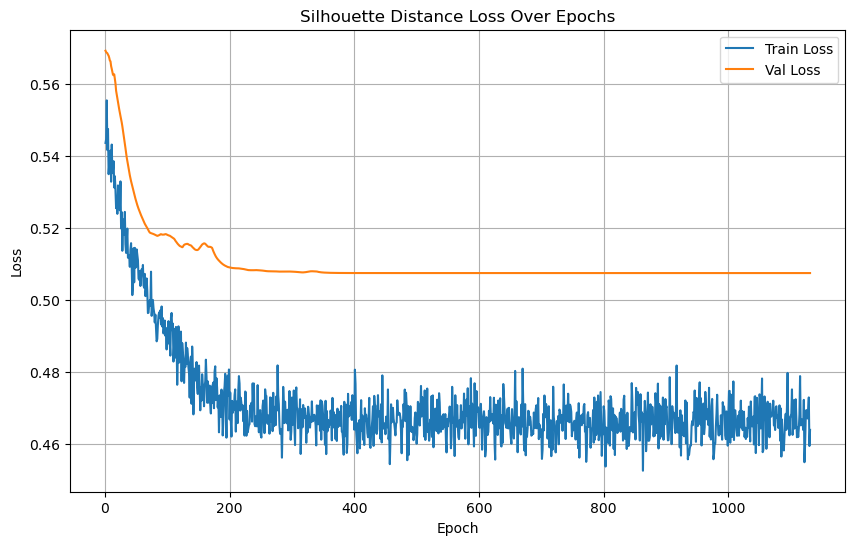

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/80], Loss: 0.2854


Test Batch [20/80], Loss: 0.5000
Test Batch [30/80], Loss: 0.3840
Test Batch [40/80], Loss: 0.2352
Test Batch [50/80], Loss: 0.2603
Test Batch [60/80], Loss: 0.3021
Test Batch [70/80], Loss: 0.4940
Test Batch [80/80], Loss: 0.5000

Test Loss: 0.3132


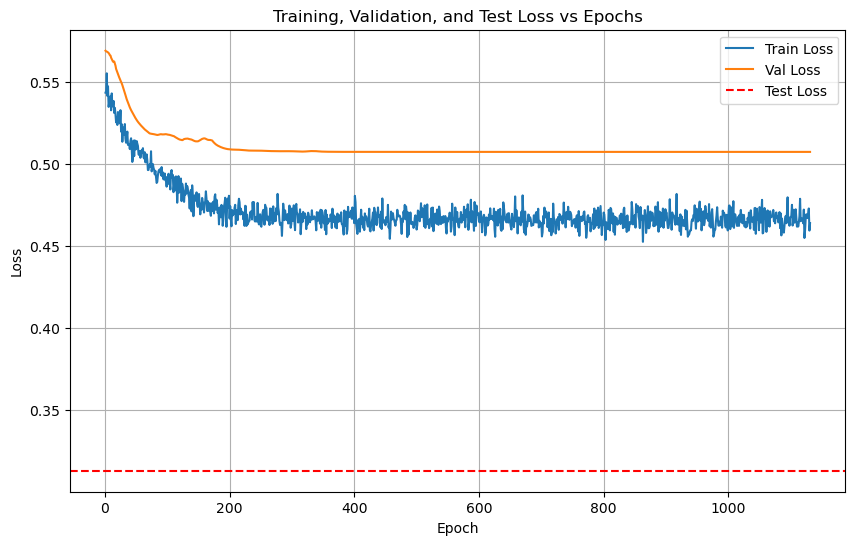

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/80 for test dataset.


  Processed batch 20/80 for test dataset.
  Processed batch 30/80 for test dataset.
  Processed batch 40/80 for test dataset.


  Processed batch 50/80 for test dataset.
  Processed batch 60/80 for test dataset.
  Processed batch 70/80 for test dataset.


  Processed batch 80/80 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (65, 128)
Train labels shape: (65,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (5081, 128)
Test labels shape: (5081,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 43.08%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.60      0.55         5
           1       0.50      0.20      0.29         5
           2       1.00      0.20      0.33         5
           3       0.67      0.80      0.73         5
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         5
           6       0.42      1.00      0.59         5
           7       0.00      0.00      0.00         5
           8       0.27      0.60      0.38         5
           9       0.00      0.00      0.00         5
          10       0.67      0.80      0.73         5
          11       0.50      0.40      0.44         5
          12       0.50      1.00      0.67         5

    accuracy         

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (65, 128)
Train labels shape: (65,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (5081, 128)
Test labels shape: (5081,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6640  |  Val Loss: 2.8079
Validation loss improved from inf to 2.8079.
[Epoch 2/1000] Train Loss: 2.6541  |  Val Loss: 2.7915
Validation loss improved from 2.8079 to 2.7915.
[Epoch 3/1000] Train Loss: 2.6458  |  Val Loss: 2.7760
Validation loss improved from 2.7915 to 2.7760.
[Epoch 4/1000] Train Loss: 2.6381  |  Val Loss: 2.7616
Validation loss improved from 2.7760 to 2.7616.
[Epoch 5/1000] Train Loss: 2.6308  |  Val Loss: 2.7481
Validation loss improved from 2.7616 to 2.7481.
[Epoch 6/1000] Train Loss: 2.6237  |  Val Loss: 2.7356
Validation loss improved from 2.7481 to 2.7356.
[Epoch 7/1000] Train Loss: 2.6169  |  Val Loss: 2.7239
Validation loss improved from 2.7356 to 2.7239.
[Epoch 8/1000] Train Loss: 2.6102  |  Val Loss: 2.7122
Validation loss improved from 2.7239 to 2.7122.
[Epoch 9/1000] Train Loss: 2.6037  |  Val Loss: 2.7018
Validation loss improved from 2.7122 to 2.7018.
[Epoch 10/1000] Train Loss: 2.5974  |  Val Loss: 2.6932
Validation loss impr

[Epoch 27/1000] Train Loss: 2.5314  |  Val Loss: 2.6147
Validation loss improved from 2.6177 to 2.6147.
[Epoch 28/1000] Train Loss: 2.5287  |  Val Loss: 2.6116
Validation loss improved from 2.6147 to 2.6116.
[Epoch 29/1000] Train Loss: 2.5259  |  Val Loss: 2.6071
Validation loss improved from 2.6116 to 2.6071.
[Epoch 30/1000] Train Loss: 2.5226  |  Val Loss: 2.6017
Validation loss improved from 2.6071 to 2.6017.
[Epoch 31/1000] Train Loss: 2.5186  |  Val Loss: 2.5970
Validation loss improved from 2.6017 to 2.5970.
[Epoch 32/1000] Train Loss: 2.5151  |  Val Loss: 2.5928
Validation loss improved from 2.5970 to 2.5928.
[Epoch 33/1000] Train Loss: 2.5119  |  Val Loss: 2.5890
Validation loss improved from 2.5928 to 2.5890.
[Epoch 34/1000] Train Loss: 2.5089  |  Val Loss: 2.5855
Validation loss improved from 2.5890 to 2.5855.
[Epoch 35/1000] Train Loss: 2.5060  |  Val Loss: 2.5823
Validation loss improved from 2.5855 to 2.5823.
[Epoch 36/1000] Train Loss: 2.5031  |  Val Loss: 2.5792
Validati

[Epoch 39/1000] Train Loss: 2.4946  |  Val Loss: 2.5714
Validation loss improved from 2.5738 to 2.5714.
[Epoch 40/1000] Train Loss: 2.4922  |  Val Loss: 2.5691
Validation loss improved from 2.5714 to 2.5691.
[Epoch 41/1000] Train Loss: 2.4893  |  Val Loss: 2.5670
Validation loss improved from 2.5691 to 2.5670.
[Epoch 42/1000] Train Loss: 2.4866  |  Val Loss: 2.5652
Validation loss improved from 2.5670 to 2.5652.
[Epoch 43/1000] Train Loss: 2.4837  |  Val Loss: 2.5633
Validation loss improved from 2.5652 to 2.5633.
[Epoch 44/1000] Train Loss: 2.4812  |  Val Loss: 2.5614
Validation loss improved from 2.5633 to 2.5614.
[Epoch 45/1000] Train Loss: 2.4787  |  Val Loss: 2.5581
Validation loss improved from 2.5614 to 2.5581.
[Epoch 46/1000] Train Loss: 2.4757  |  Val Loss: 2.5537
Validation loss improved from 2.5581 to 2.5537.
[Epoch 47/1000] Train Loss: 2.4720  |  Val Loss: 2.5500
Validation loss improved from 2.5537 to 2.5500.
[Epoch 48/1000] Train Loss: 2.4688  |  Val Loss: 2.5468
Validati

[Epoch 72/1000] Train Loss: 2.4195  |  Val Loss: 2.5050
Validation loss improved from 2.5085 to 2.5050.
[Epoch 73/1000] Train Loss: 2.4171  |  Val Loss: 2.5021
Validation loss improved from 2.5050 to 2.5021.
[Epoch 74/1000] Train Loss: 2.4150  |  Val Loss: 2.4999
Validation loss improved from 2.5021 to 2.4999.
[Epoch 75/1000] Train Loss: 2.4130  |  Val Loss: 2.4980
Validation loss improved from 2.4999 to 2.4980.
[Epoch 76/1000] Train Loss: 2.4112  |  Val Loss: 2.4964
Validation loss improved from 2.4980 to 2.4964.
[Epoch 77/1000] Train Loss: 2.4096  |  Val Loss: 2.4950
Validation loss improved from 2.4964 to 2.4950.
[Epoch 78/1000] Train Loss: 2.4080  |  Val Loss: 2.4929
Validation loss improved from 2.4950 to 2.4929.
[Epoch 79/1000] Train Loss: 2.4058  |  Val Loss: 2.4898
Validation loss improved from 2.4929 to 2.4898.
[Epoch 80/1000] Train Loss: 2.4032  |  Val Loss: 2.4867
Validation loss improved from 2.4898 to 2.4867.
[Epoch 81/1000] Train Loss: 2.4003  |  Val Loss: 2.4844
Validati

[Epoch 83/1000] Train Loss: 2.3944  |  Val Loss: 2.4798
Validation loss improved from 2.4820 to 2.4798.
[Epoch 84/1000] Train Loss: 2.3912  |  Val Loss: 2.4781
Validation loss improved from 2.4798 to 2.4781.
[Epoch 85/1000] Train Loss: 2.3885  |  Val Loss: 2.4766
Validation loss improved from 2.4781 to 2.4766.
[Epoch 86/1000] Train Loss: 2.3862  |  Val Loss: 2.4754
Validation loss improved from 2.4766 to 2.4754.
[Epoch 87/1000] Train Loss: 2.3841  |  Val Loss: 2.4744
Validation loss improved from 2.4754 to 2.4744.
[Epoch 88/1000] Train Loss: 2.3822  |  Val Loss: 2.4736
Validation loss improved from 2.4744 to 2.4736.
[Epoch 89/1000] Train Loss: 2.3805  |  Val Loss: 2.4729
Validation loss improved from 2.4736 to 2.4729.
[Epoch 90/1000] Train Loss: 2.3789  |  Val Loss: 2.4722
Validation loss improved from 2.4729 to 2.4722.
[Epoch 91/1000] Train Loss: 2.3774  |  Val Loss: 2.4716
Validation loss improved from 2.4722 to 2.4716.
[Epoch 92/1000] Train Loss: 2.3760  |  Val Loss: 2.4710
Validati

[Epoch 114/1000] Train Loss: 2.3360  |  Val Loss: 2.4580
Validation loss improved from 2.4585 to 2.4580.
[Epoch 115/1000] Train Loss: 2.3344  |  Val Loss: 2.4575
Validation loss improved from 2.4580 to 2.4575.
[Epoch 116/1000] Train Loss: 2.3330  |  Val Loss: 2.4570
Validation loss improved from 2.4575 to 2.4570.
[Epoch 117/1000] Train Loss: 2.3316  |  Val Loss: 2.4566
Validation loss improved from 2.4570 to 2.4566.
[Epoch 118/1000] Train Loss: 2.3303  |  Val Loss: 2.4562
Validation loss improved from 2.4566 to 2.4562.
[Epoch 119/1000] Train Loss: 2.3290  |  Val Loss: 2.4558
Validation loss improved from 2.4562 to 2.4558.
[Epoch 120/1000] Train Loss: 2.3279  |  Val Loss: 2.4554
Validation loss improved from 2.4558 to 2.4554.
[Epoch 121/1000] Train Loss: 2.3267  |  Val Loss: 2.4550
Validation loss improved from 2.4554 to 2.4550.


[Epoch 122/1000] Train Loss: 2.3255  |  Val Loss: 2.4546
Validation loss improved from 2.4550 to 2.4546.
[Epoch 123/1000] Train Loss: 2.3242  |  Val Loss: 2.4541
Validation loss improved from 2.4546 to 2.4541.
[Epoch 124/1000] Train Loss: 2.3229  |  Val Loss: 2.4536
Validation loss improved from 2.4541 to 2.4536.
[Epoch 125/1000] Train Loss: 2.3216  |  Val Loss: 2.4532
Validation loss improved from 2.4536 to 2.4532.
[Epoch 126/1000] Train Loss: 2.3204  |  Val Loss: 2.4527
Validation loss improved from 2.4532 to 2.4527.
[Epoch 127/1000] Train Loss: 2.3192  |  Val Loss: 2.4523
Validation loss improved from 2.4527 to 2.4523.
[Epoch 128/1000] Train Loss: 2.3179  |  Val Loss: 2.4518
Validation loss improved from 2.4523 to 2.4518.
[Epoch 129/1000] Train Loss: 2.3167  |  Val Loss: 2.4514
Validation loss improved from 2.4518 to 2.4514.
[Epoch 130/1000] Train Loss: 2.3155  |  Val Loss: 2.4508
Validation loss improved from 2.4514 to 2.4508.
[Epoch 131/1000] Train Loss: 2.3142  |  Val Loss: 2.450

[Epoch 155/1000] Train Loss: 2.2796  |  Val Loss: 2.4395
Validation loss improved from 2.4402 to 2.4395.
[Epoch 156/1000] Train Loss: 2.2782  |  Val Loss: 2.4389
Validation loss improved from 2.4395 to 2.4389.
[Epoch 157/1000] Train Loss: 2.2767  |  Val Loss: 2.4383
Validation loss improved from 2.4389 to 2.4383.
[Epoch 158/1000] Train Loss: 2.2753  |  Val Loss: 2.4376
Validation loss improved from 2.4383 to 2.4376.
[Epoch 159/1000] Train Loss: 2.2739  |  Val Loss: 2.4370
Validation loss improved from 2.4376 to 2.4370.
[Epoch 160/1000] Train Loss: 2.2725  |  Val Loss: 2.4363
Validation loss improved from 2.4370 to 2.4363.


[Epoch 161/1000] Train Loss: 2.2710  |  Val Loss: 2.4355
Validation loss improved from 2.4363 to 2.4355.
[Epoch 162/1000] Train Loss: 2.2693  |  Val Loss: 2.4348
Validation loss improved from 2.4355 to 2.4348.
[Epoch 163/1000] Train Loss: 2.2678  |  Val Loss: 2.4342
Validation loss improved from 2.4348 to 2.4342.
[Epoch 164/1000] Train Loss: 2.2662  |  Val Loss: 2.4335
Validation loss improved from 2.4342 to 2.4335.
[Epoch 165/1000] Train Loss: 2.2646  |  Val Loss: 2.4329
Validation loss improved from 2.4335 to 2.4329.
[Epoch 166/1000] Train Loss: 2.2631  |  Val Loss: 2.4322
Validation loss improved from 2.4329 to 2.4322.
[Epoch 167/1000] Train Loss: 2.2616  |  Val Loss: 2.4315
Validation loss improved from 2.4322 to 2.4315.
[Epoch 168/1000] Train Loss: 2.2599  |  Val Loss: 2.4307
Validation loss improved from 2.4315 to 2.4307.
[Epoch 169/1000] Train Loss: 2.2581  |  Val Loss: 2.4297
Validation loss improved from 2.4307 to 2.4297.
[Epoch 170/1000] Train Loss: 2.2562  |  Val Loss: 2.428

[Epoch 197/1000] Train Loss: 2.2034  |  Val Loss: 2.4124
Validation loss improved from 2.4126 to 2.4124.
[Epoch 198/1000] Train Loss: 2.2018  |  Val Loss: 2.4122
Validation loss improved from 2.4124 to 2.4122.
[Epoch 199/1000] Train Loss: 2.2002  |  Val Loss: 2.4119
Validation loss improved from 2.4122 to 2.4119.
[Epoch 200/1000] Train Loss: 2.1986  |  Val Loss: 2.4116
Validation loss improved from 2.4119 to 2.4116.
[Epoch 201/1000] Train Loss: 2.1969  |  Val Loss: 2.4113
Validation loss improved from 2.4116 to 2.4113.
[Epoch 202/1000] Train Loss: 2.1953  |  Val Loss: 2.4108
Validation loss improved from 2.4113 to 2.4108.
[Epoch 203/1000] Train Loss: 2.1934  |  Val Loss: 2.4101
Validation loss improved from 2.4108 to 2.4101.
[Epoch 204/1000] Train Loss: 2.1913  |  Val Loss: 2.4095
Validation loss improved from 2.4101 to 2.4095.
[Epoch 205/1000] Train Loss: 2.1891  |  Val Loss: 2.4089
Validation loss improved from 2.4095 to 2.4089.


[Epoch 206/1000] Train Loss: 2.1871  |  Val Loss: 2.4085
Validation loss improved from 2.4089 to 2.4085.
[Epoch 207/1000] Train Loss: 2.1853  |  Val Loss: 2.4081
Validation loss improved from 2.4085 to 2.4081.
[Epoch 208/1000] Train Loss: 2.1835  |  Val Loss: 2.4077
Validation loss improved from 2.4081 to 2.4077.
[Epoch 209/1000] Train Loss: 2.1818  |  Val Loss: 2.4077
Validation loss improved from 2.4077 to 2.4077.
[Epoch 210/1000] Train Loss: 2.1797  |  Val Loss: 2.4079
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 211/1000] Train Loss: 2.1771  |  Val Loss: 2.4079
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 212/1000] Train Loss: 2.1744  |  Val Loss: 2.4082
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 213/1000] Train Loss: 2.1718  |  Val Loss: 2.4086
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 214/1000] Train Loss: 2.1689  |  Val Loss: 2.4089
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 215/1000] Train Lo

[Epoch 238/1000] Train Loss: 2.1243  |  Val Loss: 2.4135
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 239/1000] Train Loss: 2.1221  |  Val Loss: 2.4143
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 240/1000] Train Loss: 2.1199  |  Val Loss: 2.4150
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 241/1000] Train Loss: 2.1180  |  Val Loss: 2.4155
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 242/1000] Train Loss: 2.1163  |  Val Loss: 2.4159
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 243/1000] Train Loss: 2.1147  |  Val Loss: 2.4163
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 244/1000] Train Loss: 2.1132  |  Val Loss: 2.4164
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 245/1000] Train Loss: 2.1118  |  Val Loss: 2.4165
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 246/1000] Train Loss: 2.1103  |  Val Loss: 2.4165
!! Validation loss did NOT improve !! Patience:

[Epoch 250/1000] Train Loss: 2.1044  |  Val Loss: 2.4156
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 251/1000] Train Loss: 2.1029  |  Val Loss: 2.4151
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 252/1000] Train Loss: 2.1015  |  Val Loss: 2.4147
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 253/1000] Train Loss: 2.1001  |  Val Loss: 2.4147
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 254/1000] Train Loss: 2.0987  |  Val Loss: 2.4150
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 255/1000] Train Loss: 2.0972  |  Val Loss: 2.4151
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 256/1000] Train Loss: 2.0957  |  Val Loss: 2.4152
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 257/1000] Train Loss: 2.0941  |  Val Loss: 2.4153
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 258/1000] Train Loss: 2.0927  |  Val Loss: 2.4153
!! Validation loss did NOT improve !! Patience:

[Epoch 272/1000] Train Loss: 2.0764  |  Val Loss: 2.4173
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 273/1000] Train Loss: 2.0754  |  Val Loss: 2.4170
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 274/1000] Train Loss: 2.0744  |  Val Loss: 2.4166
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 275/1000] Train Loss: 2.0734  |  Val Loss: 2.4162
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 276/1000] Train Loss: 2.0722  |  Val Loss: 2.4161
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 277/1000] Train Loss: 2.0709  |  Val Loss: 2.4163
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 278/1000] Train Loss: 2.0695  |  Val Loss: 2.4164
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 279/1000] Train Loss: 2.0682  |  Val Loss: 2.4164
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 280/1000] Train Loss: 2.0669  |  Val Loss: 2.4162
!! Validation loss did NOT improve !! Patience:

[Epoch 290/1000] Train Loss: 2.0543  |  Val Loss: 2.4118
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 291/1000] Train Loss: 2.0530  |  Val Loss: 2.4113
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 292/1000] Train Loss: 2.0517  |  Val Loss: 2.4108
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 293/1000] Train Loss: 2.0505  |  Val Loss: 2.4103
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 294/1000] Train Loss: 2.0494  |  Val Loss: 2.4097
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 295/1000] Train Loss: 2.0482  |  Val Loss: 2.4089
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 296/1000] Train Loss: 2.0471  |  Val Loss: 2.4081
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 297/1000] Train Loss: 2.0460  |  Val Loss: 2.4074
Validation loss improved from 2.4077 to 2.4074.
[Epoch 298/1000] Train Loss: 2.0449  |  Val Loss: 2.4067
Validation loss improved from 2.4074 to 2.4067.
[Epoch

[Epoch 313/1000] Train Loss: 2.0259  |  Val Loss: 2.3943
Validation loss improved from 2.3944 to 2.3943.
[Epoch 314/1000] Train Loss: 2.0248  |  Val Loss: 2.3942
Validation loss improved from 2.3943 to 2.3942.
[Epoch 315/1000] Train Loss: 2.0238  |  Val Loss: 2.3941
Validation loss improved from 2.3942 to 2.3941.
[Epoch 316/1000] Train Loss: 2.0227  |  Val Loss: 2.3936
Validation loss improved from 2.3941 to 2.3936.
[Epoch 317/1000] Train Loss: 2.0214  |  Val Loss: 2.3929
Validation loss improved from 2.3936 to 2.3929.
[Epoch 318/1000] Train Loss: 2.0200  |  Val Loss: 2.3922
Validation loss improved from 2.3929 to 2.3922.
[Epoch 319/1000] Train Loss: 2.0188  |  Val Loss: 2.3916
Validation loss improved from 2.3922 to 2.3916.
[Epoch 320/1000] Train Loss: 2.0177  |  Val Loss: 2.3910
Validation loss improved from 2.3916 to 2.3910.
[Epoch 321/1000] Train Loss: 2.0166  |  Val Loss: 2.3905
Validation loss improved from 2.3910 to 2.3905.
[Epoch 322/1000] Train Loss: 2.0154  |  Val Loss: 2.389

[Epoch 333/1000] Train Loss: 2.0011  |  Val Loss: 2.3845
Validation loss improved from 2.3851 to 2.3845.
[Epoch 334/1000] Train Loss: 1.9998  |  Val Loss: 2.3838
Validation loss improved from 2.3845 to 2.3838.
[Epoch 335/1000] Train Loss: 1.9982  |  Val Loss: 2.3831
Validation loss improved from 2.3838 to 2.3831.
[Epoch 336/1000] Train Loss: 1.9966  |  Val Loss: 2.3822
Validation loss improved from 2.3831 to 2.3822.
[Epoch 337/1000] Train Loss: 1.9951  |  Val Loss: 2.3813
Validation loss improved from 2.3822 to 2.3813.
[Epoch 338/1000] Train Loss: 1.9935  |  Val Loss: 2.3803
Validation loss improved from 2.3813 to 2.3803.
[Epoch 339/1000] Train Loss: 1.9921  |  Val Loss: 2.3794
Validation loss improved from 2.3803 to 2.3794.
[Epoch 340/1000] Train Loss: 1.9907  |  Val Loss: 2.3786
Validation loss improved from 2.3794 to 2.3786.
[Epoch 341/1000] Train Loss: 1.9892  |  Val Loss: 2.3773
Validation loss improved from 2.3786 to 2.3773.
[Epoch 342/1000] Train Loss: 1.9875  |  Val Loss: 2.375

[Epoch 348/1000] Train Loss: 1.9782  |  Val Loss: 2.3673
Validation loss improved from 2.3685 to 2.3673.
[Epoch 349/1000] Train Loss: 1.9769  |  Val Loss: 2.3664
Validation loss improved from 2.3673 to 2.3664.
[Epoch 350/1000] Train Loss: 1.9756  |  Val Loss: 2.3656
Validation loss improved from 2.3664 to 2.3656.
[Epoch 351/1000] Train Loss: 1.9745  |  Val Loss: 2.3648
Validation loss improved from 2.3656 to 2.3648.
[Epoch 352/1000] Train Loss: 1.9733  |  Val Loss: 2.3638
Validation loss improved from 2.3648 to 2.3638.
[Epoch 353/1000] Train Loss: 1.9720  |  Val Loss: 2.3625
Validation loss improved from 2.3638 to 2.3625.
[Epoch 354/1000] Train Loss: 1.9708  |  Val Loss: 2.3611
Validation loss improved from 2.3625 to 2.3611.
[Epoch 355/1000] Train Loss: 1.9695  |  Val Loss: 2.3599
Validation loss improved from 2.3611 to 2.3599.
[Epoch 356/1000] Train Loss: 1.9683  |  Val Loss: 2.3588
Validation loss improved from 2.3599 to 2.3588.
[Epoch 357/1000] Train Loss: 1.9670  |  Val Loss: 2.357

[Epoch 377/1000] Train Loss: 1.9388  |  Val Loss: 2.3388
Validation loss improved from 2.3393 to 2.3388.
[Epoch 378/1000] Train Loss: 1.9376  |  Val Loss: 2.3383
Validation loss improved from 2.3388 to 2.3383.
[Epoch 379/1000] Train Loss: 1.9366  |  Val Loss: 2.3377
Validation loss improved from 2.3383 to 2.3377.
[Epoch 380/1000] Train Loss: 1.9356  |  Val Loss: 2.3371
Validation loss improved from 2.3377 to 2.3371.
[Epoch 381/1000] Train Loss: 1.9345  |  Val Loss: 2.3364
Validation loss improved from 2.3371 to 2.3364.
[Epoch 382/1000] Train Loss: 1.9333  |  Val Loss: 2.3357
Validation loss improved from 2.3364 to 2.3357.
[Epoch 383/1000] Train Loss: 1.9320  |  Val Loss: 2.3350
Validation loss improved from 2.3357 to 2.3350.
[Epoch 384/1000] Train Loss: 1.9306  |  Val Loss: 2.3342
Validation loss improved from 2.3350 to 2.3342.
[Epoch 385/1000] Train Loss: 1.9292  |  Val Loss: 2.3332
Validation loss improved from 2.3342 to 2.3332.
[Epoch 386/1000] Train Loss: 1.9275  |  Val Loss: 2.332

[Epoch 393/1000] Train Loss: 1.9179  |  Val Loss: 2.3261
Validation loss improved from 2.3267 to 2.3261.
[Epoch 394/1000] Train Loss: 1.9167  |  Val Loss: 2.3253
Validation loss improved from 2.3261 to 2.3253.
[Epoch 395/1000] Train Loss: 1.9155  |  Val Loss: 2.3245
Validation loss improved from 2.3253 to 2.3245.
[Epoch 396/1000] Train Loss: 1.9143  |  Val Loss: 2.3237
Validation loss improved from 2.3245 to 2.3237.
[Epoch 397/1000] Train Loss: 1.9130  |  Val Loss: 2.3229
Validation loss improved from 2.3237 to 2.3229.
[Epoch 398/1000] Train Loss: 1.9119  |  Val Loss: 2.3223
Validation loss improved from 2.3229 to 2.3223.
[Epoch 399/1000] Train Loss: 1.9106  |  Val Loss: 2.3222
Validation loss improved from 2.3223 to 2.3222.
[Epoch 400/1000] Train Loss: 1.9094  |  Val Loss: 2.3221
Validation loss improved from 2.3222 to 2.3221.
[Epoch 401/1000] Train Loss: 1.9081  |  Val Loss: 2.3224
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 402/1000] Train Loss: 1.9068  |  Val Loss:

[Epoch 420/1000] Train Loss: 1.8826  |  Val Loss: 2.3107
Validation loss improved from 2.3115 to 2.3107.
[Epoch 421/1000] Train Loss: 1.8810  |  Val Loss: 2.3099
Validation loss improved from 2.3107 to 2.3099.
[Epoch 422/1000] Train Loss: 1.8794  |  Val Loss: 2.3092
Validation loss improved from 2.3099 to 2.3092.
[Epoch 423/1000] Train Loss: 1.8779  |  Val Loss: 2.3084
Validation loss improved from 2.3092 to 2.3084.
[Epoch 424/1000] Train Loss: 1.8764  |  Val Loss: 2.3077
Validation loss improved from 2.3084 to 2.3077.
[Epoch 425/1000] Train Loss: 1.8750  |  Val Loss: 2.3069
Validation loss improved from 2.3077 to 2.3069.
[Epoch 426/1000] Train Loss: 1.8736  |  Val Loss: 2.3060
Validation loss improved from 2.3069 to 2.3060.
[Epoch 427/1000] Train Loss: 1.8723  |  Val Loss: 2.3051
Validation loss improved from 2.3060 to 2.3051.
[Epoch 428/1000] Train Loss: 1.8709  |  Val Loss: 2.3042
Validation loss improved from 2.3051 to 2.3042.
[Epoch 429/1000] Train Loss: 1.8697  |  Val Loss: 2.303

[Epoch 438/1000] Train Loss: 1.8565  |  Val Loss: 2.2962
Validation loss improved from 2.2970 to 2.2962.
[Epoch 439/1000] Train Loss: 1.8551  |  Val Loss: 2.2953
Validation loss improved from 2.2962 to 2.2953.
[Epoch 440/1000] Train Loss: 1.8537  |  Val Loss: 2.2945
Validation loss improved from 2.2953 to 2.2945.
[Epoch 441/1000] Train Loss: 1.8523  |  Val Loss: 2.2941
Validation loss improved from 2.2945 to 2.2941.
[Epoch 442/1000] Train Loss: 1.8510  |  Val Loss: 2.2940
Validation loss improved from 2.2941 to 2.2940.
[Epoch 443/1000] Train Loss: 1.8495  |  Val Loss: 2.2936
Validation loss improved from 2.2940 to 2.2936.
[Epoch 444/1000] Train Loss: 1.8480  |  Val Loss: 2.2933
Validation loss improved from 2.2936 to 2.2933.
[Epoch 445/1000] Train Loss: 1.8465  |  Val Loss: 2.2928
Validation loss improved from 2.2933 to 2.2928.
[Epoch 446/1000] Train Loss: 1.8450  |  Val Loss: 2.2923
Validation loss improved from 2.2928 to 2.2923.
[Epoch 447/1000] Train Loss: 1.8435  |  Val Loss: 2.291

[Epoch 460/1000] Train Loss: 1.8217  |  Val Loss: 2.2832
Validation loss improved from 2.2837 to 2.2832.
[Epoch 461/1000] Train Loss: 1.8200  |  Val Loss: 2.2830
Validation loss improved from 2.2832 to 2.2830.
[Epoch 462/1000] Train Loss: 1.8183  |  Val Loss: 2.2828
Validation loss improved from 2.2830 to 2.2828.
[Epoch 463/1000] Train Loss: 1.8167  |  Val Loss: 2.2828
Validation loss improved from 2.2828 to 2.2828.
[Epoch 464/1000] Train Loss: 1.8151  |  Val Loss: 2.2827
Validation loss improved from 2.2828 to 2.2827.
[Epoch 465/1000] Train Loss: 1.8135  |  Val Loss: 2.2826
Validation loss improved from 2.2827 to 2.2826.
[Epoch 466/1000] Train Loss: 1.8118  |  Val Loss: 2.2822
Validation loss improved from 2.2826 to 2.2822.
[Epoch 467/1000] Train Loss: 1.8102  |  Val Loss: 2.2817
Validation loss improved from 2.2822 to 2.2817.
[Epoch 468/1000] Train Loss: 1.8086  |  Val Loss: 2.2812
Validation loss improved from 2.2817 to 2.2812.
[Epoch 469/1000] Train Loss: 1.8071  |  Val Loss: 2.280

[Epoch 478/1000] Train Loss: 1.7942  |  Val Loss: 2.2734
Validation loss improved from 2.2742 to 2.2734.
[Epoch 479/1000] Train Loss: 1.7927  |  Val Loss: 2.2729
Validation loss improved from 2.2734 to 2.2729.
[Epoch 480/1000] Train Loss: 1.7912  |  Val Loss: 2.2726
Validation loss improved from 2.2729 to 2.2726.
[Epoch 481/1000] Train Loss: 1.7897  |  Val Loss: 2.2724
Validation loss improved from 2.2726 to 2.2724.
[Epoch 482/1000] Train Loss: 1.7880  |  Val Loss: 2.2719
Validation loss improved from 2.2724 to 2.2719.
[Epoch 483/1000] Train Loss: 1.7861  |  Val Loss: 2.2715
Validation loss improved from 2.2719 to 2.2715.
[Epoch 484/1000] Train Loss: 1.7843  |  Val Loss: 2.2711
Validation loss improved from 2.2715 to 2.2711.
[Epoch 485/1000] Train Loss: 1.7825  |  Val Loss: 2.2705
Validation loss improved from 2.2711 to 2.2705.
[Epoch 486/1000] Train Loss: 1.7807  |  Val Loss: 2.2699
Validation loss improved from 2.2705 to 2.2699.
[Epoch 487/1000] Train Loss: 1.7789  |  Val Loss: 2.269

[Epoch 496/1000] Train Loss: 1.7659  |  Val Loss: 2.2693
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 497/1000] Train Loss: 1.7645  |  Val Loss: 2.2692
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 498/1000] Train Loss: 1.7632  |  Val Loss: 2.2697
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 499/1000] Train Loss: 1.7620  |  Val Loss: 2.2705
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 500/1000] Train Loss: 1.7607  |  Val Loss: 2.2707
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 501/1000] Train Loss: 1.7595  |  Val Loss: 2.2706
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 502/1000] Train Loss: 1.7583  |  Val Loss: 2.2705
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 503/1000] Train Loss: 1.7571  |  Val Loss: 2.2705
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 504/1000] Train Loss: 1.7558  |  Val Loss: 2.2703
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 514/1000] Train Loss: 1.7405  |  Val Loss: 2.2633
Validation loss improved from 2.2648 to 2.2633.
[Epoch 515/1000] Train Loss: 1.7390  |  Val Loss: 2.2620
Validation loss improved from 2.2633 to 2.2620.
[Epoch 516/1000] Train Loss: 1.7375  |  Val Loss: 2.2607
Validation loss improved from 2.2620 to 2.2607.
[Epoch 517/1000] Train Loss: 1.7358  |  Val Loss: 2.2596
Validation loss improved from 2.2607 to 2.2596.
[Epoch 518/1000] Train Loss: 1.7342  |  Val Loss: 2.2585
Validation loss improved from 2.2596 to 2.2585.
[Epoch 519/1000] Train Loss: 1.7327  |  Val Loss: 2.2569
Validation loss improved from 2.2585 to 2.2569.
[Epoch 520/1000] Train Loss: 1.7313  |  Val Loss: 2.2551
Validation loss improved from 2.2569 to 2.2551.
[Epoch 521/1000] Train Loss: 1.7299  |  Val Loss: 2.2535
Validation loss improved from 2.2551 to 2.2535.
[Epoch 522/1000] Train Loss: 1.7285  |  Val Loss: 2.2521
Validation loss improved from 2.2535 to 2.2521.
[Epoch 523/1000] Train Loss: 1.7272  |  Val Loss: 2.250

[Epoch 533/1000] Train Loss: 1.7128  |  Val Loss: 2.2452
Validation loss improved from 2.2459 to 2.2452.
[Epoch 534/1000] Train Loss: 1.7110  |  Val Loss: 2.2445
Validation loss improved from 2.2452 to 2.2445.
[Epoch 535/1000] Train Loss: 1.7094  |  Val Loss: 2.2436
Validation loss improved from 2.2445 to 2.2436.
[Epoch 536/1000] Train Loss: 1.7077  |  Val Loss: 2.2425
Validation loss improved from 2.2436 to 2.2425.
[Epoch 537/1000] Train Loss: 1.7059  |  Val Loss: 2.2413
Validation loss improved from 2.2425 to 2.2413.
[Epoch 538/1000] Train Loss: 1.7041  |  Val Loss: 2.2400
Validation loss improved from 2.2413 to 2.2400.
[Epoch 539/1000] Train Loss: 1.7024  |  Val Loss: 2.2388
Validation loss improved from 2.2400 to 2.2388.
[Epoch 540/1000] Train Loss: 1.7007  |  Val Loss: 2.2377
Validation loss improved from 2.2388 to 2.2377.
[Epoch 541/1000] Train Loss: 1.6992  |  Val Loss: 2.2366
Validation loss improved from 2.2377 to 2.2366.
[Epoch 542/1000] Train Loss: 1.6977  |  Val Loss: 2.235

[Epoch 551/1000] Train Loss: 1.6822  |  Val Loss: 2.2340
Validation loss improved from 2.2341 to 2.2340.
[Epoch 552/1000] Train Loss: 1.6806  |  Val Loss: 2.2335
Validation loss improved from 2.2340 to 2.2335.
[Epoch 553/1000] Train Loss: 1.6791  |  Val Loss: 2.2330
Validation loss improved from 2.2335 to 2.2330.
[Epoch 554/1000] Train Loss: 1.6776  |  Val Loss: 2.2327
Validation loss improved from 2.2330 to 2.2327.
[Epoch 555/1000] Train Loss: 1.6761  |  Val Loss: 2.2330
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 556/1000] Train Loss: 1.6747  |  Val Loss: 2.2331
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 557/1000] Train Loss: 1.6733  |  Val Loss: 2.2329
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 558/1000] Train Loss: 1.6720  |  Val Loss: 2.2325
Validation loss improved from 2.2327 to 2.2325.
[Epoch 559/1000] Train Loss: 1.6706  |  Val Loss: 2.2318
Validation loss improved from 2.2325 to 2.2318.
[Epoch 560/1000] Train Loss: 1.6692  

[Epoch 574/1000] Train Loss: 1.6478  |  Val Loss: 2.2239
Validation loss improved from 2.2245 to 2.2239.
[Epoch 575/1000] Train Loss: 1.6463  |  Val Loss: 2.2233
Validation loss improved from 2.2239 to 2.2233.
[Epoch 576/1000] Train Loss: 1.6447  |  Val Loss: 2.2226
Validation loss improved from 2.2233 to 2.2226.
[Epoch 577/1000] Train Loss: 1.6431  |  Val Loss: 2.2218
Validation loss improved from 2.2226 to 2.2218.
[Epoch 578/1000] Train Loss: 1.6416  |  Val Loss: 2.2209
Validation loss improved from 2.2218 to 2.2209.
[Epoch 579/1000] Train Loss: 1.6400  |  Val Loss: 2.2200
Validation loss improved from 2.2209 to 2.2200.
[Epoch 580/1000] Train Loss: 1.6384  |  Val Loss: 2.2190
Validation loss improved from 2.2200 to 2.2190.
[Epoch 581/1000] Train Loss: 1.6368  |  Val Loss: 2.2181
Validation loss improved from 2.2190 to 2.2181.
[Epoch 582/1000] Train Loss: 1.6352  |  Val Loss: 2.2173
Validation loss improved from 2.2181 to 2.2173.
[Epoch 583/1000] Train Loss: 1.6336  |  Val Loss: 2.216

[Epoch 593/1000] Train Loss: 1.6168  |  Val Loss: 2.2103
Validation loss improved from 2.2125 to 2.2103.
[Epoch 594/1000] Train Loss: 1.6151  |  Val Loss: 2.2080
Validation loss improved from 2.2103 to 2.2080.
[Epoch 595/1000] Train Loss: 1.6133  |  Val Loss: 2.2054
Validation loss improved from 2.2080 to 2.2054.
[Epoch 596/1000] Train Loss: 1.6118  |  Val Loss: 2.2025
Validation loss improved from 2.2054 to 2.2025.
[Epoch 597/1000] Train Loss: 1.6101  |  Val Loss: 2.2001
Validation loss improved from 2.2025 to 2.2001.
[Epoch 598/1000] Train Loss: 1.6086  |  Val Loss: 2.1981
Validation loss improved from 2.2001 to 2.1981.
[Epoch 599/1000] Train Loss: 1.6070  |  Val Loss: 2.1962
Validation loss improved from 2.1981 to 2.1962.
[Epoch 600/1000] Train Loss: 1.6055  |  Val Loss: 2.1944
Validation loss improved from 2.1962 to 2.1944.
[Epoch 601/1000] Train Loss: 1.6040  |  Val Loss: 2.1926
Validation loss improved from 2.1944 to 2.1926.
[Epoch 602/1000] Train Loss: 1.6025  |  Val Loss: 2.191

[Epoch 617/1000] Train Loss: 1.5792  |  Val Loss: 2.1854
Validation loss improved from 2.1870 to 2.1854.
[Epoch 618/1000] Train Loss: 1.5777  |  Val Loss: 2.1840
Validation loss improved from 2.1854 to 2.1840.
[Epoch 619/1000] Train Loss: 1.5762  |  Val Loss: 2.1827
Validation loss improved from 2.1840 to 2.1827.
[Epoch 620/1000] Train Loss: 1.5747  |  Val Loss: 2.1815
Validation loss improved from 2.1827 to 2.1815.
[Epoch 621/1000] Train Loss: 1.5732  |  Val Loss: 2.1811
Validation loss improved from 2.1815 to 2.1811.
[Epoch 622/1000] Train Loss: 1.5716  |  Val Loss: 2.1812
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 623/1000] Train Loss: 1.5700  |  Val Loss: 2.1811
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 624/1000] Train Loss: 1.5684  |  Val Loss: 2.1810
Validation loss improved from 2.1811 to 2.1810.
[Epoch 625/1000] Train Loss: 1.5668  |  Val Loss: 2.1806
Validation loss improved from 2.1810 to 2.1806.
[Epoch 626/1000] Train Loss: 1.5652  |  Val

[Epoch 633/1000] Train Loss: 1.5534  |  Val Loss: 2.1754
Validation loss improved from 2.1763 to 2.1754.
[Epoch 634/1000] Train Loss: 1.5516  |  Val Loss: 2.1752
Validation loss improved from 2.1754 to 2.1752.
[Epoch 635/1000] Train Loss: 1.5498  |  Val Loss: 2.1756
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 636/1000] Train Loss: 1.5481  |  Val Loss: 2.1760
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 637/1000] Train Loss: 1.5465  |  Val Loss: 2.1760
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 638/1000] Train Loss: 1.5450  |  Val Loss: 2.1758
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 639/1000] Train Loss: 1.5435  |  Val Loss: 2.1750
Validation loss improved from 2.1752 to 2.1750.
[Epoch 640/1000] Train Loss: 1.5416  |  Val Loss: 2.1739
Validation loss improved from 2.1750 to 2.1739.
[Epoch 641/1000] Train Loss: 1.5398  |  Val Loss: 2.1727
Validation loss improved from 2.1739 to 2.1727.
[Epoch 642/1000] Train Loss: 1.

[Epoch 655/1000] Train Loss: 1.5172  |  Val Loss: 2.1677
Validation loss improved from 2.1681 to 2.1677.
[Epoch 656/1000] Train Loss: 1.5155  |  Val Loss: 2.1679
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 657/1000] Train Loss: 1.5137  |  Val Loss: 2.1688
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 658/1000] Train Loss: 1.5120  |  Val Loss: 2.1703
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 659/1000] Train Loss: 1.5104  |  Val Loss: 2.1721
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 660/1000] Train Loss: 1.5088  |  Val Loss: 2.1742
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 661/1000] Train Loss: 1.5074  |  Val Loss: 2.1773
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 662/1000] Train Loss: 1.5060  |  Val Loss: 2.1809
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 663/1000] Train Loss: 1.5048  |  Val Loss: 2.1839
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 670/1000] Train Loss: 1.4946  |  Val Loss: 2.1926
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 671/1000] Train Loss: 1.4931  |  Val Loss: 2.1940
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 672/1000] Train Loss: 1.4917  |  Val Loss: 2.1952
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 673/1000] Train Loss: 1.4903  |  Val Loss: 2.1971
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 674/1000] Train Loss: 1.4888  |  Val Loss: 2.1991
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 675/1000] Train Loss: 1.4874  |  Val Loss: 2.2004
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 676/1000] Train Loss: 1.4859  |  Val Loss: 2.2022
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 677/1000] Train Loss: 1.4845  |  Val Loss: 2.2050
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 678/1000] Train Loss: 1.4833  |  Val Loss: 2.2076
!! Validation loss did NOT improve !! Patience:

[Epoch 692/1000] Train Loss: 1.4594  |  Val Loss: 2.1977
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 693/1000] Train Loss: 1.4578  |  Val Loss: 2.1962
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 694/1000] Train Loss: 1.4563  |  Val Loss: 2.1947
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 695/1000] Train Loss: 1.4548  |  Val Loss: 2.1935
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 696/1000] Train Loss: 1.4533  |  Val Loss: 2.1919
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 697/1000] Train Loss: 1.4517  |  Val Loss: 2.1901
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 698/1000] Train Loss: 1.4500  |  Val Loss: 2.1885
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 699/1000] Train Loss: 1.4483  |  Val Loss: 2.1866
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 700/1000] Train Loss: 1.4466  |  Val Loss: 2.1845
!! Validation loss did NOT improve !! Patience:

[Epoch 712/1000] Train Loss: 1.4295  |  Val Loss: 2.1724
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 713/1000] Train Loss: 1.4280  |  Val Loss: 2.1721
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 714/1000] Train Loss: 1.4265  |  Val Loss: 2.1717
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 715/1000] Train Loss: 1.4250  |  Val Loss: 2.1715
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 716/1000] Train Loss: 1.4235  |  Val Loss: 2.1708
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 717/1000] Train Loss: 1.4220  |  Val Loss: 2.1697
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 718/1000] Train Loss: 1.4203  |  Val Loss: 2.1686
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 719/1000] Train Loss: 1.4186  |  Val Loss: 2.1676
Validation loss improved from 2.1677 to 2.1676.
[Epoch 720/1000] Train Loss: 1.4170  |  Val Loss: 2.1668
Validation loss improved from 2.1676 to 2.1668.
[Epoch

[Epoch 734/1000] Train Loss: 1.3998  |  Val Loss: 2.1741
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 735/1000] Train Loss: 1.3989  |  Val Loss: 2.1718
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 736/1000] Train Loss: 1.3978  |  Val Loss: 2.1696
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 737/1000] Train Loss: 1.3966  |  Val Loss: 2.1680
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 738/1000] Train Loss: 1.3956  |  Val Loss: 2.1669
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 739/1000] Train Loss: 1.3947  |  Val Loss: 2.1654
Validation loss improved from 2.1668 to 2.1654.
[Epoch 740/1000] Train Loss: 1.3935  |  Val Loss: 2.1635
Validation loss improved from 2.1654 to 2.1635.
[Epoch 741/1000] Train Loss: 1.3923  |  Val Loss: 2.1620
Validation loss improved from 2.1635 to 2.1620.
[Epoch 742/1000] Train Loss: 1.3913  |  Val Loss: 2.1614
Validation loss improved from 2.1620 to 2.1614.
[Epoch 743/1000] Tra

[Epoch 755/1000] Train Loss: 1.3761  |  Val Loss: 2.1456
Validation loss improved from 2.1476 to 2.1456.
[Epoch 756/1000] Train Loss: 1.3746  |  Val Loss: 2.1435
Validation loss improved from 2.1456 to 2.1435.
[Epoch 757/1000] Train Loss: 1.3730  |  Val Loss: 2.1418
Validation loss improved from 2.1435 to 2.1418.
[Epoch 758/1000] Train Loss: 1.3715  |  Val Loss: 2.1403
Validation loss improved from 2.1418 to 2.1403.
[Epoch 759/1000] Train Loss: 1.3700  |  Val Loss: 2.1389
Validation loss improved from 2.1403 to 2.1389.
[Epoch 760/1000] Train Loss: 1.3684  |  Val Loss: 2.1379
Validation loss improved from 2.1389 to 2.1379.
[Epoch 761/1000] Train Loss: 1.3668  |  Val Loss: 2.1371
Validation loss improved from 2.1379 to 2.1371.
[Epoch 762/1000] Train Loss: 1.3651  |  Val Loss: 2.1362
Validation loss improved from 2.1371 to 2.1362.
[Epoch 763/1000] Train Loss: 1.3635  |  Val Loss: 2.1351
Validation loss improved from 2.1362 to 2.1351.
[Epoch 764/1000] Train Loss: 1.3621  |  Val Loss: 2.134

[Epoch 778/1000] Train Loss: 1.3478  |  Val Loss: 2.1337
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 779/1000] Train Loss: 1.3469  |  Val Loss: 2.1338
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 780/1000] Train Loss: 1.3461  |  Val Loss: 2.1340
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 781/1000] Train Loss: 1.3453  |  Val Loss: 2.1345
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 782/1000] Train Loss: 1.3445  |  Val Loss: 2.1350
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 783/1000] Train Loss: 1.3437  |  Val Loss: 2.1353
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 784/1000] Train Loss: 1.3429  |  Val Loss: 2.1355
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 785/1000] Train Loss: 1.3421  |  Val Loss: 2.1355
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 786/1000] Train Loss: 1.3412  |  Val Loss: 2.1352
!! Validation loss did NOT improve !! Patience: 1

[Epoch 802/1000] Train Loss: 1.3193  |  Val Loss: 2.1266
Validation loss improved from 2.1271 to 2.1266.
[Epoch 803/1000] Train Loss: 1.3180  |  Val Loss: 2.1262
Validation loss improved from 2.1266 to 2.1262.
[Epoch 804/1000] Train Loss: 1.3167  |  Val Loss: 2.1262
Validation loss improved from 2.1262 to 2.1262.
[Epoch 805/1000] Train Loss: 1.3155  |  Val Loss: 2.1259
Validation loss improved from 2.1262 to 2.1259.
[Epoch 806/1000] Train Loss: 1.3145  |  Val Loss: 2.1249
Validation loss improved from 2.1259 to 2.1249.
[Epoch 807/1000] Train Loss: 1.3134  |  Val Loss: 2.1231
Validation loss improved from 2.1249 to 2.1231.
[Epoch 808/1000] Train Loss: 1.3121  |  Val Loss: 2.1207
Validation loss improved from 2.1231 to 2.1207.
[Epoch 809/1000] Train Loss: 1.3109  |  Val Loss: 2.1193
Validation loss improved from 2.1207 to 2.1193.
[Epoch 810/1000] Train Loss: 1.3096  |  Val Loss: 2.1191
Validation loss improved from 2.1193 to 2.1191.
[Epoch 811/1000] Train Loss: 1.3082  |  Val Loss: 2.118

[Epoch 822/1000] Train Loss: 1.2940  |  Val Loss: 2.1237
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 823/1000] Train Loss: 1.2926  |  Val Loss: 2.1242
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 824/1000] Train Loss: 1.2913  |  Val Loss: 2.1242
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 825/1000] Train Loss: 1.2898  |  Val Loss: 2.1241
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 826/1000] Train Loss: 1.2885  |  Val Loss: 2.1255
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 827/1000] Train Loss: 1.2871  |  Val Loss: 2.1279
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 828/1000] Train Loss: 1.2858  |  Val Loss: 2.1310
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 829/1000] Train Loss: 1.2846  |  Val Loss: 2.1344
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 830/1000] Train Loss: 1.2834  |  Val Loss: 2.1380
!! Validation loss did NOT improve !! Patience: 

[Epoch 845/1000] Train Loss: 1.2680  |  Val Loss: 2.1624
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 846/1000] Train Loss: 1.2666  |  Val Loss: 2.1620
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 847/1000] Train Loss: 1.2653  |  Val Loss: 2.1616
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 848/1000] Train Loss: 1.2642  |  Val Loss: 2.1612
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 849/1000] Train Loss: 1.2631  |  Val Loss: 2.1609
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 850/1000] Train Loss: 1.2619  |  Val Loss: 2.1606
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 851/1000] Train Loss: 1.2608  |  Val Loss: 2.1602
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 852/1000] Train Loss: 1.2594  |  Val Loss: 2.1597
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 853/1000] Train Loss: 1.2580  |  Val Loss: 2.1590
!! Validation loss did NOT improve !! Patience:

[Epoch 863/1000] Train Loss: 1.2448  |  Val Loss: 2.1571
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 864/1000] Train Loss: 1.2435  |  Val Loss: 2.1608
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 865/1000] Train Loss: 1.2421  |  Val Loss: 2.1654
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 866/1000] Train Loss: 1.2409  |  Val Loss: 2.1708
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 867/1000] Train Loss: 1.2397  |  Val Loss: 2.1747
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 868/1000] Train Loss: 1.2385  |  Val Loss: 2.1771
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 869/1000] Train Loss: 1.2373  |  Val Loss: 2.1790
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 870/1000] Train Loss: 1.2361  |  Val Loss: 2.1806
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 871/1000] Train Loss: 1.2349  |  Val Loss: 2.1816
!! Validation loss did NOT improve !! Patience:

[Epoch 883/1000] Train Loss: 1.2212  |  Val Loss: 2.1586
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 884/1000] Train Loss: 1.2201  |  Val Loss: 2.1548
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 885/1000] Train Loss: 1.2191  |  Val Loss: 2.1518
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 886/1000] Train Loss: 1.2181  |  Val Loss: 2.1513
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 887/1000] Train Loss: 1.2172  |  Val Loss: 2.1522
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 888/1000] Train Loss: 1.2163  |  Val Loss: 2.1542
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 889/1000] Train Loss: 1.2153  |  Val Loss: 2.1568
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 890/1000] Train Loss: 1.2143  |  Val Loss: 2.1590
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 891/1000] Train Loss: 1.2133  |  Val Loss: 2.1611
!! Validation loss did NOT improve !! Patience:

[Epoch 901/1000] Train Loss: 1.2031  |  Val Loss: 2.1724
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 902/1000] Train Loss: 1.2021  |  Val Loss: 2.1751
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 903/1000] Train Loss: 1.2011  |  Val Loss: 2.1770
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 904/1000] Train Loss: 1.2001  |  Val Loss: 2.1784
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 905/1000] Train Loss: 1.1992  |  Val Loss: 2.1794
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 906/1000] Train Loss: 1.1984  |  Val Loss: 2.1796
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 907/1000] Train Loss: 1.1975  |  Val Loss: 2.1794
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 908/1000] Train Loss: 1.1966  |  Val Loss: 2.1793
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 909/1000] Train Loss: 1.1957  |  Val Loss: 2.1792
!! Validation loss did NOT improve !! Patience:

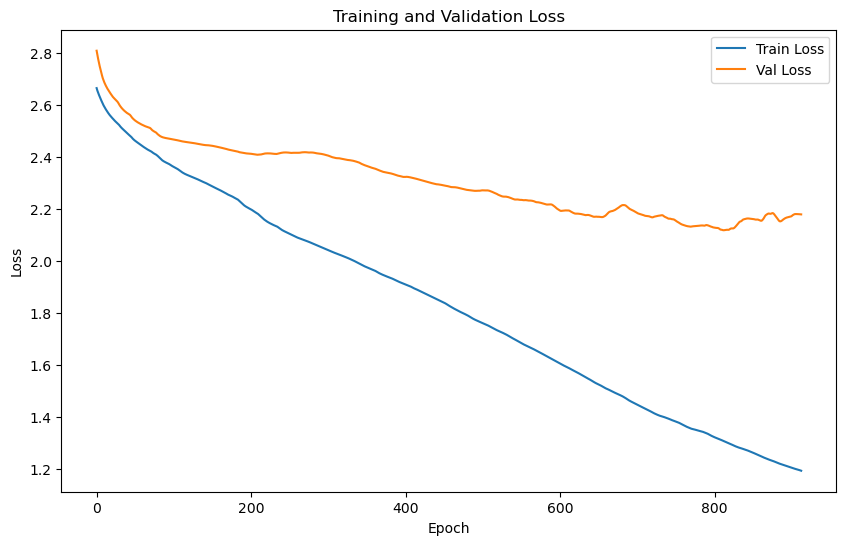

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 2.3591 | Test Accuracy: 40.29%


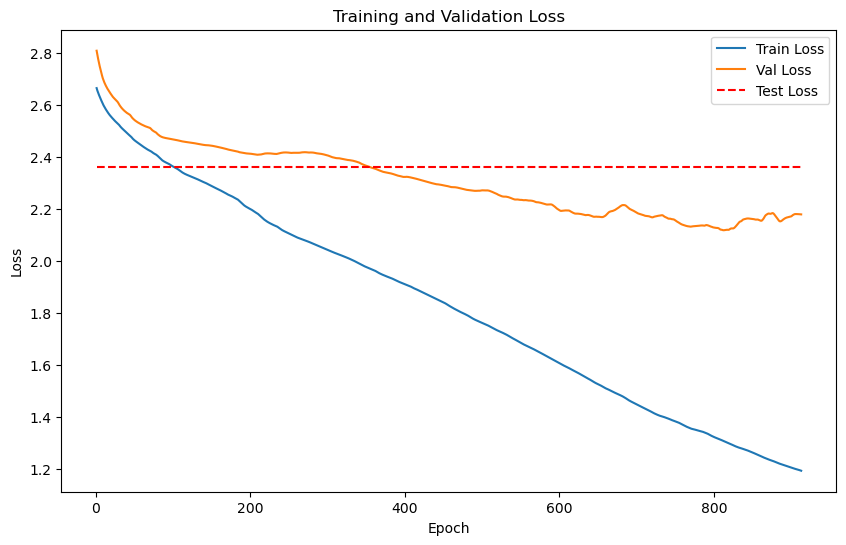

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


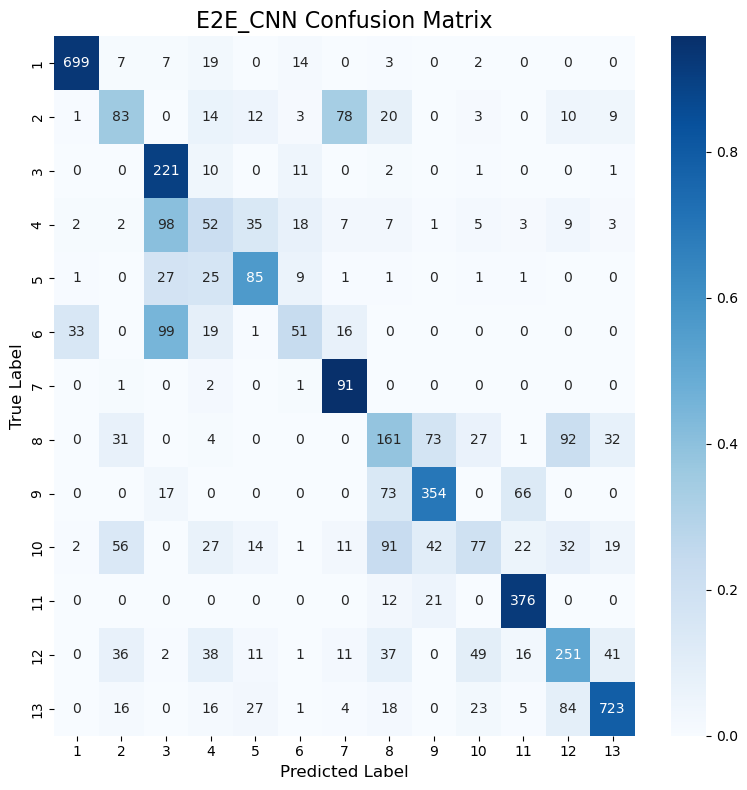

Classification Accuracy: 63.45%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


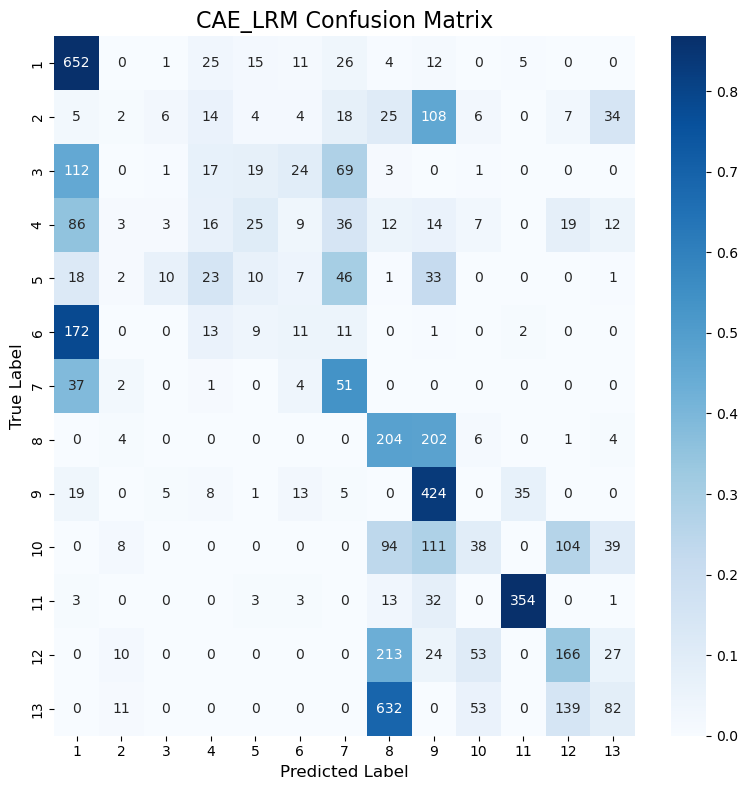

Classification Accuracy: 39.58%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


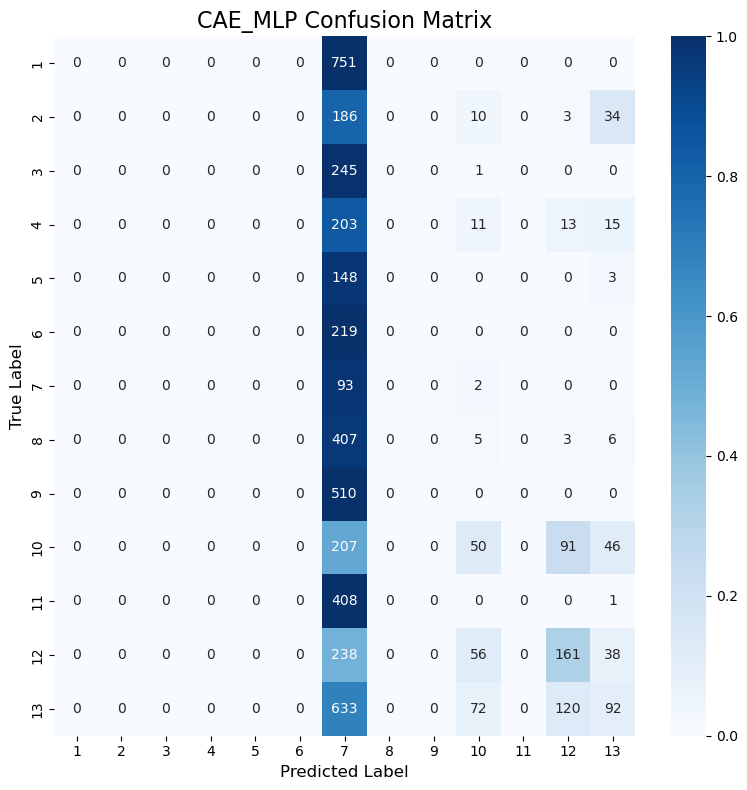

Classification Accuracy: 7.79%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


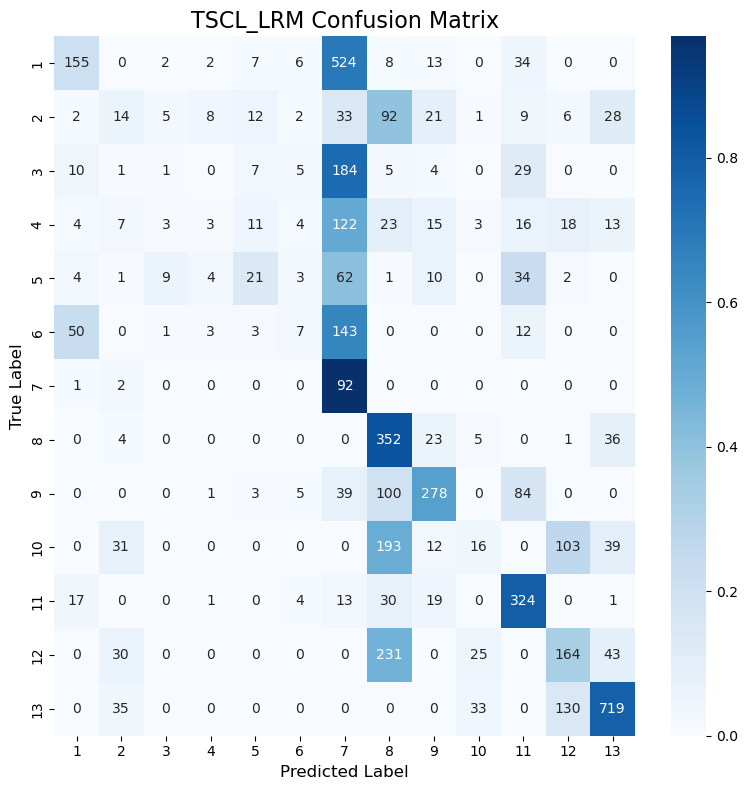

Classification Accuracy: 42.24%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


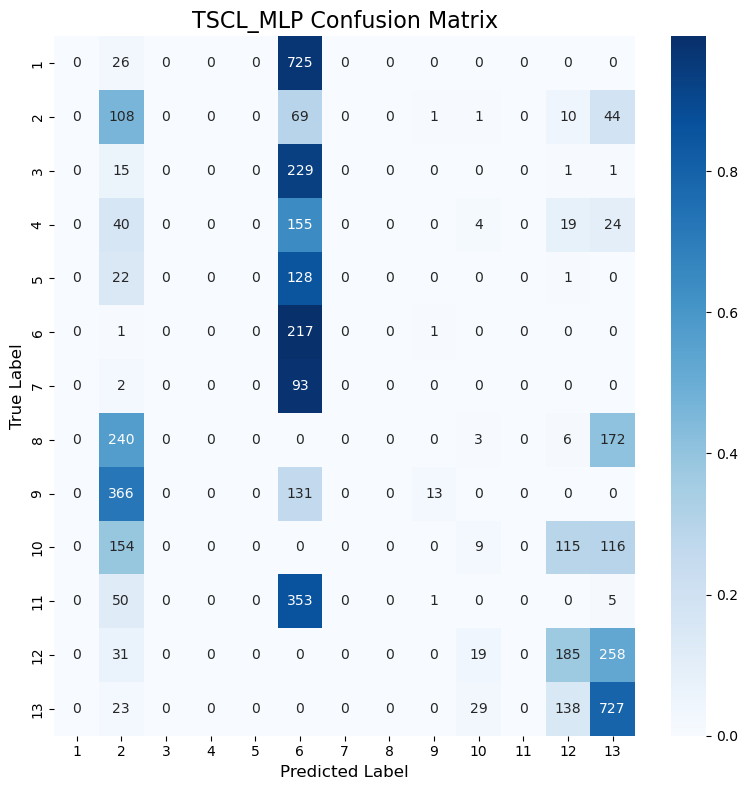

Classification Accuracy: 24.78%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


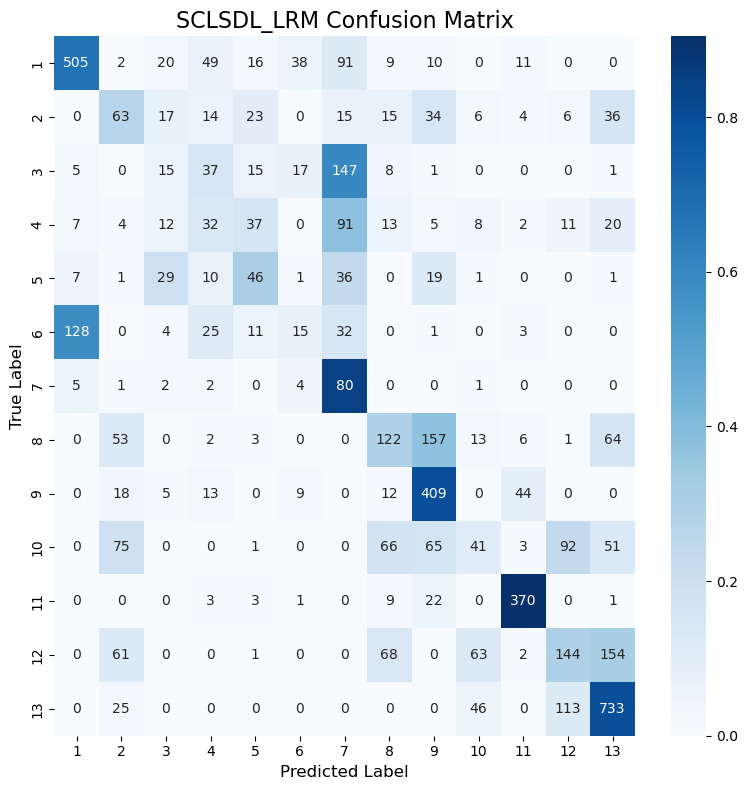

Classification Accuracy: 50.68%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


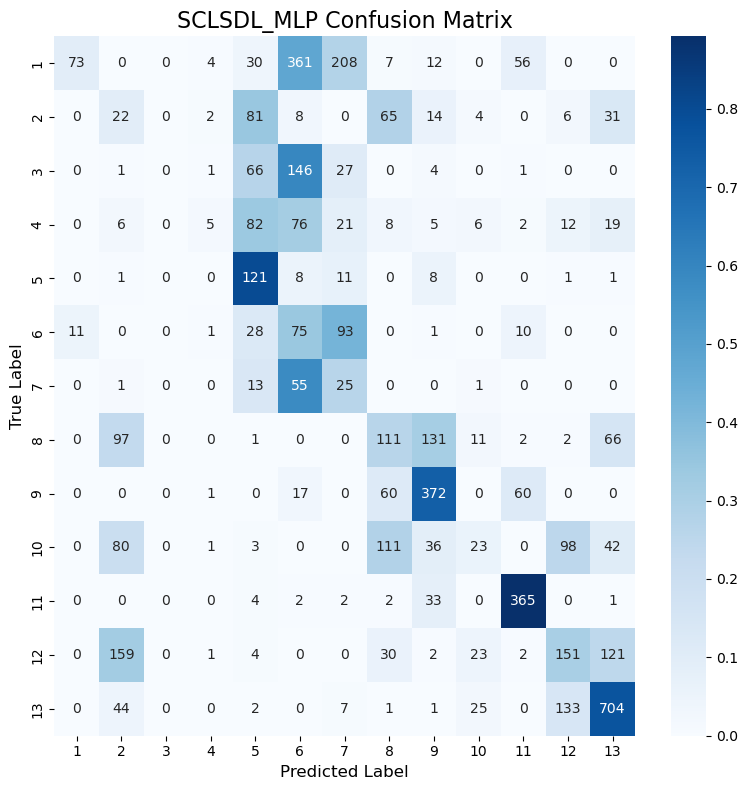

Classification Accuracy: 40.29%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          63.45
1    LRM (CAE)          39.58
2    MLP (CAE)           7.79
3     TSCL LRM          42.24
4     TSCL MLP          24.78
5  SCL_SDL LRM          50.68
6  SCL_SDL MLP          40.29

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          63.45
5  SCL_SDL LRM          50.68
3     TSCL LRM          42.24
6  SCL_SDL MLP          40.29
1    LRM (CAE)          39.58
4     TSCL MLP          24.78
2    MLP (CAE)           7.79
